# Emulators: First example

This example illustrates Bayesian inference on a time series, using [Adaptive Covariance MCMC](http://pints.readthedocs.io/en/latest/mcmc_samplers/adaptive_covariance_mcmc.html) with emulator neural networks .

It follows on from [Sampling: First example](../sampling/first-example.ipynb)

Like in the sampling example, I start by importing pints:

In [1]:
import pints

C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passi

Next, I create a model class using the "Logistic" toy model included in pints:

In [2]:
import pints.toy as toy

class RescaledModel(pints.ForwardModel):
    def __init__(self):
        self.base_model = toy.LogisticModel()
    
    def simulate(self, parameters, times):
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        r, k = parameters
        r = r / 50
        k = k * 500
        return self.base_model.simulate([r, k], times)
    
    def simulateS1(self, parameters, times):
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        r, k = parameters
        r = r / 50
        k = k * 500
        return self.base_model.simulateS1([r, k], times)
    
    def n_parameters(self):
        # Return the dimension of the parameter vector
        return 2

# Rescale parameters
#found_parameters = list(found_parameters)
#found_parameters[0] = found_parameters[0] / 50
#found_parameters[1] = found_parameters[1] * 500

# Show score of true solution
#print('Score at true solution: ')
#print(score(true_parameters))

# Compare parameters with original
#print('Found solution:          True parameters:' )
#for k, x in enumerate(found_parameters):
    #print(pints.strfloat(x) + '    ' + pints.strfloat(true_parameters[k]))
    
model = toy.LogisticModel()

In order to generate some test data, I choose an arbitrary set of "true" parameters:

In [3]:
true_parameters = [0.015, 500]
start_parameters = [1.0, 1.0]

And a number of time points at which to sample the time series:

In [4]:
import numpy as np
times = np.linspace(0, 1000, 400)

Using these parameters and time points, I generate an example dataset:

In [5]:
org_values = model.simulate(true_parameters, times)

And make it more realistic by adding gaussian noise:

In [6]:
noise = 5
values = org_values + np.random.normal(0, noise, org_values.shape)

Using matplotlib, I look at the noisy time series I just simulated:

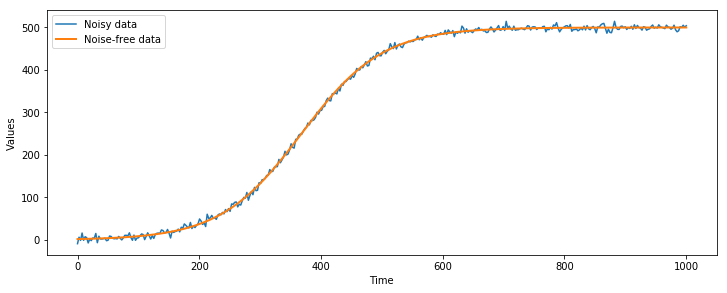

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4.5))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values, label='Noisy data')
plt.plot(times, org_values, lw=2, label='Noise-free data')
plt.legend()
plt.show()

Now, I have enough data (a model, a list of times, and a list of values) to formulate a PINTS problem:

In [8]:
model = RescaledModel()
problem = pints.SingleOutputProblem(model, times, values)

I now have some toy data, and a model that can be used for forward simulations. To make it into a probabilistic problem, a _noise model_ needs to be added. This can be done using the `GaussianLogLikelihood` function, which assumes independently distributed Gaussian noise over the data, and can calculate log-likelihoods:

In [9]:
#log_likelihood = pints.GaussianLogLikelihood(problem)
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

This `log_likelihood` represents the _conditional probability_ $p(y|\theta)$, given a set of parameters $\theta$ and a series of $y=$ `values`, it can calculate the probability of finding those values if the real parameters are $\theta$.

This can be used in a Bayesian inference scheme to find the quantity of interest:

$p(\theta|y) = \frac{p(\theta)p(y|\theta)}{p(y)} \propto p(\theta)p(y|\theta)$

To solve this, a _prior_ is defined, indicating an initial guess about what the parameters should be. 
Similarly as using a _log-likelihood_ (the natural logarithm of a likelihood), this is defined by using a _log-prior_. Hence, the above equation simplifies to:

$\log p(\theta|y) \propto \log p(\theta) + \log p(y|\theta)$

In this example, it is assumed that we don't know too much about the prior except lower and upper bounds for each variable: We assume the first model parameter is somewhere on the interval $[0.01, 0.02]$, the second model parameter on $[400, 600]$, and the standard deviation of the noise is somewhere on $[1, 100]$.

In [10]:
# Create bounds for our parameters and get prior
#bounds = pints.RectangularBoundaries([0.01, 400], [0.02, 600])
bounds = pints.RectangularBoundaries([-1.0, -1.0], [2.0, 2.0])
log_prior = pints.UniformLogPrior(bounds)

With this prior, the numerator of Bayes' rule can be defined -- the unnormalised log posterior, $\log \left[ p(y|\theta) p(\theta) \right]$, which is the natural logarithm of the likelihood times the prior:

In [11]:
# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

Finally we create a list of guesses to use as initial positions. We'll run three MCMC chains so we create three initial positions:

In [12]:
xs = [
    np.array(start_parameters) * 0.9,
    np.array(start_parameters) * 1.05,
    np.array(start_parameters) * 1.15,
]

And this gives us everything we need to run an MCMC routine:

In [13]:
chains = pints.mcmc_sample(log_posterior, 3, xs)

Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
[0.85577201 0.94251103]
-11273.767251133055
accepted


[1.06225091 1.01895062]
-74240.14840028553
accepted


[1.13092086 1.09132705]
-130599.55052593474
accepted


1     6      0.5       0.5       0.5        0:00.0
[0.87699096 0.83691706]
-29742.736545658332


[0.8868929  0.99550553]
-18941.413465084363
accepted


[1.15966287 1.13248043]
-168138.96539136345


2     9      0.333     0.667     0.333      0:00.0
[0.84502696 0.92285167]
-11103.891532034042
accepted


[1.00123227 0.89485155]
-40771.66865675702


[1.10153342 1.03446441]
-92765.06253036566
accepted


3     12     0.5       0.5       0.5        0:00.0
[0.78381109 0.78336692]
-46421.355997895844


[0.81394294 0.95890893]
-5464.105170122594
accepted


[1.18892579 1.07799647]
-144703.1795751297


[0.78370989 0.87854158]
-14736.53583332

-2101.4310866433557


[0.84366862 1.06083729]
-19680.99175893653


[0.599468   1.02136735]
-36979.156474441304


[0.87219155 1.10149415]
-38723.921817834715


[0.74084464 1.15577164]
-24564.988506517522


[0.89696596 1.03067047]
-26838.222365538866


[0.75882949 1.13022613]
-19801.025239509614


[0.64122231 0.8552088 ]
-50017.53201906363


[0.72326133 1.01680673]
-2016.240076410478


[0.50635742 1.11467884]
-110051.52028459837


[0.71939298 1.0422124 ]
-3116.2813224168453


[0.88507403 1.02284698]
-22342.309904760332


[0.72039113 0.9371022 ]
-7653.310654268552


[0.77195371 1.07466248]
-9142.011740430302


[0.77084638 1.04709794]
-5009.4633614383365


[0.77903559 1.00583616]
-2502.4541124666853


[0.57265529 1.20173875]
-60359.40086482072


[0.54221625 1.10009751]
-74367.43907601984


[0.61953682 0.98874647]
-29642.46631075512


[0.83509937 1.14456316]
-42793.16304634216


[0.76621137 1.01926426]
-2272.331622719414


[0.65775313 0.93785827]
-21659.856182882802


[0.70411666 1.05808714



[0.75483621 0.95307463]
-3288.0561683146684


[0.7357323  1.09642129]
-9699.698393663522


[0.65721383 1.0855573 ]
-14237.251223474706


[0.64284262 0.98186672]
-20439.19036764452


[0.79382016 1.02618822]
-5300.175684735863


[0.66393388 1.04598566]
-10765.758492825586


[0.64760252 1.02545632]
-15523.88129775543


[0.51235195 1.06121287]
-106523.56907494667


[0.74515081 0.80344678]
-41487.053105131


[0.93126692 1.12098331]
-66914.96181729305


[0.67422588 1.01444854]
-8658.682444837568


[0.81631958 0.87753611]
-15584.027746738933


[0.69707102 0.98701557]
-5644.5357250991565


[0.54969866 0.89211839]
-99620.93712269783


[0.7136183  0.89882781]
-15834.570224619856


[0.89595535 1.00673925]
-22477.39292708194


[0.5529311  0.95197315]
-81250.73868829061


[0.79842825 0.96377789]
-3911.9090645873453


[0.71296481 0.84464713]
-31278.307970550926


[0.62150548 0.9569902 ]
-33270.6872986457


[0.82684893 1.05183349]
-14205.235891621696


[0.69609151 0.97877655]
-6422.503348454357


[

[0.74865443 0.99991558]
-1229.2260267733109
accepted


[0.74776842 0.99778197]
-1236.5291526258616


[0.74879649 1.00151536]
-1232.0586923524684
accepted


[0.74807918 1.00137792]
-1231.2658450589502


[0.74855173 0.99866117]
-1230.935522543309


[0.74926611 1.00113961]
-1231.7572681396803
accepted


[0.74848177 1.00068576]
-1229.8093599194096
accepted


[0.75014108 0.9989646 ]
-1231.429998206511


[0.74930396 1.00043367]
-1230.1967885763254
accepted


[0.74843625 1.00048648]
-1229.5704398027926
accepted


[0.7469808  1.00018277]
-1232.785284936239


[0.74885605 1.00074756]
-1230.103582790773
accepted


[0.74794597 1.00028694]
-1229.9245401652738
accepted


[0.74899012 0.99912443]
-1229.6993599416192
accepted


[0.7485809  1.00072893]
-1229.8912017884636
accepted


[0.74761414 1.00006165]
-1230.687081217269
accepted


[0.74924306 0.99899575]
-1229.93579350459
accepted


[0.74740354 1.00078882]
-1231.3264544349092
accepted


[0.74794474 0.99941136]
-1230.5387919893706
accepted


[0.7495

[0.7516142  0.99751357]
-1239.509539181596


[0.74902652 0.9993902 ]
-1229.4334657528675
accepted


[0.74874635 1.00161763]
-1232.340851100272


[0.75145815 0.99754906]
-1238.6419048539626


[0.74973276 0.99863097]
-1230.9732828116391


[0.7495287  1.00192346]
-1235.6336854517112


[0.7480564  0.99992533]
-1229.7861223977484
accepted


[0.74908509 0.9992044 ]
-1229.6183470247204
accepted


[0.75050036 1.00157434]
-1238.5300804557398


[0.74886684 1.00029685]
-1229.466884234866
accepted


[0.74918755 0.99962545]
-1229.4299494015359
accepted


[0.7479843  1.00081586]
-1230.265511047199
accepted


[0.75025871 0.99880056]
-1231.8915004924481
accepted


[0.74952236 0.99919196]
-1229.9966259044618
accepted


[0.74836259 1.0004738 ]
-1229.5850244035737
accepted


[0.75080296 0.99775356]
-1235.4361315850763


[0.74915576 0.99934134]
-1229.5269280452735
accepted


[0.74719985 1.00291057]
-1237.7416525497135


[0.74944683 0.99942336]
-1229.7711546387652
accepted


[0.74894227 0.9986168 ]
-1230.6

-1231.139542136457


[0.7480126  0.99924139]
-1230.6719693117648


[0.74937734 1.00115874]
-1232.0954438279364


[0.74717935 1.00027844]
-1231.9487703530447
accepted


[0.74869079 0.99865069]
-1230.7787849479478


[0.74801029 1.00044789]
-1229.888434242314
accepted


[0.74661243 1.0005632 ]
-1234.2211627269653


[0.74635657 1.00030913]
-1235.746189754141


[0.74860784 1.00162649]
-1232.1938523002982


[0.7466895  1.00056953]
-1233.8558381757632


[0.74761361 1.001009  ]
-1231.0872419175146


[0.74936637 1.00015057]
-1229.926270281525
accepted


[0.74434694 0.99721042]
-1270.5690185941162


[0.75054513 0.99788847]
-1234.2874134866229
accepted


[0.74906596 0.99891937]
-1230.0039016053097
accepted


[0.74572035 1.00055345]
-1239.5414630787866


[0.74967947 0.99696142]
-1236.6468799405457


[0.74839618 0.99998427]
-1229.3512535712982
accepted


[0.74985035 0.99915534]
-1230.6019209102687
accepted


[0.74870747 0.99986808]
-1229.2183628972314
accepted


[0.74959298 1.00003224]
-1230.257864

[0.75135803 0.99741157]
-1238.5420277600083


[0.74931313 1.00018324]
-1229.8700775116713


[0.750546   0.99752977]
-1235.3311693038079


[0.74868242 0.99984026]
-1229.223736019062
accepted


[0.7474858  1.00078501]
-1231.116310736363
accepted


[0.74920709 0.99893232]
-1230.01089459403
accepted


[0.74939734 0.99815982]
-1231.7867080301944


[0.74542946 1.00213074]
-1242.0964612900107


[0.74970433 1.00167277]
-1235.1305017863936


[0.74892862 1.00024568]
-1229.4623140062738
accepted


[0.74942128 1.00068402]
-1230.9271362232344
accepted


[0.74599622 1.000493  ]
-1237.7377671105287


[0.74843915 1.00112093]
-1230.6189450857194


[0.75148997 0.99693832]
-1240.6730333569947


[0.7498849  1.00111307]
-1233.6036579267372


[0.74964956 1.00170114]
-1235.0471008840793


[0.75039552 0.99920216]
-1232.1533010947514


[0.7473501  1.00069759]
-1231.4131328257652


[0.75009198 1.00105725]
-1234.2604226676397


[0.75004995 0.99843842]
-1231.869545496717


[0.74845107 1.00139877]
-1231.3424738783

[0.75066572 0.99910196]
-1233.1931763065734


[0.74758045 1.0023912 ]
-1234.9678591618747


[0.74956196 1.00113695]
-1232.5565978239806


[0.75039681 0.99690689]
-1237.4867851551257


[0.74929075 1.00444487]
-1253.010651924751


[0.74624665 1.00390862]
-1245.3054317852893


[0.7499385  1.00004213]
-1231.199558398579
accepted


[0.74822032 0.99824624]
-1232.9409941412223


[0.74839257 1.00060445]
-1229.7129821158685
accepted


[0.75247609 1.00163117]
-1255.2044041300271


[0.74975801 0.99956239]
-1230.3342827974689


[0.74626636 1.00098455]
-1235.9495716315184


[0.74917028 0.99879798]
-1230.2251008002868
accepted


[0.74983276 0.99866415]
-1231.077443926658


[0.74484556 1.00190632]
-1246.0942005290067


[0.74876798 1.00078042]
-1230.0853778375545
accepted


[0.7476057  1.00146544]
-1231.942756655853


[0.75119386 0.9949291 ]
-1251.5196704698833


[0.75208266 1.00107279]
-1247.9264702613764


[0.74818814 1.00196878]
-1233.1335943865636


[0.74596967 1.00446021]
-1249.7832291837751


[0

-1229.6256301566086


[0.74918998 0.9996528 ]
-1229.4296233671207
accepted


[0.74907034 1.00187539]
-1234.0011273368982


[0.7483311  1.00022437]
-1229.4414459249545
accepted


[0.74893189 0.99898184]
-1229.917899513635
accepted


[0.74638682 1.00070083]
-1235.3169098753783


[0.74872105 1.00089698]
-1230.2784526591386


[0.74778613 0.99940833]
-1230.9559699391266


[0.74652131 1.0029813 ]
-1239.5648108316234


[0.7496845  0.99911284]
-1230.3066658588982
accepted


[0.74941044 0.99750186]
-1234.1543990247321


[0.74793979 1.0006273 ]
-1230.1163512395283
accepted


[0.75008281 0.99760436]
-1234.1485350544872


[0.74933101 1.00099658]
-1231.4959292598794


[0.74825629 0.9976582 ]
-1235.3757439848105


[0.75204967 0.99908327]
-1241.2880131560216


[0.74790088 0.9989606 ]
-1231.5859918959527


[0.74752069 1.00119739]
-1231.557406127136


[0.7508051  0.99849078]
-1234.082912748744


[0.74735631 1.00095272]
-1231.5986657435587


[0.74853002 0.99784284]
-1233.8033451793797


[0.74981344 1.00

[0.74737371 1.00151835]
-1232.483883850045


[0.74937014 0.99965733]
-1229.6386639618554
accepted


[0.746485   1.00180283]
-1235.8442957302245


[0.75047844 0.99760311]
-1234.9260398161841


[0.74577001 1.00242365]
-1240.730343683457


[0.74947826 1.00120608]
-1232.5319436057425


[0.75053065 0.99803402]
-1233.8969629601263


[0.75089236 0.99869652]
-1234.2738398298711


[0.74774219 0.99836321]
-1234.0355782279212


[0.7465155  1.00203167]
-1236.2496378920764


[0.75035238 0.99906906]
-1232.0221958209231


[0.74786169 1.00024816]
-1230.07078091269
accepted


[0.74959383 0.9966958 ]
-1238.1193478756309


[0.74862484 1.00135885]
-1231.3539186930427


[0.74807116 0.99657526]
-1242.6504421628856


[0.74768855 1.00308842]
-1238.3534138833827


[0.75179543 0.9972169 ]
-1241.2518060172692


[0.74766689 1.00034293]
-1230.4890020824682
accepted


[0.74846329 1.00109574]
-1230.5684345254926
accepted


[0.75080786 0.99526781]
-1248.211718469282


[0.74766527 0.99983371]
-1230.7193253392554
accep

[0.74631494 1.00320171]
-1241.2428776878912


[0.75053497 0.99837728]
-1233.2578849708107


[0.75352853 0.99753024]
-1253.9153906300373


780   2343   0.239     0.242     0.261      0:01.9
[0.7465153  0.99996556]
-1235.3237770482801


[0.74737623 1.00119212]
-1231.8621291542163


[0.751768   1.00141616]
-1246.9534046075803


[0.75018207 0.99960791]
-1231.5523552871814


[0.74985637 0.99821882]
-1232.000493913649


[0.7552649  0.99812492]
-1275.4908380378306


[0.74916032 0.99784587]
-1232.8896585737918


[0.74871882 0.99971449]
-1229.2441330979461
accepted


[0.75723926 0.99623226]
-1306.0265873693015


[0.74920429 1.00107753]
-1231.4353100014882


[0.75054619 1.00006993]
-1233.6114234237907


[0.75072901 0.99982554]
-1234.061090151112
accepted


[0.74689085 1.00108873]
-1233.1946595554782


[0.74705493 1.00318382]
-1239.3484418964113


[0.75458944 1.00211815]
-1287.7189182275374


[0.74902496 0.99798204]
-1232.4893628748055


[0.749773   0.99748117]
-1234.2929037543295


[0.74972687 1



[0.7499925  0.99716673]
-1235.7861251498334


[0.74960045 1.00021695]
-1230.5034430596793
accepted


[0.74784366 1.00071304]
-1230.338554693232
accepted


[0.74808152 1.00161713]
-1231.926791700528


[0.75149259 1.0021384 ]
-1249.0901598664427


[0.74765976 1.00254199]
-1235.5707031620411


[0.74879832 0.99980594]
-1229.2207112165247
accepted


[0.75007717 0.99896884]
-1231.2572178030591
accepted


[0.74695412 0.99742354]
-1242.9608755850243


[0.75104261 1.00041044]
-1237.1418756766275


[0.75223819 1.00327309]
-1266.1697303714916


[0.74881599 1.00066927]
-1229.9264134055925
accepted


[0.75036442 0.99760494]
-1234.657342329135


860   2583   0.242741  0.242     0.247      0:02.1
[0.74833645 0.99882778]
-1230.877838036179
accepted


[0.74988245 0.99953547]
-1230.6288878185187
accepted


[0.74726424 1.00196189]
-1233.8713041850792


[0.75004584 1.00103142]
-1233.9721370704037


[0.74793704 0.99947691]
-1230.4570739840863
accepted


[0.75063879 1.00051103]
-1235.1303694744563


[0.74

[0.74666728 1.00188817]
-1235.3336291966268


[0.74927922 1.00326073]
-1242.8127225354856


[0.74728205 0.99804142]
-1237.5199527851714


[0.75074006 1.00152841]
-1239.7582428735889


[0.74575477 1.00158657]
-1239.258236999454


[0.7487507  0.99802101]
-1232.6732551551584


[0.75011042 1.00114315]
-1234.6547908450043
accepted


[0.74513617 0.99979445]
-1245.9238666493454


[0.74635136 0.99904072]
-1238.7884317112173


[0.74896506 1.00164946]
-1232.8398594341058
accepted


[0.74879402 0.99884155]
-1230.245965008355
accepted


[0.74909037 1.00027446]
-1229.6511120804803
accepted


[0.74978898 1.00173921]
-1235.7764735545834


[0.74848626 0.99862897]
-1231.125447735888


[0.74841071 0.99924746]
-1229.9199614964768
accepted


[0.7482272  0.99880846]
-1231.1492849881963
accepted


[0.75039327 0.99669821]
-1238.4990379629503


[0.74884781 1.00096644]
-1230.5556259425275


[0.74418098 0.99716239]
-1273.2682124686055


[0.74742241 0.99853189]
-1234.700555073746


[0.74874676 0.99817117]
-1232.

[0.7480486  0.99992208]
-1229.8008598896854
accepted


[0.74808091 1.00659493]
-1272.0951926343191


[0.75006462 1.00100645]
-1233.9657296968915


[0.74813573 0.997736  ]
-1235.3805186526238


[0.74701518 1.00201713]
-1234.6058699464234
accepted


[0.74999328 0.99609618]
-1241.7371544828532


[0.7481092  1.00122277]
-1230.8836249641456


[0.74704775 1.00354421]
-1241.4120026634205


[0.74802131 0.99695748]
-1240.2334991054536


[0.7470349  0.99938286]
-1233.8332244611963


[0.74382278 1.00617839]
-1274.5150390031877


[0.74473474 1.00187128]
-1246.9935612728527


[0.74700943 0.99915794]
-1234.550723425232


[0.74596431 1.00396735]
-1246.5910536482122


[0.74641318 1.00373805]
-1243.8088950759814


[0.74903404 1.00251862]
-1237.1196841727499


[0.7468754  0.99968336]
-1233.9488832651618
accepted


[0.75497667 0.99923185]
-1274.4382267837946


[0.74879725 1.00032787]
-1229.4566917467441
accepted


[0.74420764 1.00145096]
-1251.901791748357


[0.74767189 1.00014234]
-1230.502606107995
acc

[0.74916204 0.99726436]
-1235.4246212541116


[0.74845836 0.99719705]
-1237.2070065852745


[0.74819046 1.00157669]
-1231.7943333809087
accepted


[0.75069928 0.99781785]
-1234.9311208061063


[0.74863202 1.00071131]
-1229.8808437421171
accepted


[0.74819352 1.00469701]
-1251.121607470838


[0.74681456 1.00148129]
-1233.9842486516752


[0.74971242 0.99977815]
-1230.3204958680344


[0.74823773 1.0023662 ]
-1234.8467873383681


[0.75088366 0.99641952]
-1240.9119230467763


[0.7490205  1.00159585]
-1232.7523508997826


[0.74756875 0.99877685]
-1233.2343176516906


[0.74714089 1.0004812 ]
-1232.0311548430668


[0.74660064 1.00412775]
-1245.8761538793565


[0.74760533 1.00351751]
-1240.9516972076067


[0.74934673 1.00033995]
-1230.1326325685595
accepted


[0.74932386 1.00127929]
-1232.3472094636718


[0.74795994 1.00582792]
-1262.2412438148203


[0.7464528  1.00242959]
-1237.648282164972


[0.74713745 0.9991064 ]
-1234.0805710925613


[0.74984915 1.00093755]
-1232.8905381722925


[0.750195


[0.75354329 0.99395844]
-1269.9307664740293


[0.74895031 1.00003759]
-1229.3273498413382
accepted


[0.75098649 0.99790067]
-1235.7592671241264


[0.74902333 0.99965924]
-1229.3077223298724
accepted


[0.74830816 0.99899821]
-1230.5400229268696


[0.74963464 0.99890949]
-1230.4278810038827
accepted


[0.7438144  1.00196939]
-1255.9436917209846


[0.75024835 0.99819166]
-1232.8016864404676


[0.74932432 0.99939288]
-1229.634064208367
accepted


[0.75062834 1.0024547 ]
-1244.5297323404548


[0.75003531 1.0007328 ]
-1232.9890068402262


[0.74327559 1.00453008]
-1268.0667569209106


[0.74797753 0.99628749]
-1245.270072824827


[0.74906078 1.0001106 ]
-1229.4647603587066
accepted


[0.75116686 1.00003763]
-1236.9048334425995


[0.75001024 0.99950089]
-1230.9651779640046


[0.74868815 1.00199492]
-1233.732381034927
accepted


[0.75031321 0.99771403]
-1234.201056686784


[0.74900127 1.00005728]
-1229.3752967106961
accepted


[0.74732446 1.00556597]
-1258.0457394413538


[0.7496197  1.002992

-1229.7188404541841
accepted


[0.75118097 0.99971106]
-1236.324897995216


[0.74512085 0.99968981]
-1246.406369389831


[0.74802089 0.99866015]
-1232.0843672906324


[0.75269462 0.99702963]
-1247.52031914514


[0.74785039 0.99906693]
-1231.471347260186


[0.74861313 1.00024602]
-1229.3443143164338
accepted


[0.75015816 0.99766714]
-1234.0540936404584


[0.74729921 0.99858877]
-1235.0480787690994
accepted


[0.74913999 0.99942262]
-1229.4645024604874
accepted


[0.74810273 1.00173295]
-1232.287074767044


[0.74680464 0.99949415]
-1234.7117877917042
accepted


[0.74855031 0.99708756]
-1237.5725697395428


[0.75013109 0.99928881]
-1231.2877005739645


[0.74916843 0.99978523]
-1229.4170502503582
accepted


[0.74743121 0.99919153]
-1232.5948881288134


[0.74819344 0.99874926]
-1231.3825805608426


[0.74818519 1.00038334]
-1229.645095509696
accepted


[0.75107313 0.99587284]
-1244.5181302659962


[0.75113316 0.99949601]
-1235.731930814155


[0.74990186 0.99869051]
-1231.163580452516


1240

[0.74702563 0.9998008 ]
-1233.0475435562396
accepted


[0.74907398 1.00063185]
-1230.1567680445453
accepted


[0.74958307 0.99871248]
-1230.6439313632188


[0.74664689 0.99988363]
-1234.7472979801225


[0.74792391 1.00051635]
-1230.0553286692684
accepted


[0.75169664 0.99753737]
-1239.8897460274745


[0.74605684 0.99956984]
-1239.101802704086


[0.74545762 0.99991163]
-1242.7684903911108


[0.74868483 1.00104292]
-1230.5720150999853


[0.74468053 1.0016299 ]
-1247.3519711328292


[0.74535207 0.99913945]
-1246.3663829029847


[0.74870539 1.0005606 ]
-1229.6867232305215
accepted


[0.74726171 0.99923323]
-1233.181526918091
accepted


[0.74642236 1.00062781]
-1235.1535007538785


[0.74922566 0.99992719]
-1229.53160189932
accepted


[0.74841069 0.99749773]
-1235.7247192093353


[0.74882569 1.00116216]
-1231.0209285432582


[0.74830231 0.99973254]
-1229.5324649559725
accepted


[0.74889838 0.99755054]
-1234.4092453096143


[0.74695429 0.9986359 ]
-1236.6329948195776


[0.74900829 0.999196 

[0.74849109 1.00222407]
-1234.458508873933


[0.74827783 1.0034253 ]
-1240.996799893671


[0.75258776 0.99802106]
-1245.1656327412857


[0.74787268 0.99942065]
-1230.702849432539


[0.74739947 1.00282039]
-1237.0705859411162


[0.74738541 1.00070763]
-1231.3204601487162


[0.7473911  1.00098946]
-1231.5508412282843


[0.74705187 1.00079192]
-1232.4060366489382


[0.74944464 0.99931217]
-1229.8163526851456
accepted


[0.746532   1.00219811]
-1236.6407732802097


[0.74691693 0.99954472]
-1234.0299743154924
accepted


[0.74839557 1.00029662]
-1229.4354385691636
accepted


[0.74799117 1.00012821]
-1229.8409096192784
accepted


[0.74567085 1.00178065]
-1240.003901799116


[0.74803173 0.99976814]
-1229.9278741844923


[0.75146003 0.99888811]
-1237.1705621123858


[0.74626551 1.00020524]
-1236.4050784781955


[0.74806824 1.00090895]
-1230.315852794347


[0.74842625 0.99777265]
-1234.3601576423168


[0.75100536 0.99494038]
-1251.09185979021


[0.74961786 0.99984324]
-1230.150010052227
accepted

[0.74725053 1.0005826 ]
-1231.669453494543
accepted


[0.75018927 0.99898339]
-1231.5530908579926


[0.74519856 1.00133434]
-1243.0026264245184


[0.74384557 1.00074715]
-1256.8807809326315


[0.74755148 0.99730598]
-1240.2171043130284


[0.75007751 1.00128875]
-1235.0708971458562


[0.74763674 0.99993676]
-1230.7080307727933
accepted


[0.74964881 0.99998757]
-1230.34104013987
accepted


[0.74759266 1.00231906]
-1234.6619410923747


[0.74749795 1.00103407]
-1231.3574623264576


[0.74850238 0.99795988]
-1233.3740616992252


[0.7465002  1.00035913]
-1234.9113268753663


[0.74690278 0.99978543]
-1233.6328702114506


[0.75190036 0.99943626]
-1240.6768097039694


[0.74858692 0.99911558]
-1229.920539763114


[0.74603136 1.00252198]
-1239.7012061486341


[0.74967649 1.00071115]
-1231.6802077415305
accepted


[0.74889641 1.00116434]
-1231.1234697878951


[0.74567239 1.00218506]
-1240.6995332807828


[0.75059652 0.99938854]
-1232.9900878648752
accepted


[0.7460257 0.9989616]
-1241.43669660586

[0.75085049 0.99571545]
-1245.0575043237995


[0.74637237 0.99920804]
-1238.0658097306757


[0.74823059 0.9995876 ]
-1229.7498226441196
accepted


[0.75020578 0.99871635]
-1231.8298426104416
accepted


[0.75032933 0.9984805 ]
-1232.4802154505057


[0.74752688 0.99964453]
-1231.364643514396


[0.74977146 0.99774592]
-1233.302236935243


[0.74863865 1.00134118]
-1231.315273798256


[0.74724417 0.99861864]
-1235.1972395223868


[0.75200014 1.00051462]
-1244.597869444372


[0.74892866 0.99806891]
-1232.271980628641


[0.75090588 0.99769032]
-1235.9596712298166


[0.75044699 0.99953618]
-1232.4743262497097


[0.74724414 0.99820944]
-1236.9151349856554


[0.749851   1.00008259]
-1230.9889524963637
accepted


[0.74769034 1.00326705]
-1239.3994486626377


[0.74866941 0.99934243]
-1229.536026082677
accepted


[0.75110049 0.9986463 ]
-1235.2627734602097


[0.75411272 0.99658181]
-1261.325637633062


[0.74869623 0.99826505]
-1231.8938124137235


[0.74896749 1.0017337 ]
-1233.1734589179694


[0.74

[0.74923901 0.99945836]
-1229.5214903079554
accepted


[0.7481419  0.99561998]
-1250.1490435933727


[0.75296349 0.99860108]
-1248.534945519582


[0.74840889 0.99971996]
-1229.42281254216
accepted


[0.74831415 0.99939923]
-1229.8409995905495
accepted


[0.74443687 0.99706152]
-1270.7315562170222


[0.75216885 0.99872214]
-1241.887922119559


[0.7478027  0.99855497]
-1233.1128563799057


[0.74860953 1.00009984]
-1229.2695646323673
accepted


1660  4983   0.228     0.232     0.245      0:03.9
[0.74851546 0.99950718]
-1229.4834647015841
accepted


[0.74719967 0.99900584]
-1234.0881947529258


[0.74778608 1.00115641]
-1231.0434546312913


[0.74971895 0.99826952]
-1231.7040259949056


[0.74757827 0.99932434]
-1231.759226439199


[0.74992044 0.99927071]
-1230.7192651421904


[0.74914435 0.99832087]
-1231.3329199946993


[0.74947786 1.00214603]
-1236.5690113896057


[0.7472775  1.00035781]
-1231.582587529023


[0.74952601 0.99998232]
-1230.0656254113528
accepted


[0.74825688 0.99804061]
-12

[0.74910046 1.00021504]
-1229.5999766765144
accepted


[0.74850963 1.00115422]
-1230.7238619748512
accepted


[0.74652972 0.99898145]
-1237.8383684092091


[0.74788978 0.99965557]
-1230.3356553055964


[0.74776707 1.00098618]
-1230.7906203938048
accepted


[0.75034915 0.99686208]
-1237.6228793053738


1740  5223   0.233     0.231     0.244      0:04.1
[0.75090177 1.00085915]
-1237.8054022567796


[0.74914971 1.00190998]
-1234.3606632940405


[0.75318672 0.99516103]
-1258.984565636965


[0.74636851 1.00089576]
-1235.3982874948372


[0.74774676 1.00379507]
-1242.9092629478205


[0.74736638 0.99748585]
-1240.1007692686771


[0.74755591 1.00381217]
-1242.9302194541071


[0.74793071 0.99935853]
-1230.6601181964634
accepted


[0.74981317 0.99967334]
-1230.506068463737
accepted


[0.74778425 0.99751536]
-1237.8783500633904


[0.74768235 1.00062011]
-1230.5555552051017
accepted


[0.7503466  0.99881859]
-1232.1404136577896


[0.74754459 0.9999971 ]
-1230.9233459525328


[0.74819655 1.00016151]

[0.7511409  0.99811235]
-1236.0171752939382
accepted


[0.74951221 0.99719794]
-1235.5016613133666


[0.74705314 1.0031229 ]
-1239.0299701616716


[0.75029098 1.00047334]
-1233.3549604887278
accepted


[0.74894265 0.99934369]
-1229.4563276980937
accepted


[0.7502826  0.99940358]
-1231.7927479531527


[0.75132006 0.99958573]
-1236.9615846429451


[0.74893732 0.99842254]
-1231.1526919098087
accepted


[0.74495993 1.00220665]
-1245.561551766019


[0.75225645 1.00113651]
-1249.9268349483953


[0.74639813 1.00059049]
-1235.297776136578


[0.74833659 0.99958755]
-1229.6017910235983
accepted


[0.74921207 0.99869421]
-1230.431001787822
accepted


[0.74677827 1.00042562]
-1233.5066571108825


[0.74848543 1.0012363 ]
-1230.9173933023214


[0.74755829 1.00275836]
-1236.6465659711866


[0.74931827 0.99973769]
-1229.5807751083887
accepted


[0.74563917 1.0013471 ]
-1239.8261007460687


[0.74837502 0.99659129]
-1241.311058302113


[0.74894213 0.99841722]
-1231.164059289149


[0.74816324 0.9981526 

[0.74891842 1.00313812]
-1240.6222658745548


[0.75216865 0.99687968]
-1244.4134690733188


[0.74567515 1.00214251]
-1240.5934180552736


[0.75071072 0.99723353]
-1236.802873557867


[0.74765671 1.00014424]
-1230.539876288575


[0.74519315 0.99968959]
-1245.7378383938544


[0.74938805 1.00006501]
-1229.8777531054463
accepted


[0.75019973 0.99899809]
-1231.5748009338527


[0.75121956 1.00226761]
-1247.6799705924454


[0.74722334 0.99936654]
-1233.0253869771009


[0.74686125 0.99949209]
-1234.4255255544263


[0.74557837 1.00011523]
-1241.310378696021


[0.74679938 0.99811844]
-1239.9235377390185


[0.74895047 1.00059995]
-1229.941839221916
accepted


[0.74819304 0.99812289]
-1233.4933228814448


[0.74622388 1.00369517]
-1244.1152706158218


[0.75091569 1.00007091]
-1235.5053525601606


[0.74923544 1.00090551]
-1231.0392234745946


[0.74793975 1.00076687]
-1230.2589343927061
accepted


[0.74776852 0.99871075]
-1232.7157038667528


[0.74922877 0.99926781]
-1229.6310786789536
accepted


[0

[0.74848718 1.00230039]
-1234.8091202503547


[0.7482018  0.99974959]
-1229.656744152654


[0.74943221 0.99967048]
-1229.7316732453173
accepted


[0.74730445 1.00060123]
-1231.5068952027016
accepted


[0.74738911 0.99962715]
-1231.865321410689


[0.75007919 0.9978285 ]
-1233.4094023302644


[0.74661595 1.00010584]
-1234.5775581314615


[0.74776248 1.00276793]
-1236.6283505193603


[0.74850312 0.99821691]
-1232.3906591734192


[0.74812174 1.00144949]
-1231.4383802357243
accepted


[0.74824604 1.00087133]
-1230.1433992731327
accepted


[0.75124124 1.00067653]
-1239.3379744047252


[0.74575724 1.00155889]
-1239.2158393276964


[0.74731281 1.00021707]
-1231.5145861398166


[0.75067179 0.99988268]
-1233.8742827715512


[0.74772595 1.00040309]
-1230.3671729458702
accepted


[0.74837787 1.00018983]
-1229.3957661722554
accepted


[0.7499161  0.99820224]
-1232.1288485508996
accepted


[0.74742247 1.00135845]
-1232.0497154718257


[0.74809315 1.0049239 ]
-1253.0268868218852


[0.74931819 0.99802

[0.74867577 0.99967777]
-1229.2697755723243
accepted


[0.74978493 1.00060525]
-1231.7609293199425
accepted


[0.74696274 1.0033716 ]
-1240.5212678461085


[0.74718245 0.99964066]
-1232.6439888932696


[0.75178477 1.00146673]
-1247.3921899446955


[0.74766587 0.9999542 ]
-1230.616522273122


[0.74754981 0.99842968]
-1234.54415163115


[0.74912988 1.00263366]
-1238.0837578823255


[0.75341877 0.99869322]
-1253.1954259427966


[0.74730085 0.99962432]
-1232.1996189933218


[0.75089306 0.99954516]
-1234.5025891793744
accepted


[0.74959472 1.00080143]
-1231.6683386688549


[0.74708459 1.00159486]
-1233.35081758815


[0.75164426 1.00043589]
-1241.395708529888


[0.75014584 1.00061233]
-1233.1016138765985


[0.74651632 0.9991126 ]
-1237.4626548067436


[0.75228691 1.00038277]
-1246.6274637138915


[0.75076895 1.00024675]
-1235.1144300374888


[0.74872932 0.99886292]
-1230.2542646015354


[0.74831605 0.99876214]
-1231.0834645772725
accepted


[0.74852529 0.99910024]
-1230.0150172192155
accept

[0.75430477 0.9959585 ]
-1265.0969760822127


[0.74863545 1.002282  ]
-1234.951643219806


[0.74877431 1.00118285]
-1231.0142509286527
accepted


[0.7454868  0.99831112]
-1249.304768666448


[0.7500793  1.00171246]
-1236.960875798819


[0.75137222 1.00301162]
-1254.7937167431396


[0.74707127 0.99747684]
-1241.875635764628


[0.74919502 0.9998836 ]
-1229.474679620676
accepted


[0.74875394 1.00155812]
-1232.142968728797


[0.75321965 0.99617955]
-1254.268134777349


[0.75287602 0.99994551]
-1250.7161532199557


[0.74773228 1.00043396]
-1230.3624834067882
accepted


[0.74864211 0.99908784]
-1229.9132954782567


[0.74694493 0.99987732]
-1233.2922267074507


[0.74919684 1.00112672]
-1231.5616188926472


[0.75314365 0.99822814]
-1250.0092319977366


2160  6483   0.234     0.236     0.242      0:05.1
[0.74825743 0.99858003]
-1231.7216198880676


[0.74935294 0.99664335]
-1238.6286862428574


[0.7508271  0.99635665]
-1241.1134729618245


[0.74965871 0.99689447]
-1236.99904376826


[0.75227295

-1229.3955579882154
accepted


2240  6723   0.233378  0.234     0.244      0:05.2
[0.74490314 1.00286493]
-1247.4648291213493


[0.74962568 0.99856975]
-1230.9463945471252
accepted


[0.74721627 1.00347336]
-1240.8078399040182


[0.74841148 1.00224872]
-1234.473289666339


[0.75614057 0.99721604]
-1287.6837300202624


[0.75136489 1.00008564]
-1238.2995448325473


[0.75066666 0.99852015]
-1233.5195771606816
accepted


[0.74864687 1.00218802]
-1234.526172739457


[0.74928616 1.00241493]
-1237.3427442937384


[0.75207442 1.0032127 ]
-1263.7314286438905


[0.74940626 0.9975556 ]
-1233.929283140017


[0.75021981 1.00138281]
-1236.1353660392526


[0.7523438 0.9993312]
-1244.0256692358294


[0.75063697 0.99475439]
-1252.2990647081604


[0.75207254 0.99510076]
-1253.0129057352779


[0.74748037 0.99671844]
-1244.6150912040982


[0.74999038 0.9981776 ]
-1232.3090132469943


[0.74821593 0.99816979]
-1233.2442838851678


[0.7498325  0.99956412]
-1230.5113053550704
accepted


[0.75156382 1.00028192

[0.74855929 0.99785324]
-1233.6950701212384


[0.74765215 1.00011679]
-1230.5615377795764
accepted


[0.74569228 1.00808537]
-1288.6751270978023


[0.74838661 1.00025231]
-1229.4166273062488
accepted


[0.74641122 1.00350633]
-1242.4964533375532


[0.74796157 1.00303792]
-1238.1578307389198


[0.75076245 1.00143552]
-1239.4391410363073


[0.74480692 1.00111172]
-1246.3639183356845


[0.74657219 1.00354683]
-1242.295047030368


[0.74781309 1.00058156]
-1230.2806586477172
accepted


[0.74869503 0.99855621]
-1231.0207104233518
accepted


[0.74835761 1.0014732 ]
-1231.517560749327
accepted


[0.7491102  1.00255443]
-1237.555777243175


[0.75097877 0.99906089]
-1234.6041734004073


[0.74695922 1.00019655]
-1232.8650573517139


2320  6963   0.231     0.232     0.245153   0:05.4
[0.74583512 1.00117501]
-1238.5013413810482


[0.74780834 1.00058158]
-1230.2890376613818
accepted


[0.74912438 1.00292776]
-1239.9038449253658


[0.74509112 1.00028536]
-1245.0268271491643


[0.74661177 1.00366652]


[0.75214143 0.99967883]
-1243.0849621957664


[0.74937038 0.99760869]
-1233.7208955881138
accepted


[0.74937697 0.9982757 ]
-1231.4545847649808


[0.74987416 0.99661675]
-1238.518790853841


[0.75279745 0.99283864]
-1276.4470173860755


[0.74607802 1.00172972]
-1237.6070170571156


[0.75034641 1.00074207]
-1234.364939427818


[0.74779567 1.00192281]
-1233.0341690147636
accepted


[0.75080293 1.00060416]
-1236.317743265306


[0.74556316 0.99954983]
-1242.9610169184068


[0.74840384 1.00418513]
-1247.115586840178


[0.75165449 0.99912635]
-1238.5313807165544


[0.74717463 1.00116634]
-1232.352939966568
accepted


[0.74400614 1.00487706]
-1263.426421616208


[0.74725726 1.00055271]
-1231.642418558108


[0.74808885 0.99895831]
-1231.0944093121577
accepted


[0.74745585 1.00161498]
-1232.5514482379501
accepted


[0.74955897 1.00015239]
-1230.3192846523255


[0.74177446 1.00004511]
-1290.1064099092641


[0.74933977 0.99940363]
-1229.6456975222466
accepted


[0.7504048 1.0027838]
-1245.36052

[0.74699566 1.00382834]
-1243.2709290834496


[0.74759206 1.00277959]
-1236.733151643384


[0.74889914 0.99919319]
-1229.6201190080533
accepted


2480  7443   0.227     0.23      0.241      0:05.8
[0.75010646 0.99960953]
-1231.3055367092807


[0.74464087 1.00307005]
-1250.0502602788388


[0.75000483 0.99754665]
-1234.2511109629068


[0.75273163 0.99746966]
-1246.9028259242677


[0.74812666 1.00219785]
-1234.0324638975155


[0.74688098 0.9990437 ]
-1235.5648526644145


[0.74894438 1.00318868]
-1241.0529133825535


[0.74593491 1.00721832]
-1276.876950176769


[0.74718143 1.00380199]
-1242.9303526132715


[0.7539711  0.99797571]
-1258.5412819634112


[0.74841376 0.99945304]
-1229.643430171172
accepted


[0.7496536  1.00620748]
-1275.9924139629961


[0.75165541 0.99937719]
-1238.8301654352151


[0.74916182 0.99924221]
-1229.6121455495208
accepted


[0.7474961  1.00209665]
-1233.9294001810435


[0.74972458 1.00317694]
-1244.2767911727847


[0.74856579 0.99888363]
-1230.386424483399
accepted

[0.74835059 0.99851156]
-1231.7248711619782


[0.74602431 1.00521965]
-1255.5600012011148


[0.75055635 1.00242986]
-1243.874498722075


[0.74697924 1.00348546]
-1241.1523798241192


[0.7511078  0.99822886]
-1235.6950532560668


[0.74795698 1.00421211]
-1246.3601512758337


[0.74991719 0.99899787]
-1230.8524431811725


[0.7523106  1.00217876]
-1257.3686262250633


[0.74768745 0.99934336]
-1231.3663720410334


[0.74702496 1.00487259]
-1251.2585029794657


[0.74666923 1.00443975]
-1248.014501738438


[0.74926003 0.99863738]
-1230.5577399270583
accepted


[0.74731988 1.00121202]
-1232.0292732765533


[0.75193119 0.99886794]
-1240.2307862871407


[0.74540811 1.00009278]
-1242.7311730551605


[0.74793685 0.99764749]
-1236.5379977006958


[0.74878791 1.00135718]
-1231.5347268991832


[0.75070259 0.99986594]
-1233.99629989636


[0.74646508 1.00398001]
-1245.176660686423


[0.75029597 1.00088472]
-1234.58929442041


[0.75045729 0.99719738]
-1236.3381295468287


[0.74526513 1.00540621]
-1259.65

[0.74869702 0.99878927]
-1230.442794554015


[0.75037375 0.99935963]
-1232.1016261509358


[0.74741134 1.00099474]
-1231.507296936681


[0.7490547  0.99775042]
-1233.348592635772


[0.74887064 1.00038614]
-1229.5651504751556
accepted


[0.74802507 0.99687018]
-1240.7942359598417


[0.748625   0.99752706]
-1235.0373519251793


[0.74664554 1.00114073]
-1234.212791831365


[0.74743321 1.00300767]
-1237.9964497502385


[0.74868715 0.9982068 ]
-1232.1032588035748


[0.75076961 1.00149604]
-1239.7840409851162


[0.74796422 0.99880904]
-1231.8093635353096
accepted


2640  7923   0.225     0.225     0.237      0:06.2
[0.74932816 0.9988928 ]
-1230.1325279075204
accepted


[0.75173517 0.99960422]
-1239.773643360843


[0.74631405 0.9993846 ]
-1237.891594975418


[0.74971543 0.99998522]
-1230.5011952290577
accepted


[0.74828202 0.99833805]
-1232.451802010276


[0.75056247 1.00156389]
-1238.8431531029578


[0.75024253 1.002161  ]
-1240.2410930505737


[0.74323386 1.00409803]
-1266.57721057063


[0

[0.75077604 1.00131065]
-1238.930690677172


[0.74983613 0.99751788]
-1234.1912649577146


[0.74904437 1.00068368]
-1230.211195890599
accepted


[0.74680859 1.00045805]
-1233.3569264448392


[0.74975038 0.99944593]
-1230.305542035062
accepted


[0.75109367 0.99850368]
-1235.3269498173981


[0.74765109 1.00074361]
-1230.7136483357995
accepted


[0.74963797 1.00080815]
-1231.813977402745


[0.74811431 1.00054775]
-1229.8354888715157
accepted


[0.74773554 1.00342579]
-1240.399876648563


[0.74833841 1.00003166]
-1229.3984251999811
accepted


[0.74849455 1.00093886]
-1230.2444560775893


[0.75113796 0.99974506]
-1236.1299453539318


[0.74774412 1.00055567]
-1230.3923967387775
accepted


[0.74790373 1.00188452]
-1232.843173975347


[0.74218331 1.00508975]
-1283.1796524625922


[0.7479684  1.00001489]
-1229.905670610726
accepted


[0.74771893 0.99976742]
-1230.6406153023352
accepted


[0.74894391 0.99918868]
-1229.6201312513665
accepted


[0.74962074 0.99772167]
-1233.2970146305552


[0.745

[0.74822261 1.00044023]
-1229.6485175549178


[0.75034742 0.9985082 ]
-1232.4907166250814


[0.74701368 0.99917304]
-1234.4864077653801


[0.75025543 1.00243736]
-1242.0322161661481


[0.74762636 0.99895367]
-1232.4913127079421


[0.74705223 1.00260169]
-1236.5917455357558


[0.74750077 0.99852396]
-1234.3897960174356


[0.74904827 0.99672677]
-1238.5756614694587


[0.74637768 1.00052914]
-1235.441580526493


[0.74831493 1.00323794]
-1239.811190225378


[0.74962776 0.99803847]
-1232.2500884535907


[0.74653196 1.00131524]
-1234.8739624779312


[0.74764176 1.00006585]
-1230.6115335091072


[0.74530064 0.99670027]
-1263.443555529405


[0.74394807 1.00307135]
-1256.0576275586536


[0.74821327 1.00079791]
-1230.046421468211


[0.75149123 0.99738227]
-1239.2394620613577


[0.74697802 1.00114022]
-1232.9393945766687


[0.74890846 1.00108933]
-1230.9384694529422


[0.74985533 0.9973645 ]
-1234.8233564890515


[0.7444687 1.0012352]
-1249.4363782815515


[0.74624272 0.99801453]
-1244.4561863978

[0.74946698 1.00156976]
-1233.844621634185
accepted


[0.74858598 1.00236057]
-1235.2511510429056


[0.74494737 1.00370709]
-1250.3290369482759


[0.7492586  1.00121922]
-1231.9865369798774
accepted


[0.74996217 1.00164376]
-1236.0842327784096


[0.7489937  1.00082838]
-1230.4342910272155


[0.747584   1.00230244]
-1234.6029472520022


[0.74889179 0.99969083]
-1229.2525090607342
accepted


[0.74911774 1.00227853]
-1236.0614807027755


[0.75073063 1.00137102]
-1238.9299414457003


[0.7501111  0.99949302]
-1231.2627666403982


[0.74759898 1.00057403]
-1230.7110722270827


[0.75074587 1.00129753]
-1238.6824350653092


[0.74810758 0.99930179]
-1230.3535000244358


[0.74910164 1.00152572]
-1232.6703828929508


[0.75158575 1.00326144]
-1259.0664424151398


[0.74922246 1.00106038]
-1231.426044293659
accepted


[0.74643388 0.99930207]
-1237.370681460847


[0.75013712 1.00226922]
-1240.3025856528684


[0.74673818 1.00333382]
-1240.736003240432


[0.75084766 0.99806048]
-1234.8991049931153


[0

[0.74658979 1.00202945]
-1235.9656448537532


[0.74893845 0.99780736]
-1233.2468643024993


[0.74827684 0.99779698]
-1234.6553580922005


[0.74822175 1.00259063]
-1235.9293015091412


[0.74931243 0.99822461]
-1231.5872244312259


[0.74889109 0.99884837]
-1230.173289425353


[0.74772412 1.00323055]
-1239.1867847819706


[0.74802895 1.00068159]
-1230.0563812056478
accepted


[0.74858936 0.99821905]
-1232.2217636798432


[0.74795377 1.00071301]
-1230.1808708922404
accepted


[0.74930223 0.99993585]
-1229.6398063094084
accepted


[0.7460886  1.00127582]
-1237.0452678554843


[0.74666023 1.00385487]
-1243.9562468437316


[0.75004905 1.00361569]
-1249.7318151265772


[0.74608652 1.00265584]
-1239.8920137109667


[0.74880906 1.00031547]
-1229.4507205030702
accepted


[0.74699963 1.00187421]
-1234.2496922376322


[0.75049182 0.99960861]
-1232.7166747832773


[0.74804961 1.00054656]
-1229.906154981684
accepted


[0.7482073  0.99967723]
-1229.7034984282586


[0.75069944 1.00038562]
-1235.1010555

[0.75053819 0.99691051]
-1237.7308952116246


[0.74860506 1.00107545]
-1230.5896109533523


[0.75085686 1.00044229]
-1236.1297747856972


[0.75014657 0.99949903]
-1231.3767359341018


[0.75040357 0.99806466]
-1233.4731610963302


[0.74969191 0.99918246]
-1230.2723493222363
accepted


3040  9123   0.226     0.232     0.234      0:07.1
[0.74971196 0.99967452]
-1230.2656170283637
accepted


[0.7501465  0.99730452]
-1235.3720736812586


[0.74863667 0.99957224]
-1229.3461219924684
accepted


[0.74931099 0.99986708]
-1229.6152890226851
accepted


[0.7498309  0.99872175]
-1230.9885151072262


[0.74866746 1.0024738 ]
-1235.9764642924547


[0.75215816 0.99766906]
-1242.4111819699328


[0.75109044 0.99873237]
-1235.1752954314247


[0.74926691 0.99815473]
-1231.7956640909274


[0.74856697 0.99801443]
-1233.020819063754


[0.74872336 1.0016815 ]
-1232.5387256829029


[0.74837092 1.00193985]
-1233.1248719332566


[0.7496964  1.00349316]
-1246.6158300947416


[0.75088466 0.99826701]
-1234.6892317959

[0.75124958 0.99937046]
-1236.254456839323


[0.74973879 0.99799736]
-1232.462794525747


[0.74825681 0.99971475]
-1229.60339625403
accepted


[0.74810124 1.00041155]
-1229.7519544811921


[0.74928652 0.99945489]
-1229.5681057876618
accepted


[0.74661439 1.00092018]
-1234.2150852735977


[0.75027373 1.00043535]
-1233.1862063395395


[0.74972693 1.00064193]
-1231.6653630758751


[0.74781881 1.00160602]
-1232.0399735652202


[0.74891526 0.99756434]
-1234.3206779632221


[0.74910311 0.99854296]
-1230.7641991832097


[0.74973835 0.99791   ]
-1232.7307844168374


[0.74885755 0.99974364]
-1229.2354887095169
accepted


[0.75163155 0.99773578]
-1239.1161357975632


[0.74788854 1.00279006]
-1236.7560988395876


[0.74787332 0.99678023]
-1242.0966153092086


[0.74885122 1.00171728]
-1232.8816287322816


[0.74617033 0.99899832]
-1240.2142273492925


[0.75022935 0.99904313]
-1231.6399907132352


[0.75028448 0.99865242]
-1232.121479655331


[0.74395082 1.00110497]
-1255.0030506658918


3120  9363  

[0.74922139 1.00038243]
-1229.9742584520088
accepted


[0.74784788 1.00042179]
-1230.1335923413403
accepted


[0.74821002 0.99813973]
-1233.3785378206142


[0.74845689 0.99972993]
-1229.3738144887038
accepted


[0.7477666  1.00119984]
-1231.150741887794
accepted


[0.74763652 1.00363119]
-1241.7103877143309


[0.747234   1.00099309]
-1231.9761900439282


[0.74557699 0.99996005]
-1241.6751149996023


[0.74816217 1.00165092]
-1232.022620282415


[0.74798211 0.99830544]
-1233.418860774319


[0.74671295 0.99985148]
-1234.4574522556918


[0.74806532 1.00239822]
-1234.8916885303247


[0.75000925 0.99951591]
-1230.9671838194774


[0.74851068 1.00170713]
-1232.3770742909553
accepted


[0.74974586 0.99771626]
-1233.3868440205094


[0.74805538 1.00046302]
-1229.8386528529397


[0.74805599 0.99959313]
-1230.0491642116829
accepted


[0.74649592 0.99761914]
-1244.9298681301862


[0.74645164 1.00249873]
-1237.8855695904856


[0.74839184 1.00275116]
-1236.9962248947531


[0.74663247 1.00078981]
-1234

[0.7506583  1.00085632]
-1236.3587654179487


[0.74633628 1.00343897]
-1242.3605057099523


[0.74561757 1.00105718]
-1239.936961805907


[0.75115148 0.99955145]
-1235.907854782292


[0.74764598 1.00144205]
-1231.8284385125341


[0.75140066 1.0015975 ]
-1244.8922047166213


[0.74980734 0.99895888]
-1230.661366299783


[0.74855713 1.00039323]
-1229.4623449266696
accepted


[0.74994157 0.99996767]
-1231.1140126261791


[0.75329636 0.99760275]
-1251.6190089861102


[0.74849076 0.99959957]
-1229.4276592287397
accepted


[0.74709619 0.99860876]
-1235.977565807174


[0.74882005 0.99876763]
-1230.3828840878743


[0.74512638 1.00049587]
-1244.3053319033686


[0.75018965 1.00010488]
-1232.1652126856832


[0.75022151 0.99818228]
-1232.7597926981612


[0.74698488 0.9993733 ]
-1234.0960737684998


[0.7499822  1.00219814]
-1239.0674162549747


[0.74843978 1.00152776]
-1231.7231134201852


[0.74995994 0.99765816]
-1233.7967600216766


[0.74906432 0.99968453]
-1229.3278690729135
accepted


[0.74984657

accepted


[0.74789153 1.00044744]
-1230.0687915484243
accepted


[0.74756037 0.99937362]
-1231.7201043528057


[0.74921267 1.00137975]
-1232.4095626554215


[0.75184156 0.99860782]
-1239.5348176450816


[0.75094238 0.99674848]
-1239.458648359652


[0.74774275 1.00146199]
-1231.7464088037484


[0.74636193 1.00161424]
-1236.036865048729


[0.74886819 0.99838235]
-1231.324176280948
accepted


[0.75053448 0.9956362 ]
-1245.16882159959


[0.75045841 1.00076167]
-1234.9730793286349


3340  10023  0.229572  0.231     0.236      0:07.9
[0.75064568 0.99713724]
-1237.0059149156032


[0.75028429 1.00168499]
-1237.8737806329907


[0.746146   1.00302556]
-1241.0682623900664


[0.74747422 0.99822938]
-1235.7065601717256


[0.75034889 0.99887213]
-1232.107518528262


[0.74822206 1.0036309 ]
-1242.3428245338205


[0.75017264 0.99636546]
-1240.0994652382142


[0.74631182 1.00002842]
-1236.3972885757992


[0.75039188 0.99914131]
-1232.143172519135


[0.74851499 1.00098375]
-1230.341728260046
accepted



[0.74754076 1.00248131]
-1235.383652178746


[0.74845091 0.99740258]
-1236.1049965598563


[0.75021566 0.99903687]
-1231.6017798637113


[0.74839112 0.99949067]
-1229.6295641043387


[0.74789021 0.99782507]
-1235.826096992211


[0.75033612 1.00113902]
-1235.7113835825655


3420  10263  0.227     0.232     0.235019   0:08.1
[0.74904733 0.99742571]
-1234.780984709914


[0.74603985 1.00065892]
-1237.3255429853275


[0.74657866 1.00061056]
-1234.3693739378964


[0.7485718 1.0014246]
-1231.5025303583102


[0.74789404 1.00164125]
-1232.0812210713345


[0.74948297 1.00117823]
-1232.453553490542


[0.74758642 1.00052286]
-1230.7184741939384


[0.74911022 1.0004296 ]
-1229.876049355714
accepted


[0.75068622 0.99667838]
-1239.1376084459193


[0.74873817 0.99879559]
-1230.3891008721382


[0.74753866 1.0013751 ]
-1231.8571606642004


[0.74627365 1.00077381]
-1235.909618853258


[0.74768493 0.99756004]
-1238.073967965581


[0.75044317 0.99881542]
-1232.4560985066114


[0.74839344 0.99763946]
-1235

-1235.0903708641276


[0.75136108 0.99763226]
-1237.9795392310546


[0.7480876  1.00086086]
-1230.2266444609638
accepted


[0.74974319 0.99698532]
-1236.5261971141892


[0.749179   0.99797586]
-1232.407285977862


[0.74867609 0.99976634]
-1229.2386308288744
accepted


3500  10503  0.227078  0.233     0.236      0:08.2
[0.74675126 1.00140204]
-1234.0908804156375


[0.74509901 1.00083702]
-1244.0651450168164


[0.74706943 0.99823413]
-1237.738910545017


[0.74746939 1.00073069]
-1231.1153758053583
accepted


[0.74761313 1.00120504]
-1231.398438613869


[0.74634829 1.00096183]
-1235.514241538361


[0.74678792 0.99885586]
-1236.732624368191


[0.74813994 0.99988442]
-1229.6711661386655
accepted


[0.74922222 0.99780171]
-1233.0210884893766


[0.74714351 1.00296583]
-1238.0940457136353


[0.74778041 0.99928012]
-1231.210806606311


[0.75064843 1.00070716]
-1235.7889189987825


[0.747475   1.00381835]
-1242.9579656459991


[0.74562215 0.99876556]
-1245.6335047227149


[0.74832433 1.00087311]

[0.74883732 0.99995993]
-1229.242767953125
accepted


[0.74986671 0.9953904 ]
-1247.0327952540229


[0.74787877 1.00121552]
-1231.0455797841462
accepted


[0.74985715 0.99833596]
-1231.7305362524608


[0.74873116 0.99932088]
-1229.5255844888625
accepted


[0.74654472 1.00108124]
-1234.6125866500824
accepted


[0.74850732 0.99907435]
-1230.0830158999947


[0.74723952 0.99735043]
-1241.655714104047


[0.74655777 1.00047727]
-1234.5300562241857
accepted


3580  10743  0.228     0.233     0.236      0:08.4
[0.74784547 1.00029573]
-1230.1058240828493


[0.74649119 0.99971814]
-1235.9336383647928


[0.74743402 0.99923709]
-1232.4740286469164
accepted


[0.75041832 1.00085353]
-1235.078029904558


[0.75119931 1.00078783]
-1239.475297373946


[0.74745404 1.00063763]
-1231.0990934701715
accepted


[0.74734533 0.99924991]
-1232.7926824507676


[0.74589518 1.00062315]
-1238.2767883993845


[0.74662378 0.99870374]
-1238.319918352327


[0.7465442 1.0031116]
-1240.0993080943213


[0.74842786 0.99700

[0.74863447 1.0012278 ]
-1230.9944086214286


[0.74593965 1.00078371]
-1237.8851113260228


[0.74904641 1.00111687]
-1231.2348680722864
accepted


[0.74807797 1.00237112]
-1234.77309903287


[0.74983385 0.99993449]
-1230.7617718047666
accepted


[0.74861417 1.0014451 ]
-1231.6043165795459
accepted


[0.74997416 1.00072819]
-1232.7397084972615


[0.7483828  1.00353058]
-1241.940514651654


[0.7471266  1.00242426]
-1235.7344771534717


[0.74822527 0.99929133]
-1230.1430897368675
accepted


[0.75084784 1.00187799]
-1242.3797144384023


[0.74918078 1.0005388 ]
-1230.1566122131142
accepted


[0.74432987 1.00182745]
-1250.6430030629367


[0.74897143 0.99858716]
-1230.7041892956806
accepted


[0.74788022 0.99773228]
-1236.3253261675043


[0.74855381 0.99563678]
-1248.1432526124197


[0.74946936 1.00008058]
-1230.0459541017865
accepted


[0.74972972 0.9997746 ]
-1230.3591250666104


[0.7475329  1.00141749]
-1231.9566800541365


[0.74933528 0.99742522]
-1234.5214512348768


[0.75041372 0.999841

[0.75071961 0.99948502]
-1233.6022114582638


[0.74692173 0.99919625]
-1234.8849883567364


[0.7491056  1.00028854]
-1229.6858072981
accepted


[0.74594025 1.00366188]
-1244.9432906332263


[0.74827048 0.99765635]
-1235.3415413025923


[0.75033127 0.99889959]
-1232.0332993461834


[0.75379704 0.99849711]
-1257.0593694024067


[0.7504198  0.99915045]
-1232.241307180036


[0.74928955 1.00152485]
-1233.1380503298633


[0.75062799 0.9983589 ]
-1233.5962019031251


[0.74680898 1.00409306]
-1245.2988597639344


[0.74831056 1.00006745]
-1229.424639877071
accepted


[0.74909068 0.99872874]
-1230.3548122080688
accepted


[0.74711244 0.99895874]
-1234.6489937644608


[0.74643727 0.99825163]
-1241.6852431923821


[0.74914421 0.99611884]
-1242.4732864737298


[0.7462649  0.99869622]
-1240.7879129015664


[0.74745669 0.99729078]
-1240.8103532778332


[0.74849653 0.99791085]
-1233.5897352782747


[0.74868457 0.99790824]
-1233.2215574463207


[0.74846945 0.99951184]
-1229.5221827894056
accepted


[0.

[0.74916563 1.00105868]
-1231.301159586648


[0.74697463 0.99929913]
-1234.3348519294182


[0.74909327 0.99757166]
-1234.06376292086


[0.74924645 0.99667867]
-1238.5494249048209


[0.74747795 1.00163099]
-1232.5526226237691


[0.75073503 0.99652712]
-1240.004800991009


[0.74854189 0.99667783]
-1240.153993140803


[0.74952689 0.99452003]
-1255.6298425425957


[0.74806959 0.99914849]
-1230.7201412261463
accepted


[0.74957748 0.99743306]
-1234.428203749144


[0.74674063 1.00051371]
-1233.639537491527


[0.74879863 0.99755215]
-1234.5677315021742


[0.74664067 1.00104634]
-1234.1631665377436


[0.74960696 0.99916441]
-1230.1412847762838
accepted


[0.74712292 1.00055533]
-1232.0936019002104


[0.74568049 1.00039115]
-1240.0395776496334


[0.74988626 1.00123303]
-1234.0423254926905


[0.74967431 1.00172796]
-1235.2633521834914


[0.7493965  0.99817715]
-1231.7359759235007


[0.74961261 0.9978257 ]
-1232.9251728810511


[0.74785762 1.00078254]
-1230.3902479214414
accepted


[0.75015443 1.

[0.74889516 0.99898433]
-1229.9253630338665
accepted


[0.74704003 0.99912475]
-1234.4956327690613


[0.74552195 1.00200968]
-1241.2860177119042


[0.74806378 0.99948573]
-1230.166066199651
accepted


[0.74553627 1.00089811]
-1240.5748141804104


[0.75128806 1.00262733]
-1250.9014320636752


[0.74878665 0.99735016]
-1235.5756186361027


[0.74878388 0.99442748]
-1259.1615244422544


[0.74925305 1.0006835 ]
-1230.562825527082
accepted


[0.7486798 1.0014901]
-1231.8182997603951


[0.75047328 0.99868311]
-1232.6696998730054


[0.74845659 0.99569661]
-1248.0161361332985


[0.74859256 0.99839615]
-1231.6318484467852


[0.74658438 0.99945116]
-1236.033328322689


[0.74578738 0.99768044]
-1250.491063629896


[0.74614666 1.00284974]
-1240.3489628244856


[0.75089364 0.99399295]
-1259.6844882329615


[0.75270147 0.99613264]
-1250.643553259009


[0.74591508 1.00159483]
-1238.3144525668533


[0.75070795 0.99573392]
-1244.6986853863834


[0.75137898 1.00068791]
-1240.3543328922656


[0.75000508 0.

[0.74854727 1.00096154]
-1230.3078545532642
accepted


[0.75375759 0.99451931]
-1267.358990290351


[0.75376333 0.99470956]
-1266.1535638917346


[0.74855909 0.99780875]
-1233.8866490438013


[0.74989745 0.9993132 ]
-1230.6548126754726
accepted


[0.75008569 0.99991841]
-1231.519952240507


[0.74851257 1.0049675 ]
-1254.774626984646


[0.749625   1.00035207]
-1230.7778808339096
accepted


[0.74699307 0.99885006]
-1235.6195879093577


[0.74637842 1.00203843]
-1236.8163574274122


[0.75060356 1.00286016]
-1247.2954679962031


[0.749181   0.99658438]
-1239.232802526613


[0.7488645  1.00292886]
-1239.0855747410876


[0.75016404 0.99900288]
-1231.4697494785999


[0.75182078 0.99935296]
-1239.9561110737836


[0.74994734 1.00384583]
-1251.1371696220085


[0.7484313  1.00125983]
-1230.9549869318275
accepted


[0.74885875 1.00008343]
-1229.3006605455498
accepted


[0.75137615 0.9976745 ]
-1237.951577081009


[0.74585927 1.00023642]
-1238.999120575432


[0.74802493 0.99949261]
-1230.23766501027

[0.74704964 1.00031106]
-1232.4211781452477


[0.74881317 0.99943462]
-1229.386925330601
accepted


[0.74927658 0.9998889 ]
-1229.5783006895704
accepted


[0.74993571 1.00038925]
-1231.7818712458165
accepted


[0.75019838 0.99727086]
-1235.5830283493508


[0.7489892  0.99962543]
-1229.2999593671027
accepted


[0.74918139 1.00101365]
-1231.2100375438513
accepted


[0.74963144 0.99630382]
-1240.502957858314


[0.74774796 1.00012339]
-1230.3267558862458


[0.75000977 1.00218629]
-1239.1384811736536


[0.74699261 1.00116217]
-1232.9153274032897


[0.74766268 1.00319333]
-1238.9577625202276


[0.749617   0.99890299]
-1230.4110864629326
accepted


[0.75140407 0.99536406]
-1248.7663269742159


[0.74738153 1.00025189]
-1231.278694220573


[0.74726166 0.99982348]
-1232.0495008492983


[0.7507807 0.9955151]
-1246.3363606470768


[0.74914732 0.99729309]
-1235.2994560249012


[0.75024091 1.00053385]
-1233.2935456837797


[0.74832838 0.99847736]
-1231.8798654212517


[0.74826716 0.99913468]
-1230.3

[0.75087308 0.99873399]
-1234.1682318429846


[0.74689572 0.99944953]
-1234.3516929146288


[0.74994218 1.00033264]
-1231.6905123147446


[0.74726311 0.99989879]
-1231.9505477672953


[0.74723872 0.99931188]
-1233.087127170248


[0.74925723 0.99815506]
-1231.7959190138986
accepted


[0.74713251 1.00473304]
-1250.043147393328


[0.74937906 0.99504006]
-1250.9041472676026


[0.74873344 0.99570483]
-1246.8867584118395


[0.74836574 1.00115379]
-1230.6805628602497


[0.7510083  0.99928343]
-1234.853601677173


[0.75041026 0.99916556]
-1232.206375817926
accepted


[0.74837218 0.9970046 ]
-1238.612147824474


[0.75026298 0.99840811]
-1232.418329139466
accepted


[0.75012441 0.99970834]
-1231.4347172403652
accepted


4140  12423  0.231     0.23376   0.241      0:09.7
[0.74668021 0.99734408]
-1245.3859846551927


[0.74908607 0.9992982 ]
-1229.527782983773
accepted


[0.74907927 1.00086167]
-1230.6405243216975
accepted


[0.74860786 0.99850046]
-1231.2945857513678


[0.75355618 0.99734925]
-125

[0.75255723 1.00139169]
-1254.5178548053818


[0.7514551  0.99707079]
-1240.0456156692267


[0.74790357 0.99976873]
-1230.1892013410372
accepted


[0.74904533 0.99793846]
-1232.6305611831742


[0.74673989 1.00324416]
-1240.2584044688122


[0.74908026 1.00149273]
-1232.5027876692686


[0.74957508 1.00033961]
-1230.6302980828268


[0.74479667 1.00143267]
-1246.3194176206766


[0.7480547  0.99852861]
-1232.405960883592


[0.74873602 1.00152557]
-1232.0070454209322


[0.74839963 1.00260317]
-1236.204214058113


[0.74729318 1.00060827]
-1231.5432627166915
accepted


[0.74922271 0.99845007]
-1230.9797828997757
accepted


[0.74559535 1.00220443]
-1241.1997237676856


[0.75054095 0.999966  ]
-1233.3995843690363


[0.74845008 1.00214031]
-1234.0322402955053


[0.74388949 1.00275764]
-1255.9494541529953


[0.7476812  1.00025706]
-1230.456092970736
accepted


[0.74757231 1.00169285]
-1232.566177260219
accepted


[0.74965426 0.99957898]
-1230.1140111055968
accepted


[0.74896438 1.00152222]
-1232.

[0.74900836 0.99873775]
-1230.3513045806599
accepted


[0.75112412 1.00255366]
-1248.9632147751693


[0.7516012  0.99978689]
-1239.199585996554


[0.74892111 0.9985143 ]
-1230.9169782104923


[0.74502613 1.00049107]
-1245.1958697976213


[0.74904709 1.00344454]
-1243.2633237345672


[0.74680884 0.99589556]
-1256.3509055803613


[0.74779686 0.99966086]
-1230.5569448353624
accepted


[0.74835147 0.99860093]
-1231.4555576065563


[0.74782614 1.00413804]
-1245.5747115265594


[0.74788066 1.00233392]
-1234.581161147428


[0.74576181 1.00125405]
-1238.9897830024047


[0.74788956 1.00139655]
-1231.435697213804
accepted


[0.74607726 1.00135858]
-1237.1689211191135


[0.75033587 1.00018034]
-1232.8904058230282


[0.75014218 1.0000608 ]
-1231.9167389864172


[0.74717953 0.99804434]
-1238.0522619082394


[0.75059283 1.00193318]
-1241.0102624642132


4300  12903  0.232     0.236     0.239      0:10.1
[0.74870077 1.00204247]
-1233.9596567942779


[0.74588419 0.99684335]
-1256.0147846323594


[0.75

[0.7484738  0.99894036]
-1230.3910452739556


[0.75263203 0.99846244]
-1245.484177827187


[0.74852065 1.00228877]
-1234.8012887612635
accepted


[0.74568754 1.00108065]
-1239.4551412834608


[0.74749237 0.99950809]
-1231.700939001858


[0.74567294 1.00473966]
-1252.8154312949068


[0.74933723 0.99830236]
-1231.3737635945938


[0.74748439 1.00095694]
-1231.2909069509064


[0.7469272  1.00130685]
-1233.3237658496319
accepted


[0.7497516  0.99675183]
-1237.7585745464842


[0.74767498 0.99856803]
-1233.5297245408506


[0.7430639  1.00296852]
-1265.3513791592354


[0.75005053 1.00161111]
-1236.3407637515481


[0.75006032 0.99804956]
-1232.7520265498301


[0.75079942 0.99855913]
-1233.9900599498576


[0.75010656 0.99769132]
-1233.8890659948188


[0.74768119 0.99887644]
-1232.5163929501546


[0.74679669 1.00153419]
-1234.138670413141


[0.7510602  1.00013633]
-1236.495127915445


[0.74533116 1.00199824]
-1242.5355427760678


[0.7505099  1.00036287]
-1234.0831830219383
accepted


[0.74723008

accepted


[0.7506498 0.9983732]
-1233.6507555442709


[0.74970397 1.00136447]
-1233.845193988154


[0.74667243 1.00303597]
-1239.3905689365863


[0.75075521 0.99873709]
-1233.6693865321374


[0.7512065  1.00226968]
-1247.5879049000223


[0.74901062 0.99167608]
-1295.827541821274


[0.74943666 0.99783599]
-1232.8435854151242


[0.74879665 1.00403557]
-1247.090242268458


[0.74854528 0.99977569]
-1229.2909949960092
accepted


[0.75031786 0.9960005 ]
-1242.4868598919172


[0.74825062 0.99698342]
-1239.1656370214375


[0.74624193 0.99932381]
-1238.5602798803047


[0.75087715 0.99657013]
-1240.1265517702645


[0.74638269 1.00067722]
-1235.3455761847426


[0.74576863 1.00776453]
-1284.1680131910184


[0.75013163 1.00145016]
-1235.9995253799698


[0.7507861  0.99850791]
-1233.9888643997742


[0.75015935 0.99836157]
-1232.2504891793185


[0.74944618 1.00020499]
-1230.1432130367568
accepted


[0.74873248 1.00026964]
-1229.3782778635682
accepted


[0.7478411  1.00520027]
-1255.1672064228446


[



[0.74929798 1.0016196 ]
-1233.5340681374555


[0.74654103 0.99999913]
-1235.1280830180124


[0.74756984 1.00384528]
-1243.168894396697


[0.74869893 1.00290472]
-1238.499202818812


[0.75345137 0.99272204]
-1280.9754231452634


[0.74716756 1.00047765]
-1231.937839824775
accepted


[0.75019523 1.0034679 ]
-1249.4071327539418


[0.74594094 1.00141383]
-1237.9865782745983


[0.74948258 0.99892247]
-1230.2225742158303
accepted


[0.74864605 0.99915828]
-1229.7974017591685
accepted


[0.74994262 0.99638041]
-1239.92094868118


[0.7482819  1.00047185]
-1229.6288122244678
accepted


[0.75059645 0.99821683]
-1233.7275393920356


[0.74886153 1.00180689]
-1233.254902499139


[0.75087067 0.99733213]
-1236.923454546687


[0.74878338 1.00143406]
-1231.7704891961944


[0.74821854 1.00353737]
-1241.670083388806


[0.74760754 1.00234227]
-1234.74365885385


[0.75088709 0.99787861]
-1235.4284308710373


[0.74888618 0.9955365 ]
-1247.8214105100715


[0.74783963 1.00094202]
-1230.620388702101


[0.7495

[0.74671153 1.00134072]
-1234.1585051198745


[0.74711983 0.99897861]
-1234.549981981776


[0.7464934  0.99921498]
-1237.2694934002022


[0.74970227 0.99927323]
-1230.2452609106795


[0.75182696 0.99936162]
-1240.0139983055176


[0.74679187 1.00344006]
-1241.2097072329566


[0.75193879 0.99942181]
-1240.9406854157264


[0.75136433 0.99744135]
-1238.4867576183517


[0.74892925 1.00191391]
-1233.8404758162092


[0.74774043 1.00011558]
-1230.3466579805588


[0.74853724 1.00035322]
-1229.4292378948783
accepted


[0.74664362 1.00155465]
-1234.7441985486305


[0.75022684 1.00071625]
-1233.7404724306798


[0.74988213 0.99777928]
-1233.2950457857967


[0.74794916 1.00047732]
-1229.993184150315
accepted


[0.75038352 0.99793272]
-1233.7435004004708


[0.75026234 0.9978496 ]
-1233.6908057558219


[0.75054823 1.00004495]
-1233.5737276769025
accepted


[0.74817212 1.00050869]
-1229.746398876159
accepted


[0.74979577 0.99902551]
-1230.5790919440008


[0.75011773 0.99666408]
-1238.3665102772495


[

[0.7469524  1.00166794]
-1233.8907573651054


[0.74893863 0.99790289]
-1232.8707978795635


[0.75061051 1.00162292]
-1239.4313920136271


[0.74925187 1.00276065]
-1239.2867467062854


[0.74529445 1.00013208]
-1243.5959067889132


[0.74869378 1.00219522]
-1234.6416722457484


[0.75164201 0.99702981]
-1241.0522527773326


[0.75004739 1.00120809]
-1234.6215130529968


[0.75020043 1.0048582 ]
-1263.3006257894322


[0.75434874 0.9994303 ]
-1266.319756241543


[0.75261436 1.00153519]
-1256.0656492446751


[0.74875207 1.00046193]
-1229.5813457867762
accepted


[0.74906778 0.99946918]
-1229.3991833866357
accepted


[0.750292   0.99849033]
-1232.3623217521354


[0.74593656 1.00126999]
-1237.9166170610235


[0.74846054 1.00174683]
-1232.4740839171368


[0.74592518 1.0007725 ]
-1237.9826624461036


[0.74655482 1.00162997]
-1235.2285522932934


[0.74802631 1.0021793 ]
-1233.9303280634506


[0.75143164 1.00010052]
-1238.7926431989663


[0.74823295 1.00266885]
-1236.3465397870407


[0.74893113 0.997

[0.74511891 1.00164781]
-1243.7204655830965


[0.74677389 0.99840104]
-1238.7018741707427


[0.74952957 1.00252345]
-1238.909473992625


[0.74804255 1.00052208]
-1229.8956126035869
accepted


[0.74997797 0.99895126]
-1231.0280207073351


[0.75019761 0.99742421]
-1234.9794144842533


[0.74847065 1.00298644]
-1238.5069908208557


[0.74932894 0.99971994]
-1229.5913920723785
accepted


[0.75006883 0.99913515]
-1231.1427987156492


[0.74919926 1.00150481]
-1232.8258992045287


[0.74903266 0.99982664]
-1229.3107360660158
accepted


[0.74988378 0.99896493]
-1230.8083735493815


[0.74747615 0.9977947 ]
-1237.7944833959918


[0.74919085 0.99858356]
-1230.6630852615854


[0.74915237 1.00030257]
-1229.7640225642856


[0.75006225 0.99882577]
-1231.3448839183534
accepted


[0.74744892 1.0003799 ]
-1231.0532782673195


[0.74993015 1.00011404]
-1231.275490784728


[0.74962091 0.99572409]
-1244.641074833146


[0.75090855 0.99861302]
-1234.4012139751017


[0.7499548  1.00272276]
-1242.2319184692826


[

[0.74789938 1.00278224]
-1236.7182958532944


[0.74780559 1.0005633 ]
-1230.2819145159847


[0.75148237 0.99881923]
-1237.2894401606404


[0.75033603 1.00115624]
-1235.7787283110663


[0.74777991 0.9982957 ]
-1234.1600488976776


[0.7480405  0.99914804]
-1230.7890218710322


[0.74814506 0.99507302]
-1255.4371528407414


[0.74615525 1.00098367]
-1236.559207901192


[0.75169004 1.00177504]
-1248.4211660017706


[0.74625331 0.99918982]
-1238.9261030118994


[0.75036883 0.99870929]
-1232.3085949079027


[0.75033561 0.99970808]
-1232.1893700534802


[0.74895432 0.99963072]
-1229.2856500481728
accepted


[0.74857645 1.00110636]
-1230.6447679896257


[0.74894376 1.00200115]
-1234.2579869797794


[0.74936898 1.00057579]
-1230.582095019733


[0.74851765 1.00027075]
-1229.3728625703584
accepted


[0.74939283 1.00064549]
-1230.7772852460646


[0.74790496 1.00354381]
-1241.293657316971


[0.7488422  1.00085177]
-1230.2963622377147
accepted


[0.74806085 0.99980628]
-1229.8463646788803
accepted


[

accepted


[0.75066342 1.0007277 ]
-1235.9393069545358


[0.74791721 0.99977115]
-1230.1572410501192
accepted


[0.74827495 0.99750631]
-1236.0843094676602


[0.7461416  0.99975088]
-1238.0461705670814


[0.74704094 1.00091666]
-1232.5184664801277


[0.74839448 0.99994577]
-1229.3560513069524
accepted


[0.74526569 1.00337635]
-1246.895994659438


[0.74867579 1.00016941]
-1229.2990544032334
accepted


[0.7508614  0.99699975]
-1238.140632488589


[0.74957899 0.99806708]
-1232.1336002308806


[0.74858961 0.99985777]
-1229.248796409621
accepted


[0.7450553  0.99939004]
-1248.1406454994626


[0.74515462 1.00391557]
-1250.093214578446


[0.74863751 1.00150694]
-1231.8249562370065


[0.74819662 0.99837545]
-1232.5371583200995


[0.74711822 0.99968041]
-1232.8444737673633
accepted


[0.74962577 0.99940701]
-1230.0619572031458


[0.74977736 1.0010195 ]
-1232.8910869428923


[0.74847143 1.00144651]
-1231.494176253653
accepted


[0.74839482 1.00060696]
-1229.715419162932
accepted


[0.7481994 1

accepted


[0.75037617 0.99440765]
-1255.5241354083878


[0.75013511 0.99711495]
-1236.164421593708


[0.7474336  1.00097803]
-1231.4339970275869
accepted


[0.7524474  0.99758909]
-1244.556478819858


[0.74959869 0.997648  ]
-1233.563837684418


[0.74814539 1.00117709]
-1230.7668522573872
accepted


[0.74959124 0.99805522]
-1232.1763266094817


[0.74991364 1.00023282]
-1231.4133944732685


[0.74900396 0.99992051]
-1229.3138035950333
accepted


[0.74722376 0.99773451]
-1239.4494460776668


[0.74850428 0.99925819]
-1229.7882292550553
accepted


[0.74933666 0.99646028]
-1239.7940978869324


[0.74418851 1.00245289]
-1252.5441023257426


[0.74761087 1.00217705]
-1234.0927644662138


[0.74903244 0.99589725]
-1244.412791837574


[0.74656155 0.99632762]
-1254.3703288290023


[0.74833176 1.0001497 ]
-1229.4178227626214
accepted


[0.74667401 0.99873976]
-1237.8595825455661


[0.74614002 1.00183031]
-1237.462361298563


[0.74886913 0.99280489]
-1279.2889010185957


[0.75123409 0.99998596]
-1237

[0.74931788 1.00152624]
-1233.2220617316393


[0.74818999 1.00078875]
-1230.0472625941914
accepted


[0.75097151 1.00161469]
-1241.7566242089886


[0.74768486 1.00059739]
-1230.536087661963


[0.7488849  0.99936963]
-1229.4333705217016
accepted


[0.74573055 1.00114292]
-1239.1690404384578


[0.74784609 1.00336502]
-1240.0713368166757


[0.75191301 0.99628756]
-1245.3651720843013


[0.7472967  1.00022742]
-1231.5635175907853


[0.75278169 0.99826447]
-1246.7224402401696


[0.74880408 0.99808241]
-1232.3718146809008


[0.75123656 0.99976135]
-1236.749598040666


[0.7480719  0.99931214]
-1230.4116694671904
accepted


[0.74954874 1.00239132]
-1238.2042413700087


[0.74680256 1.00424544]
-1246.393384492964


[0.74969389 0.99789663]
-1232.7380481174084


[0.74916713 0.99895651]
-1229.9608769862111
accepted


[0.74943946 0.99844445]
-1231.0551824847162


[0.75090575 0.99935652]
-1234.388146673046


[0.74701441 0.99973527]
-1233.2042845261722


[0.74686819 1.00265695]
-1237.2266412897552


[0

[0.74524691 1.00157725]
-1242.7070880527567


[0.7503387  0.99827891]
-1232.8505753906018


[0.74739338 0.99923744]
-1232.6309815847208


[0.74665323 1.00031624]
-1234.1679985925853


[0.74686382 0.99906681]
-1235.5836225771286


[0.74829492 0.99980181]
-1229.50178495364
accepted


[0.74682753 0.99843573]
-1238.2159547485749


[0.75209714 0.99617681]
-1246.8234836618055


[0.7486637  0.99956832]
-1229.3355551761247
accepted


[0.74658976 1.00057929]
-1234.3252579221266


[0.74920658 1.00065931]
-1230.4260571582176
accepted


[0.7478761  0.99829447]
-1233.8171060929787


[0.74732211 1.00186765]
-1233.479058588098


[0.7491786  0.99905293]
-1229.8300349370445
accepted


[0.75129883 0.99903866]
-1236.2873569784317


[0.74775472 1.00179585]
-1232.6541996641795


[0.74993517 0.9965311 ]
-1239.021432614284


[0.74984204 0.9989373 ]
-1230.7494458025608


[0.74569169 1.00017161]
-1240.3288983921582


[0.7481242 1.0007109]
-1229.9946342842366
accepted


[0.74864751 0.99891667]
-1230.22328394123

[0.74878888 1.00103534]
-1230.6528254518662


[0.74871873 1.00405299]
-1246.9644005798777


[0.75079123 0.99714946]
-1237.3453888808106


[0.74517484 1.00260431]
-1244.8411057682215


[0.74951703 0.99995955]
-1230.027863627113


[0.74866938 1.0001005 ]
-1229.2652578104344
accepted


[0.74723988 0.99941421]
-1232.8496689016686


[0.74965028 1.000419  ]
-1230.9656620970488


[0.74982123 0.99888146]
-1230.7679726271974


5240  15723  0.225     0.233     0.236      0:12.4
[0.74811591 0.99888277]
-1231.2149374927676


[0.75044975 1.00150325]
-1237.8962567556657


[0.74840982 1.00229933]
-1234.705235649909


[0.74926916 0.99944784]
-1229.5538359897553
accepted


[0.74635929 1.00217182]
-1237.2389122210493


[0.74709429 1.00178442]
-1233.7666286997335


[0.74750673 1.00119577]
-1231.5826411399698


[0.75072827 0.99969543]
-1233.8708606313353


[0.74901137 1.00289356]
-1239.304622719866


[0.7494087  0.99867618]
-1230.5506414756317


[0.7472773  1.00393702]
-1243.811826030295


[0.74938452 1.0

[0.74519546 0.9992851 ]
-1247.2185322840385


[0.74884383 0.99803971]
-1232.47412253032


[0.75119619 0.99729646]
-1238.2074640452238


[0.74856199 0.99878143]
-1230.6218124406498
accepted


[0.75255211 0.99650552]
-1248.1454228441623


[0.75065925 1.00088049]
-1236.4519714364767


[0.74498578 1.00127205]
-1244.7301944564842


[0.75068123 1.00270381]
-1246.6755925701352


[0.74413646 1.00245634]
-1253.044574029466


[0.7488514  0.99617763]
-1242.7567437180421


[0.75093002 0.99946787]
-1234.6084730499542


[0.74724901 1.00118684]
-1232.1744099238103


[0.74949753 0.99928752]
-1229.9009142334182
accepted


[0.74677443 1.00100871]
-1233.5779519235662


[0.74539032 1.00223983]
-1242.56343169697


[0.74950329 1.00013356]
-1230.1742264144166


[0.74857576 0.9990426 ]
-1230.0593159568198


[0.75060351 1.00450279]
-1262.6142822837965


[0.7502881  0.99935181]
-1231.7969257454934


[0.7467644  0.99978852]
-1234.3051941405888


[0.75058488 0.99911443]
-1232.865361496807


[0.75114336 0.99677903

-1241.4369102310502


[0.7488323  0.99900465]
-1229.9184297226047
accepted


[0.74702   1.0005007]
-1232.47464340548


[0.74939447 0.99930388]
-1229.7598940753128
accepted


[0.74827762 0.99604576]
-1245.828835972929


[0.74709016 1.00203123]
-1234.4619172153862


[0.75030919 1.0009803 ]
-1234.9840505115517


[0.74662165 0.99675608]
-1250.2185757893399


[0.74640879 1.00168953]
-1235.952028041825


[0.74885564 1.00189678]
-1233.615352806205


[0.74969481 1.00008258]
-1230.5599124553262
accepted


[0.74955916 0.99831011]
-1231.4560627766023


[0.74811399 1.00104628]
-1230.518519271516
accepted


[0.74938983 1.00037974]
-1230.2780678901916
accepted


[0.74943302 0.99879063]
-1230.3689858643372
accepted


[0.74794658 1.00082819]
-1230.325726857966
accepted


[0.75258825 0.99845281]
-1245.1125817665688


[0.75051274 0.99547257]
-1246.3476655273444


[0.74812691 1.00187546]
-1232.774809639139
accepted


[0.74780731 1.00376905]
-1242.7730692861137


[0.74909053 0.99752124]
-1234.290336716307

[0.75055618 1.00295459]
-1247.687929810317


[0.7484712  0.99891579]
-1230.447319646652
accepted


[0.75119945 1.00172309]
-1244.038065984809


[0.75176726 0.99991714]
-1240.726002523444


[0.74996419 0.99804908]
-1232.5941505434243
accepted


[0.7467796 0.9996678]
-1234.4592436242085


5460  16383  0.229     0.233     0.234      0:12.9
[0.7494514  1.00137738]
-1233.0517577642968


[0.7510739  0.99392704]
-1260.4824111279404


[0.74610123 1.00599579]
-1262.718289320796


[0.753352   0.99933959]
-1253.8499054584083


[0.74885893 0.99929668]
-1229.5082159800806
accepted


[0.74605634 0.99987759]
-1238.3295892187346


[0.74927783 0.9989343 ]
-1230.040950826628
accepted


[0.74650086 0.99844869]
-1240.260272655132


[0.74627551 0.99925951]
-1238.5406131580664


[0.7481327  1.00082082]
-1230.1326477142213
accepted


[0.74835642 0.99650796]
-1241.9687005026235


[0.74772356 1.00080134]
-1230.630466012305


[0.75015713 0.99787904]
-1233.3966874476557


[0.74875279 0.99811785]
-1232.3164478792

[0.74783526 1.00100336]
-1230.7181636546798


[0.74676384 1.00358965]
-1242.127830848766


[0.74908103 0.99926445]
-1229.5566758499995
accepted


[0.75143333 0.99996537]
-1238.4559430951974


[0.74610907 0.99886473]
-1241.208140086617


[0.748581   1.00212554]
-1234.1380298991112


[0.74833396 1.00019859]
-1229.4300014661785
accepted


[0.7487701  1.00126646]
-1231.2423139250016
accepted


[0.74749313 0.99990526]
-1231.1566309317207


[0.75131707 0.99854486]
-1236.4176168373756


[0.7459852  1.00065956]
-1237.6674600172373


[0.74918021 0.99680006]
-1237.917420024226


[0.74861308 0.9987858 ]
-1230.5452399340859


[0.7500485  1.00291975]
-1244.149310410607


[0.74820379 0.99655908]
-1242.2021002446047


[0.74735645 1.00046002]
-1231.3250289741588


[0.75084209 1.00143998]
-1239.9738411591547


[0.74745031 0.99807475]
-1236.521592240445


[0.74975211 0.99997832]
-1230.5880086451077
accepted


[0.74853018 1.00402876]
-1246.1613823691341


[0.7502791  0.99838378]
-1232.502111215724


[0.7

[0.75044846 0.99929625]
-1232.3604267833427
accepted


[0.74677878 1.00194525]
-1235.0956167602756


[0.74649816 1.00126031]
-1234.9678326746916


[0.75260274 0.99791905]
-1245.3535796038875


[0.74726354 0.99837853]
-1236.067125571624


[0.74809004 1.00011901]
-1229.6868509148799
accepted


[0.75505822 0.99769851]
-1271.9917437675667


[0.74667901 1.00051604]
-1233.9225847044368


[0.74783218 1.0014122 ]
-1231.5277414872846


[0.75154102 0.99634822]
-1243.4127657413212


[0.74990201 0.99796339]
-1232.7459448865047


[0.7506267  0.99924641]
-1233.0551796746934


[0.74953293 1.00047023]
-1230.7575157403073
accepted


[0.74821997 1.00022437]
-1229.5401586594135
accepted


[0.74690003 1.0041289 ]
-1245.4389287210677


[0.75187226 0.99818716]
-1239.9075050344406


[0.74946581 1.00202633]
-1235.9112040165958


[0.74663703 0.99926722]
-1236.242256118788


[0.75050254 0.99926734]
-1232.5604063755393
accepted


[0.75000636 0.99888187]
-1231.1563890128177


[0.74771515 0.99838619]
-1234.0492302

[0.7467291  0.99730945]
-1245.2683917621766


[0.7492807  1.00017224]
-1229.8049620690044
accepted


[0.75086647 0.99781679]
-1235.4985028808312


[0.74922628 1.00067389]
-1230.4918318091757


[0.75097098 1.00188038]
-1243.2648649313758


[0.75025311 0.99685302]
-1237.5333558839623


[0.74908269 1.00061302]
-1230.1352625983582
accepted


[0.74995015 0.99751172]
-1234.3194751818878


[0.74870751 0.99755345]
-1234.7349223931758


[0.74925086 1.00355497]
-1244.9411797859138


[0.74941779 1.00054222]
-1230.623787975136


[0.74940065 0.99817068]
-1231.7557028051588


[0.75209108 0.99837683]
-1241.275730397202


[0.74754445 1.0013385 ]
-1231.7723927887052


[0.74834071 1.00135306]
-1231.1740606068836


[0.74910276 1.00022517]
-1229.6129933915577
accepted


[0.75149523 0.9977585 ]
-1238.3554551257823


[0.7475482  1.00102899]
-1231.2442804628542


[0.75118909 1.00051146]
-1238.4011795689603


[0.74972011 0.99968977]
-1230.290724301561
accepted


[0.74754369 1.00052476]
-1230.823070845223


[0

[0.75035525 0.99941874]
-1232.0563371788687


[0.74992453 0.9976394 ]
-1233.822176282718


[0.7482009  0.99946826]
-1229.9324196147625
accepted


[0.7464404  0.99959095]
-1236.5307810835466


[0.75317889 0.99748868]
-1250.6542217433107


[0.74885385 0.99593778]
-1244.58868568458


[0.74873345 1.00087599]
-1230.245075255749
accepted


[0.75112608 0.99473629]
-1252.988883078105


[0.7476582  0.99950651]
-1231.164605809111


[0.74961584 1.00264212]
-1240.0218013345423


[0.74943238 0.99909968]
-1229.9651587445994
accepted


[0.74875611 1.00050759]
-1229.6413344251177
accepted


[0.74920522 0.99746483]
-1234.433821861282


[0.7478548 0.9985668]
-1232.8956131422015


[0.74712613 1.00192395]
-1234.061965983362


[0.74740741 1.00055669]
-1231.193564896122
accepted


[0.74940064 0.99961015]
-1229.6787512539588
accepted


[0.74716306 1.00332375]
-1239.9797702558687


[0.74475624 1.00089367]
-1247.0414234103291


[0.74831888 1.00454712]
-1250.0763522597208


[0.74818629 1.0003085 ]
-1229.6056945

[0.74753888 1.00423762]
-1246.0951233676124


[0.74787291 0.99995817]
-1230.1197367287293


[0.74920317 1.00200804]
-1234.9645377226943


[0.75208725 0.99954364]
-1242.3344195665704


[0.74927819 0.99892401]
-1230.0562377175395
accepted


[0.75489663 0.99713579]
-1269.743923450143


[0.74978673 1.00006334]
-1230.7802497623306
accepted


[0.74803205 1.00093736]
-1230.3921863112132
accepted


[0.7483322  1.00278987]
-1237.1259120310258


[0.7509363  0.99964472]
-1234.8512032246329


[0.74737525 1.0003369 ]
-1231.2756428022908


[0.75013894 0.99671914]
-1238.0908389176734


[0.75051549 0.99835906]
-1233.2243543252719
accepted


[0.74798288 0.9990864 ]
-1231.0629277663372


[0.74647897 1.00220768]
-1236.8657495706768


[0.74982921 0.99711236]
-1235.9293905261495


[0.74904984 1.00060676]
-1230.0775003039735
accepted


[0.74634971 1.00040473]
-1235.6903892770779


[0.74872831 1.00169531]
-1232.596970163703
accepted


[0.74660247 1.00235644]
-1236.882816618856


[0.75112891 0.99887223]
-1235

[0.74977869 1.00115826]
-1233.3608500195787


[0.7484702  0.99734075]
-1236.3798757629597


[0.74730699 1.00189578]
-1233.5901369766707


[0.75074161 0.99803206]
-1234.5747681897753


[0.74892469 0.99891025]
-1230.04333747262
accepted


[0.7463383  0.99752339]
-1246.788731848592


[0.75114258 0.99714918]
-1238.4992356731263


[0.74913656 0.99755701]
-1234.0852538858178


[0.7472783  1.00042982]
-1231.569466182483


[0.75000036 0.99915893]
-1230.9539500072099


[0.75040595 0.9997061 ]
-1232.4632862655703


[0.74784364 0.99974623]
-1230.347650400175


[0.7470378  0.99877939]
-1235.6376530851699


[0.74762086 1.00045383]
-1230.61515664128
accepted


[0.74616794 0.9972406 ]
-1250.2246392457444


[0.75008871 0.99648129]
-1239.3686291145286


[0.74821381 0.9973244 ]
-1237.2686317061498


[0.7505998  0.99418165]
-1257.7091800192698


[0.74862675 0.99970818]
-1229.2755655531037
accepted


[0.74713953 1.00422941]
-1245.9933901050026


[0.74786587 0.99996013]
-1230.1336881463603
accepted


[0.74

[0.74599833 1.00164855]
-1237.9148407763914


[0.74491564 1.00335488]
-1249.0382672879482


[0.75005244 0.9982167 ]
-1232.3292164360175


[0.74961758 1.00015879]
-1230.4650870441071


[0.74813118 1.00190214]
-1232.8714945598458


[0.74955465 0.99877868]
-1230.5060969104884
accepted


[0.74719559 1.00062704]
-1231.8574929928486


[0.74804248 1.00413571]
-1245.8851266845197


[0.75026083 0.99834915]
-1232.5173229125533


[0.75247485 0.998955  ]
-1244.546878058748


[0.74686695 1.00280416]
-1237.856487709121


[0.74754639 0.99807398]
-1236.080218280629


[0.7511377  0.99870061]
-1235.4208761817795


[0.74905386 0.99968239]
-1229.3215150823462
accepted


[0.74599856 0.99867109]
-1242.9261090163202


[0.75037211 0.99949307]
-1232.156538901364


[0.75085248 0.99905422]
-1234.0050963269673


[0.74877136 1.0008762 ]
-1230.2778587643807
accepted


[0.75090089 0.99918001]
-1234.2628481480838


[0.74830641 1.00064495]
-1229.7939887071561


[0.74884636 1.00200634]
-1234.0715674308008


[0.74690145

[0.74746982 0.99914295]
-1232.5675695161265
accepted


[0.74862349 0.99479791]
-1255.8981169275924


[0.74470508 1.00102907]
-1247.3667466814375


[0.75023306 0.99799155]
-1233.2424570805565


[0.75149211 0.99932379]
-1237.6819258833143


[0.74832606 1.00022841]
-1229.4468038916618
accepted


[0.74663673 0.9986721 ]
-1238.3692938500474


[0.74734356 1.00013873]
-1231.455065582313
accepted


[0.74836951 1.00051804]
-1229.6247888538933
accepted


[0.74355241 0.99914162]
-1267.0966181226152


[0.74987271 0.99820296]
-1232.0624677314354
accepted


[0.74684303 0.99971079]
-1234.055405236654


[0.74699973 0.99785108]
-1240.1088278015702


[0.7489021 0.9998422]
-1229.243959463428
accepted


[0.74838933 1.00328756]
-1240.2748046442107


[0.74732035 0.99699444]
-1243.5592442211043


[0.75018313 0.99756115]
-1234.4574084404676


[0.74940545 1.00013856]
-1229.9846381659074


[0.7482674  0.99765735]
-1235.3460035944922


[0.75148051 0.99597709]
-1245.135752835681


[0.74943687 0.99896504]
-1230.12

[0.74752854 0.99948992]
-1231.6093853907587


[0.75064623 1.00057839]
-1235.369344840381


[0.74928616 0.99920776]
-1229.725785274734
accepted


[0.74682159 0.99854661]
-1237.7649995132938


[0.74757326 0.99828227]
-1235.0423223430012


[0.74866895 1.00081266]
-1230.0762264124862
accepted


[0.74799913 0.99946845]
-1230.3272908647878
accepted


[0.74824175 0.99875709]
-1231.252465945494


[0.75278824 0.99909587]
-1247.5614475647221


[0.74633704 0.99834228]
-1241.947155781124


[0.74665148 1.00334029]
-1240.9693042955248


[0.74693392 1.00061767]
-1232.8026823215941


[0.74589375 1.00301642]
-1242.1092871720841


[0.74876427 1.00040227]
-1229.518018518085
accepted


[0.74902423 1.00458344]
-1253.0588931708744


[0.74615753 0.99852451]
-1242.3872524093463


[0.75013329 0.99896243]
-1231.4102575941492


[0.75049273 0.99971269]
-1232.8281047470598


[0.74656182 0.99968615]
-1235.5971791538113


[0.74976185 1.00264687]
-1240.7352409286757


[0.74806345 1.00034696]
-1229.7671774617652
accep

[0.74708783 0.99784225]
-1239.631687026916


[0.74652703 0.99738757]
-1246.2340336554278


[0.75001172 1.00074758]
-1232.9385556394736


[0.75115088 0.99627346]
-1242.4182807682348


[0.74748909 0.99777321]
-1237.8443985510403


[0.7480725  1.00004482]
-1229.7214200123212
accepted


6240  18723  0.231     0.233     0.234738   0:14.8
[0.75094899 0.99632821]
-1241.5622576267906


[0.74641198 1.00096524]
-1235.1919940150751


[0.74786043 1.00180706]
-1232.6097878295104


[0.75214679 0.99847821]
-1241.6624423965652


[0.7505524  0.99897489]
-1232.7620371464716


[0.74638798 1.00149176]
-1235.738630999026


[0.74828939 0.99725686]
-1237.3949743108358


[0.74669503 0.99987856]
-1234.5039999359724


[0.74383107 0.99994489]
-1259.5409022090214


[0.74928809 0.99669122]
-1238.4181309325168


[0.74693333 1.00137366]
-1233.4025476008596


[0.74671952 1.00432306]
-1247.072165265306


[0.75093418 0.99608566]
-1242.8947958409562


[0.75035398 1.00010672]
-1232.827283212183


[0.74675777 0.99985475]


[0.7487152  0.99872122]
-1230.5802388814718


[0.75019406 1.0002052 ]
-1232.3619999281093


[0.75195584 0.99288441]
-1273.213797022312


[0.74964079 0.99795454]
-1232.516580538665
accepted


[0.75124337 0.99971002]
-1236.6982412556115


[0.74852239 0.99950894]
-1229.4758153019736
accepted


[0.74753616 0.9978378 ]
-1237.280974170469


[0.74546913 1.00277385]
-1243.4639375707316


[0.74890209 0.99842533]
-1231.1718285368186


[0.74804202 1.00093101]
-1230.3731626888452
accepted


[0.75029208 0.99689782]
-1237.3689018692953


[0.74929239 1.00152202]
-1233.1349955081068


[0.74817818 1.00108324]
-1230.557214433728


[0.75094206 1.001685  ]
-1241.9357869011005


[0.7479502  1.00054155]
-1230.033265107205
accepted


[0.75073725 1.00053734]
-1235.7390975516487


[0.74936869 0.99921208]
-1229.7971074321947
accepted


[0.74778689 1.0027212 ]
-1236.391328880497


[0.74656175 1.00155966]
-1235.081046459352


[0.74681716 0.99902811]
-1235.9654268647598


[0.7481312  1.00024581]
-1229.646524881123



[0.7462936  0.99851223]
-1241.426754153108


[0.74758142 0.99962738]
-1231.2152423462135
accepted


[0.75186799 0.9997679 ]
-1241.1188811955844


[0.74796155 1.00165112]
-1232.0710581582557


[0.74907675 0.99477682]
-1254.3314109408302


[0.74782354 0.99706504]
-1240.4128928830469


[0.74976182 0.99916006]
-1230.416836475081
accepted


[0.74706799 1.00010859]
-1232.490289748583


[0.74752213 1.00162749]
-1232.4696515167714


[0.75034903 1.00092002]
-1234.964856567704


[0.74692284 1.00010164]
-1233.109968950493


[0.74755118 0.99927957]
-1231.9478498732967


[0.75052241 0.99983935]
-1233.1187570992702


[0.74696016 1.00281037]
-1237.681026630671


[0.74567527 1.0024791 ]
-1241.4043026974123


[0.74991221 1.00137635]
-1234.7059568284767


[0.74794514 0.99915991]
-1231.0017853079698
accepted


[0.7495814  1.00084917]
-1231.7564207880646


[0.74978127 0.99710021]
-1235.9697696413211


[0.75323833 0.99566671]
-1256.6380136312623


[0.74768014 1.00005721]
-1230.517076509178


[0.75176762 

[0.74887778 1.00207443]
-1234.4455207940196


[0.74872623 1.00084102]
-1230.1692084748997
accepted


[0.75054112 0.99653247]
-1239.5977161300511


[0.75082868 1.00177241]
-1241.642735882754


[0.74938576 1.0025522 ]
-1238.5063635393467


[0.74863253 0.99816132]
-1232.3504103570353


[0.7484689  1.00089395]
-1230.1529847666147
accepted


[0.74729645 1.00075552]
-1231.60031568815


[0.74809608 1.00098869]
-1230.4260509865092
accepted


[0.74781906 1.0017828 ]
-1232.5609823644565


[0.75223593 0.99932738]
-1243.1177600402846


[0.74779381 1.00124057]
-1231.1946137159987
accepted


[0.74749305 1.00478368]
-1250.655802045149


[0.74731582 0.99960838]
-1232.1693466459715


[0.74749417 0.99980646]
-1231.2580884556328
accepted


[0.7481773  1.00131223]
-1231.069893108772


[0.7473074  0.99966776]
-1232.1032100174152


[0.74810664 0.99995161]
-1229.6943804236932
accepted


[0.7507499  0.99914058]
-1233.5572475650938


[0.74856929 1.0033887 ]
-1241.3673278353383


[0.74754206 1.00018225]
-1230.8

[0.74851671 0.99896467]
-1230.2810837550935


[0.74989377 1.00066754]
-1232.2826199180936


[0.74822259 0.99994008]
-1229.5358373996787
accepted


[0.74927686 1.00249145]
-1237.7474953075482


[0.74791452 1.00033571]
-1229.98871947127
accepted


[0.7497371  0.99600362]
-1242.4637316102544


[0.74783463 1.00260716]
-1235.8298627357462


[0.74629098 1.00225186]
-1237.744381089813


[0.74837679 1.00160621]
-1231.937112453544


[0.74886848 1.00098507]
-1230.624325809249
accepted


[0.74797132 0.99951163]
-1230.3290346879714
accepted


[0.74906663 0.99878356]
-1230.248260047771
accepted


[0.75101904 1.00239276]
-1246.9580408218242


[0.74839818 1.00141073]
-1231.351876838817
accepted


[0.7494768  0.99851703]
-1230.9168715892217
accepted


[0.74790912 1.00159506]
-1231.938904637053


[0.74833618 1.00133708]
-1231.1304440594786
accepted


[0.74802758 1.0014564 ]
-1231.4918225935467
accepted


[0.74963208 1.00211765]
-1237.0223357031402


[0.74796569 1.00083682]
-1230.3143429552886
accepted


[0.74741176 1.00080841]
-1231.320425009148


[0.74793083 0.99911251]
-1231.1417561443036
accepted


[0.74903075 1.00235147]
-1236.1960913492007


[0.74822284 0.99653593]
-1242.290826151929


[0.74724787 0.99828445]
-1236.5557770536766


[0.748425   0.99918231]
-1230.0044587665338
accepted


[0.74656253 1.00355522]
-1242.3661584384424


[0.750641   0.99795252]
-1234.418553109405


[0.74998973 1.00150423]
-1235.5796407147755


[0.74870323 1.00009607]
-1229.264727000991
accepted


[0.74736727 1.00087484]
-1231.4935546057784
accepted


[0.74939902 0.99805631]
-1232.10156951825


[0.74689741 1.00350288]
-1241.3807454088862


[0.7490141 0.9995764]
-1229.3263775128735
accepted


[0.74722035 1.00145553]
-1232.7065701715796


[0.75008094 0.99731184]
-1235.2572668253165


[0.74773803 0.99854856]
-1233.3647046858073


[0.74980498 0.99921402]
-1230.4762894692838


[0.74923622 0.99847542]
-1230.9181063926203


[0.75258294 0.99774808]
-1245.3610305078626


[0.74924217 0.99665693]
-1238.6880424785966



[0.7478135  1.00293186]
-1237.4961415808637


[0.7487693  0.99841858]
-1231.3207472355614


[0.74993442 1.0031524 ]
-1245.2363105089487


[0.74840916 1.00201271]
-1233.4490827480577


[0.74731049 0.99963397]
-1232.1465318426153


[0.74844175 0.99838137]
-1231.9510010192637


[0.74803    1.00357478]
-1241.6462417790633


[0.7482935 0.9996207]
-1229.6284690366674
accepted


[0.74879592 0.99849546]
-1231.0738523126224
accepted


[0.74790577 0.99989949]
-1230.0847034924623
accepted


[0.7492961  0.99884838]
-1230.1827941029173
accepted


[0.74880349 0.99754065]
-1234.6128249261194


[0.74475248 0.99976138]
-1249.7674237735587


[0.74792022 0.99855684]
-1232.7168379465163


[0.74747053 1.00008126]
-1231.087206107984
accepted


[0.74805759 0.99849678]
-1232.5035537654874


[0.74895864 0.99643803]
-1240.6308912648237


[0.74893245 1.00024862]
-1229.468023536598
accepted


[0.7480066  1.00068265]
-1230.0833606092451
accepted


[0.74990701 0.99583706]
-1243.5568350122358


[0.75013785 0.99824

[0.75075463 0.99899705]
-1233.5716429910785


[0.74966372 0.99661464]
-1238.55931952944


[0.74701093 0.99563873]
-1257.2611461273234


[0.75007004 1.00153736]
-1236.0951616542825


[0.74696301 0.99970423]
-1233.4931633462515


[0.74969019 0.99538666]
-1247.2616354464117


[0.7463579  1.00306306]
-1240.4558711805817


[0.74846192 0.9979242 ]
-1233.6130391749416


[0.74550837 1.00163397]
-1240.891953153488


[0.74915193 0.99991129]
-1229.439139955938
accepted


[0.74861254 1.00168473]
-1232.40480552223


[0.74842078 1.00335776]
-1240.8122945364823


[0.74802122 1.00034863]
-1229.8258244278636
accepted


[0.74712338 1.00013341]
-1232.2500631620326


[0.75294265 0.99883664]
-1248.6101110835968


[0.74806857 1.00039509]
-1229.782831978654
accepted


[0.7475648  1.00389023]
-1243.488620831345


[0.74577413 1.0012521 ]
-1238.9103199025635


[0.75147176 0.99606351]
-1244.621684299977


[0.75030861 0.99731256]
-1235.5959437416195


[0.74832235 0.99761359]
-1235.397039637864


[0.74648925 1.000

[0.74807811 0.99972159]
-1229.8805944220476
accepted


[0.74689062 0.99811198]
-1239.3863053494874


[0.74806399 0.99683919]
-1240.8364679150393


[0.74752283 1.00275761]
-1236.6652372456101


[0.75002025 0.99788166]
-1233.1554815680697


[0.74903525 0.99770888]
-1233.538930412115


[0.74804118 0.99979485]
-1229.889988173408
accepted


[0.74914954 0.99996777]
-1229.464076568908
accepted


[0.75010026 1.00018007]
-1231.9622064324349


[0.74936722 0.99778325]
-1233.040296992089


[0.74952432 1.00229655]
-1237.5647664579071


[0.74800414 1.00046496]
-1229.9068941563498
accepted


[0.74722099 0.99982401]
-1232.2046619326668


[0.75036197 0.99887473]
-1232.1474956983557


[0.74871393 0.99953184]
-1229.3401634067022
accepted


[0.74909022 0.99900289]
-1229.8749950043077
accepted


[0.74848834 1.00028292]
-1229.3885713535149
accepted


[0.75230856 0.99764583]
-1243.4750289531357


[0.74856569 1.00096577]
-1230.3246255177157


[0.7472267  1.00072829]
-1231.7959504245325
accepted


[0.74707374 

-1234.1797094579758


6920  20763  0.231325  0.233     0.233      0:16.5
[0.74685003 1.002959  ]
-1238.6004235787782


[0.74544764 1.00085224]
-1241.2620113103046


[0.74842009 1.00245233]
-1235.457436309462


[0.74857818 0.99661944]
-1240.431744240124


[0.74769843 1.00114828]
-1231.1570110524488
accepted


[0.74825244 1.00125048]
-1230.9071945521612
accepted


[0.7509274  0.99963677]
-1234.7935480908204


[0.74614041 1.00123798]
-1236.7357332988322


[0.75025501 1.00105167]
-1234.9829299255393


[0.75212981 0.99869342]
-1241.5821471064646


[0.75053718 1.00137953]
-1237.8150449959608


[0.74714626 1.00038638]
-1232.028664976093


[0.7498845  0.99815234]
-1232.205854270539


[0.74601686 1.0015745 ]
-1237.7191586461283


[0.74928206 1.00014539]
-1229.7791420589092
accepted


[0.74816623 0.99954503]
-1229.8999655539371
accepted


[0.74673908 1.00227161]
-1236.1689124851614


[0.74914961 0.99930702]
-1229.5496896343973
accepted


[0.74907048 0.99834394]
-1231.295067761365
accepted


[0.7

[0.7528692  0.99719082]
-1248.500555875561


[0.74739546 1.00260561]
-1236.072540527097


[0.75152669 1.00168443]
-1246.4429786793323


[0.74861933 1.00114962]
-1230.7795427885274
accepted


[0.75035444 1.00059556]
-1233.9670207430763


[0.74866547 0.99918506]
-1229.7418834854202
accepted


[0.74587819 1.00064186]
-1238.373757577


[0.7502309  0.99943917]
-1231.629338778087


[0.7495479  0.99707145]
-1236.1124533498344


[0.74765021 1.00193981]
-1233.2162343985856


[0.74967923 0.9984257 ]
-1231.2999624196073


[0.7455577  1.00028974]
-1241.1301669244854


[0.74933865 1.00267701]
-1239.0884290755116


[0.74720728 0.99912066]
-1233.719195919289


[0.74887968 0.99891926]
-1230.0451200254358
accepted


[0.74922384 1.00021651]
-1229.7657355807182
accepted


[0.74873819 0.99957998]
-1229.3014649932286
accepted


[0.74875165 0.99842142]
-1231.333017332244


[0.75165432 0.99845597]
-1238.3792013466414


[0.74670801 1.00268887]
-1237.7748563891796


[0.75101236 0.99841092]
-1235.0434130065807


[0.74978731 1.00001677]
-1230.7249839040503
accepted


[0.74717841 1.00104984]
-1232.199609580142
accepted


[0.75125934 0.99787745]
-1236.974659934337


[0.74917022 1.00148374]
-1232.6771176826123


[0.74784904 1.00116236]
-1230.9748785672157
accepted


[0.74937365 0.99918872]
-1229.8216368076187
accepted


[0.74861506 0.99991286]
-1229.235564893973
accepted


[0.75014027 0.99975085]
-1231.5250450704875


[0.75086158 0.99799033]
-1235.0914511139194


[0.7500078  0.99847199]
-1231.7231050022485


[0.74678995 0.99978442]
-1234.1837681762115


[0.75113534 0.99872248]
-1235.4010864074205


[0.74793793 0.99979603]
-1230.0919962425187
accepted


[0.74537883 1.00141921]
-1241.6636105884097


[0.75129657 1.00043982]
-1238.8860880459283


7060  21183  0.231412  0.233     0.232      0:16.9
[0.74715539 0.99696958]
-1244.7572785933626


[0.74560977 1.00478039]
-1253.3539732513411


[0.7517534  1.00016601]
-1241.333740891419


[0.7498657  0.99978876]
-1230.7169777643453
accepted


[0.74786077 0.99

7140  21423  0.23064   0.233     0.233      0:17.1
[0.7489565  1.00182445]
-1233.5198170019992


[0.75131717 0.99842904]
-1236.4964176405342


[0.74529783 1.00282348]
-1244.6640581296203


[0.7483466  0.99985943]
-1229.4203859886554
accepted


[0.74948086 0.99968745]
-1229.8141061921542
accepted


[0.74820698 1.00045683]
-1229.674238214009
accepted


[0.74805984 1.00217918]
-1233.9350309678134


[0.74931099 0.99855401]
-1230.7510728395032
accepted


[0.74481905 1.00322214]
-1249.2216444408896


[0.74822588 1.0002206 ]
-1229.5330188777123
accepted


[0.74839401 0.99981232]
-1229.391833901962
accepted


[0.74866269 1.0016424 ]
-1232.315004957427


[0.74605955 1.00034055]
-1237.504233409102


[0.74818409 0.99802461]
-1233.9230546350007


[0.74647056 1.00466839]
-1250.093127705448


[0.74821527 0.99825728]
-1232.9133796127796


[0.75033085 1.00025455]
-1233.0202145719913


[0.74773238 1.00072515]
-1230.5397793816335
accepted


[0.74947902 0.99650563]
-1239.3433628139678


[0.74893294 0.999

[0.74668241 1.00195531]
-1235.445161029905


[0.74698483 0.99772373]
-1240.92374007228


[0.75046385 0.99842515]
-1232.9600498067045


[0.74709077 1.00079811]
-1232.274619452901
accepted


[0.7482251  0.99738645]
-1236.8860361971454


[0.74753648 1.00048847]
-1230.8302311490206
accepted


[0.74627352 1.00086972]
-1235.899624937391


[0.74810812 1.00103858]
-1230.5077963343642
accepted


[0.74736857 1.00106462]
-1231.69888926394


[0.74659833 1.00249651]
-1237.3752394442974


[0.74938125 1.00215625]
-1236.2731566722448


[0.74868951 0.9990812 ]
-1229.8838523735199
accepted


[0.74637157 1.00095184]
-1235.3924791238087


[0.74710301 1.00112121]
-1232.5105195757633
accepted


[0.74936818 0.99672981]
-1238.0960278658


[0.74892393 1.00143585]
-1231.9975301317234
accepted


[0.74697074 1.00299592]
-1238.5306262612553


[0.74641103 1.00024717]
-1235.509009296507


[0.74903145 1.00172944]
-1233.2962623139817
accepted


[0.74605885 1.00131752]
-1237.2398238577407


[0.7479218  1.00132646]
-123

[0.74928887 0.99849306]
-1230.8836598809803


[0.74787807 1.00342901]
-1240.5066855296454


[0.74817814 1.0026369 ]
-1236.1270632893093


[0.74928523 0.99918187]
-1229.7488198860065
accepted


[0.74905441 0.99972688]
-1229.3186711432274
accepted


[0.75265531 0.99725342]
-1246.7113951548406


[0.74870957 0.99824385]
-1231.9448153080232


[0.74709141 0.99990706]
-1232.6151629892129


[0.75084746 0.9990356 ]
-1233.9808123341752


[0.74637814 0.99617028]
-1257.426951364331


[0.75083233 0.99769036]
-1235.7031395370673


[0.74991935 0.99817541]
-1232.1994248298165


[0.74868772 0.9972626 ]
-1236.2448063384045


[0.75146362 0.99821969]
-1237.4710918610383


[0.75308598 0.99751036]
-1249.8018869540424


[0.7494478  0.99935404]
-1229.799427805833
accepted


[0.7485982  0.99890469]
-1230.3023016889183


[0.74767464 1.00026684]
-1230.4707996135912


[0.749936   0.99848973]
-1231.5537778171167


[0.75122095 0.99769266]
-1237.204101051741


[0.74966163 0.99975212]
-1230.1902461966483
accepted


[

[0.74892988 1.00102814]
-1230.8115389649092
accepted


[0.74835955 1.0006469 ]
-1229.7755323745366
accepted


[0.74803065 0.99959817]
-1230.0940091186017
accepted


[0.74890933 1.00121085]
-1231.2739834771455
accepted


[0.74977036 0.99905237]
-1230.5085847536016


[0.74460292 1.0048395 ]
-1258.9219567866874


[0.75152921 1.00052407]
-1240.8427829212137


[0.74683697 1.00176391]
-1234.466180740418


[0.74724349 0.99783246]
-1238.802512465597


[0.74853162 0.99921041]
-1229.8285953284308
accepted


[0.74906364 0.99764138]
-1233.7930332435355


[0.74907648 0.99683978]
-1237.846059859116


[0.75237427 0.99726339]
-1244.670433889572


[0.74784525 1.0019971 ]
-1233.2641442661466


[0.74657473 1.00141891]
-1234.8175198284443


[0.74822977 0.99876146]
-1231.2672066486891


[0.74941477 0.99916975]
-1229.8811266990351
accepted


[0.74992293 0.99827601]
-1231.9669857302508


[0.75017916 0.99835503]
-1232.3084800388513


[0.74911162 0.9993602 ]
-1229.4893528138475
accepted


[0.74878057 1.0022343

[0.74735066 1.00207415]
-1234.069243793871


[0.7487633  0.99965486]
-1229.2589466612305
accepted


[0.75062002 0.99735429]
-1236.121177776254


[0.74620837 1.00167897]
-1236.8676043226012


[0.7514284  0.99715919]
-1239.6290890386545


[0.74732473 1.00103392]
-1231.7724059269408


[0.74681069 1.00222432]
-1235.8027705904315


[0.75162265 0.99937757]
-1238.608323397439


[0.75038274 0.99629974]
-1240.6780088258504


[0.74925665 1.00119711]
-1231.9120060343469


[0.74832862 1.00037356]
-1229.5231060026867
accepted


[0.75069167 1.00040465]
-1235.1112177773807


[0.74900278 0.99982685]
-1229.2914730038517
accepted


[0.74798268 0.99997843]
-1229.8931152810082


[0.75064129 0.99641331]
-1240.419306279413


[0.74753094 1.00319348]
-1238.9749302096448


[0.74927215 1.00121792]
-1232.015260197811


[0.7483838  0.99917115]
-1230.0823361272771
accepted


[0.74935803 1.00065819]
-1230.7267542512925


[0.74840663 0.99888122]
-1230.6260529414258
accepted


[0.74699069 0.9961108 ]
-1252.9034822787

[0.7491945  0.99654602]
-1239.4546760190033


[0.75031212 1.00037136]
-1233.1991786417418


[0.747463   1.00225832]
-1234.561041420868


[0.74937904 0.99700225]
-1236.562903388791


[0.74927931 0.99934717]
-1229.6150943581622
accepted


[0.75100974 0.99852413]
-1234.9218784598029


[0.74838997 0.99710628]
-1237.9418926378426


[0.7481473 0.9999484]
-1229.6348733123496
accepted


[0.74974243 1.00168512]
-1235.3368390293335


[0.74759442 1.00150576]
-1232.054566474291
accepted


[0.74652408 1.00318413]
-1240.5069331290294


[0.74840706 1.00000575]
-1229.3424755045646
accepted


[0.74667525 1.00159288]
-1234.6886640693174


[0.74777993 1.00100799]
-1230.8037420675962


[0.74828747 0.99756993]
-1235.7195450396162


[0.74538339 1.00006767]
-1242.995707446625


[0.74897823 1.00204571]
-1234.5421583784682


[0.7465116  0.99712727]
-1248.21440131898


[0.75000875 1.00067433]
-1232.7238995893056


[0.75143602 1.00054901]
-1240.2469058663537


[0.74866229 1.00177226]
-1232.7922218826068


[0.747

[0.75064023 0.99803663]
-1234.2275298837135


[0.748557 0.996084]
-1244.4130919840422


[0.74939215 0.99973183]
-1229.683850304612
accepted


[0.7487237  1.00054391]
-1229.6727866180977
accepted


[0.75187948 0.99749543]
-1241.0110242473881


[0.75142803 0.998786  ]
-1236.968298224808


[0.75169685 0.99918887]
-1238.8770779563356


[0.74965159 0.99607055]
-1242.0622395301532


[0.75329952 0.99963654]
-1254.1744334806365


[0.75100304 0.99876529]
-1234.7434225879056


[0.74908651 1.0010311 ]
-1231.0734017920774
accepted


[0.74896559 0.99918945]
-1229.6183061628685
accepted


[0.74645296 1.00245005]
-1237.7156650345967


[0.74806478 1.00064198]
-1229.9758026681798
accepted


[0.7463805  0.99776838]
-1244.8666984326821


[0.7510984  0.99853489]
-1235.3245669905577


[0.74928959 1.00167877]
-1233.7519796564684


[0.74952302 0.99999565]
-1230.0714786969102
accepted


[0.74851893 1.00199266]
-1233.4839060605937


[0.74907346 0.99532795]
-1249.0876695407806


[0.74966516 1.00109168]
-1232.73

[0.7489536  1.00015657]
-1229.406105786828
accepted


[0.74554008 1.00459891]
-1252.3364123357628


[0.74898228 0.99847302]
-1230.9869779193823


[0.74734439 0.99992682]
-1231.6269794553205


[0.74874377 0.9980104 ]
-1232.7238593116306
accepted


[0.74678112 1.00053771]
-1233.451178552186


[0.74938503 1.00033835]
-1230.2047142909141
accepted


[0.74917965 0.99675971]
-1238.1573351553359


[0.74974904 1.00028199]
-1230.996922260997


[0.74463081 1.00284935]
-1249.4986517970722


[0.74761264 0.99660362]
-1244.727218859813


[0.74876184 0.99704775]
-1237.2638531556574


[0.74999728 1.00094511]
-1233.4829548825473


[0.74905413 0.99944694]
-1229.4057172127839
accepted


[0.74710808 0.99784419]
-1239.502903946714


[0.75081172 0.99967039]
-1234.24647456852


[0.75124616 0.99902026]
-1235.9853903423034


[0.74708499 0.99892509]
-1234.893400922047


[0.75194919 1.00104289]
-1246.5550554371807


[0.74899404 0.99663613]
-1239.2484923118598


[0.74561152 1.00102557]
-1239.9858324157406


[0.748

[0.74840997 0.99739319]
-1236.2709019258514


[0.74970356 0.99966649]
-1230.2435716546122
accepted


[0.74987811 1.00096253]
-1233.0760017259938


[0.75067634 0.99813769]
-1234.140407981124


[0.75164153 1.00004007]
-1240.1201431546942


[0.75166441 0.99871263]
-1238.3920460384527


[0.74716971 0.99998773]
-1232.206253757734


[0.75186278 0.99770677]
-1240.4844221322837


[0.75005472 1.00004499]
-1231.5838666851425


[0.74759891 1.00081347]
-1230.886201974862


[0.748044   1.00058542]
-1229.945549708919
accepted


[0.7485297  1.00432482]
-1248.7034543012003


[0.74878076 1.00114183]
-1230.9123454506257


[0.74650938 1.0015923 ]
-1235.352758774245


[0.74900153 0.99946837]
-1229.3737656953224


[0.75020945 1.00073412]
-1233.7172861446218


[0.74704084 0.99647165]
-1249.3961958275952


[0.74986873 1.00030224]
-1231.392844595391


[0.7497435  0.99773845]
-1233.3068489064533


[0.74730757 1.00172149]
-1233.1090611468085


[0.75136434 0.99905783]
-1236.6737046995393


[0.7490045  0.99965499

[0.74782702 1.00003892]
-1230.1800593030362
accepted


[0.74848899 1.00175122]
-1232.515071231624


[0.75018921 1.00015823]
-1232.256447725522


[0.74867262 1.00099719]
-1230.4574987663896
accepted


[0.74647166 1.00192797]
-1236.1710929842677


[0.74577674 0.99895878]
-1243.4293742548516


[0.74751052 1.00164339]
-1232.5295315140486


[0.74907659 1.00008182]
-1229.459296274961
accepted


[0.74918753 0.99850223]
-1230.8522405588974


[0.7487566 1.0013337]
-1231.422947044382


[0.75040079 1.00355624]
-1251.6010725633396


[0.74946063 1.00137861]
-1233.084281752988


[0.74822329 1.00196607]
-1233.136855398833


[0.74994749 1.0026932 ]
-1241.9917059704526


[0.74959983 0.99916808]
-1230.1275254952009
accepted


[0.7473131  1.00261035]
-1236.1945823035433


[0.74763038 1.00074455]
-1230.7570857876306


[0.74810756 0.99999411]
-1229.6797015171053
accepted


[0.75086675 1.00026477]
-1235.6967844066724


[0.74843856 1.00166091]
-1232.1567009206713


[0.74856521 0.99939826]
-1229.5506801043557

[0.74741005 0.99977096]
-1231.5817954172833
accepted


[0.74487615 1.00003601]
-1247.6578959357034


[0.74977582 0.99683567]
-1237.304452203269


[0.74588857 1.00180703]
-1238.7543010596578


[0.74785725 1.00082279]
-1230.4377684974395


[0.74523395 1.00262781]
-1244.5068670311352


[0.74668517 1.00046796]
-1233.9148639958871


[0.74745018 1.00057024]
-1231.0806336110472


[0.75040361 1.002386  ]
-1242.5987189605437


7900  23703  0.232     0.233135  0.234      0:18.9
[0.74801073 1.0006424 ]
-1230.0378357338745
accepted


[0.74646098 1.00127776]
-1235.1545462660688


[0.74583405 0.99994307]
-1239.7521819845863


[0.74809126 1.0023733 ]
-1234.7886055101044


[0.75013671 1.00002437]
-1231.841540905399


[0.74543734 1.00114293]
-1241.2090885515797


[0.75132405 1.00082831]
-1240.5172810015779


[0.74995943 0.99826779]
-1232.0462367010239


[0.74857303 1.00135355]
-1231.293524048992
accepted


[0.74890994 0.99998512]
-1229.2803643406594
accepted


[0.74899982 0.9981287 ]
-1232.002114321199

[0.74910239 0.99667252]
-1238.8133513224839


[0.7506486  0.99494764]
-1250.6327923303588


[0.75150996 0.99427702]
-1257.790503838934


[0.74652772 1.00102318]
-1234.6574588334097


[0.7479848  1.00152473]
-1231.6975595549939


[0.74750631 0.99791605]
-1237.026287760859


[0.7480239 0.9984808]
-1232.6560206086194


[0.74962747 0.99855759]
-1230.9717442758981
accepted


[0.74630355 0.99973954]
-1237.0221743899472


[0.749661  1.0008976]
-1232.1320458796497


[0.74685037 0.9999878 ]
-1233.5739976134262


[0.74725765 0.99896719]
-1233.9416605613224
accepted


[0.74753362 0.99703851]
-1242.043493417766


[0.75182874 0.99609645]
-1245.9050132505506


[0.74756185 0.99631922]
-1247.2612991283975


[0.7453267 1.0007464]
-1242.2935109215248


[0.75223292 0.99658704]
-1245.8300471197


[0.75136242 0.9980745 ]
-1237.1312167984938


[0.7480422  0.99749331]
-1236.9538320854736


[0.74925319 0.99828071]
-1231.42767457219
accepted


[0.74771656 0.99796061]
-1235.8724969780465


[0.74717886 0.9983346

[0.74784225 1.00235269]
-1234.6682797365218


[0.74673968 0.99880756]
-1237.1965260469517


[0.74662093 1.00025885]
-1234.3802051609944


[0.7476669 1.0000164]
-1230.5731655852614
accepted


[0.7497202  0.99710846]
-1235.916616533067


[0.74840854 0.99799189]
-1233.4589965240423


[0.74608853 1.00206461]
-1238.1943930956747


[0.74738679 0.99623099]
-1249.079594267213


[0.75002678 0.99903429]
-1231.0847890713683
accepted


[0.74887256 1.00305571]
-1239.9292294852587


[0.74608972 1.00100416]
-1236.9353850570706


[0.74894951 0.99887959]
-1230.0908983217191
accepted


8040  24123  0.232     0.233     0.234      0:19.3
[0.74457331 1.00136219]
-1248.3602030354584


[0.74700856 1.00051928]
-1232.5161542026337


[0.75008554 0.99680302]
-1237.6101654965175


[0.74794865 0.99981072]
-1230.0581016999656
accepted


[0.7459403 1.002397 ]
-1239.769821635778


[0.74924525 1.00055798]
-1230.3026031283994


[0.74852358 1.0006603 ]
-1229.77505539739
accepted


[0.74951257 0.99771985]
-1233.274221022


[0.74988913 0.99955867]
-1230.6530583753006
accepted


[0.74976162 0.99836974]
-1231.5223259888278


[0.74534901 1.00115854]
-1241.8634755932808


[0.74928318 0.99948383]
-1229.5543107974008
accepted


[0.74776508 0.99762894]
-1237.3401944819786


[0.74559658 0.99945028]
-1243.0180036327165


[0.75032722 0.99814396]
-1233.0981074886133
accepted


[0.74668573 1.0025559 ]
-1237.3209773688377


[0.74494368 1.00058609]
-1245.7707120320144


[0.74888786 0.99842761]
-1231.177138764351
accepted


[0.74861378 0.99859262]
-1231.0282597312907


[0.7468852  0.99777477]
-1241.2577224686765


[0.74798553 0.9991724 ]
-1230.8729808851792
accepted


[0.75156177 0.99799304]
-1238.295907844637


[0.74809946 0.99831478]
-1233.0239356706795
accepted


[0.74976288 0.99457631]
-1254.555764881836


[0.74710986 0.99932969]
-1233.6137013127352


[0.75071644 0.99951146]
-1233.6111187725282


[0.74913321 0.99713851]
-1236.1003334300603


[0.74857678 0.99811337]
-1232.6246059797613


[0.74863032 0.99768832]
-123

[0.75049855 1.00213666]
-1241.6209937203955


[0.74948098 0.99831551]
-1231.3919128544055


[0.74762097 1.00108234]
-1231.1806930169753


[0.74684664 1.00023946]
-1233.3213942358777


[0.75286466 0.99848505]
-1247.5341619103106


[0.74888617 0.99832295]
-1231.483996167622


[0.75005859 1.00006947]
-1231.6334088898182


[0.74792693 0.99936211]
-1230.663394500973
accepted


[0.74769976 0.99652394]
-1244.857241404111


[0.74832367 1.00245796]
-1235.3682132380977


[0.74952196 1.00327738]
-1244.0245043941068


[0.74797205 0.99944775]
-1230.41859451789
accepted


[0.74916192 1.00028991]
-1229.7618272212321
accepted


[0.74850299 0.99817574]
-1232.5391470530399


[0.74702406 1.00074476]
-1232.485524299154


[0.7514962  0.99813646]
-1237.7445660488067


[0.74795039 0.99552947]
-1252.0083894098743


[0.74807356 0.99830655]
-1233.1309041381232


[0.74592936 0.99875465]
-1243.0913391585755


[0.74677257 0.9972065 ]
-1245.6714807442313


[0.75074211 0.99986648]
-1234.1919323030793


[0.74895911 1

[0.74756252 0.99909438]
-1232.3458943022229


[0.75041667 0.9989467 ]
-1232.2866133412429


[0.74574806 1.00267419]
-1241.5901160630115


[0.75174718 1.0023173 ]
-1252.7034333945032


[0.74943364 1.00029723]
-1230.2430563740713
accepted


[0.74662701 1.00202685]
-1235.824633482556


[0.74777112 1.0018845 ]
-1232.9239770058368


[0.74909989 1.00180572]
-1233.775007391678


[0.7496292  1.00114738]
-1232.80540171721


[0.74826661 1.00028186]
-1229.5173716189795
accepted


[0.75113609 1.0011332 ]
-1240.5037938788373


[0.74652685 1.00138683]
-1234.9804770494788


[0.74561363 1.0032148 ]
-1244.2908539884145


[0.74770022 0.99999861]
-1230.498394347025
accepted


[0.74877461 1.00051791]
-1229.6658888907923
accepted


8260  24783  0.232     0.232     0.233      0:19.9
[0.74906128 1.00308583]
-1240.7401433714674


[0.74717255 0.99958273]
-1232.7906245832069
accepted


[0.74970792 1.00145051]
-1234.1987133707105


[0.74735061 1.00100271]
-1231.6685916811234


[0.74932323 0.99763558]
-1233.62823

[0.7475675  0.99979295]
-1231.0447411056166
accepted


[0.74849804 0.99856588]
-1231.2816648910707


[0.74929757 1.00136634]
-1232.5773925036638


[0.74768031 0.99957168]
-1230.9970218181413
accepted


[0.74773696 0.99973831]
-1230.6239463164593


[0.74992796 0.99996392]
-1231.0679851573095
accepted


[0.74699993 1.00109162]
-1232.81240124052


[0.74839711 0.9996621 ]
-1229.4717666358215
accepted


[0.75004324 0.99984117]
-1231.2927600608978
accepted


[0.74768988 1.00059041]
-1230.5215348920697
accepted


[0.74650785 0.99991212]
-1235.4566009988366


[0.74928719 0.99876616]
-1230.3184633049493
accepted


[0.7444258  1.00131084]
-1249.8014719339901


[0.74824479 0.99885059]
-1231.0048516666734
accepted


[0.75177913 0.99987854]
-1240.715899342442


[0.74686309 1.00123757]
-1233.457123403052


[0.74823381 0.99764681]
-1235.5013747710323


[0.750177   0.99559559]
-1245.287279672875


[0.74998121 1.00132901]
-1234.8077282819474


[0.74971032 0.99891589]
-1230.5357203828523
accepted


[0.7

[0.75417249 0.99742665]
-1260.8257850752384


[0.74879065 1.00110381]
-1230.8250888985801


[0.74742156 0.99754361]
-1239.464292485682


[0.75151957 0.9945133 ]
-1255.7167486897433


[0.75011359 0.99896853]
-1231.3530323600733


[0.74907738 0.99790839]
-1232.7152398979965


8400  25203  0.233     0.232     0.232      0:20.2
[0.75060295 0.99990477]
-1233.5838977384115


[0.74530621 1.00180503]
-1242.4621645431182


[0.74819624 1.00290369]
-1237.5976897304106


[0.74967925 1.00056001]
-1231.3342051597522
accepted


[0.74912713 1.0011958 ]
-1231.6200985032392


[0.74897855 0.99541697]
-1248.5794540141114


[0.75054883 0.99999556]
-1233.4868572036294


[0.7478759 0.9999113]
-1230.1406725815527


[0.74898238 0.99904207]
-1229.814530614231


[0.74958077 1.00159856]
-1234.3483012156737


[0.74696803 0.99838859]
-1237.6023397296135


[0.74936199 0.99885209]
-1230.2173968853876


[0.75074531 1.00230338]
-1244.3214800922253


[0.74841805 1.00245185]
-1235.4523474900684


[0.75172541 0.99732475]


[0.74519397 0.99884813]
-1249.2284446673066


[0.74968245 1.00017868]
-1230.655250093701


[0.7487211 0.9983847]
-1231.4805729546392
accepted


[0.74930628 1.00092063]
-1231.232779362846


[0.74936176 0.99732069]
-1234.9851991255869


[0.74697543 0.99786666]
-1240.1708443788764


[0.74691462 1.00201335]
-1234.8675225150537


[0.74942754 1.00096879]
-1231.6606833604142


[0.74825731 0.99610031]
-1245.474242060465


[0.74677208 1.00025239]
-1233.6519676371317


[0.75180435 0.99776132]
-1240.0420263812682


[0.75119166 0.99731325]
-1238.1358901564065


[0.74640734 1.00266042]
-1238.6249463322133


[0.74947462 1.00146138]
-1233.4393600301069


[0.74821899 1.00019459]
-1229.533376521249
accepted


8480  25443  0.233     0.232     0.231      0:20.4
[0.74985985 0.99950489]
-1230.5647692040843


[0.74879593 0.99873689]
-1230.469609100524


[0.74775185 1.00023575]
-1230.2967490406415
accepted


[0.74916653 0.99684192]
-1237.6925299849431


[0.74880285 0.99804759]
-1232.4994857892711


[0.744585

[0.74853976 1.00007809]
-1229.2801090293492
accepted


[0.74522984 1.00201876]
-1243.2764216944886


[0.74883634 1.00147857]
-1231.9954281054015


[0.7469592  1.00234378]
-1235.8055918770729


[0.7505726  1.00059367]
-1235.0289878106837


[0.74729299 0.99723802]
-1242.068089592711


[0.75154524 0.9978707 ]
-1238.4044273456575


[0.74876993 1.00198597]
-1233.8348235839603


[0.7476126  0.99707948]
-1241.3526754343548


[0.74602313 1.00084634]
-1237.3432680831675


[0.74561321 0.996426  ]
-1262.5706757213022


[0.74503931 1.00042681]
-1245.1987204932202


[0.74839622 0.99822908]
-1232.572533430796


[0.75012959 0.99868017]
-1231.6766070747788


[0.7476557  1.00105495]
-1231.0766247283877


[0.74803871 0.99892236]
-1231.3071768724071


[0.74614682 1.00196367]
-1237.6907504440255


[0.75355656 0.99857477]
-1254.5013113565496


[0.74903311 0.99815384]
-1231.8943347244096


[0.74671623 0.99907563]
-1236.3817374679516


[0.7509523 1.0009209]
-1238.3643140713907


[0.7506949  0.99535713]
-1247


[0.74893119 0.99942675]
-1229.387377671445
accepted


[0.75025014 0.99864834]
-1232.0306659625942


[0.74923534 0.99998662]
-1229.5790334062326
accepted


[0.75501499 0.99877454]
-1273.4273689981571


[0.74683674 1.00196414]
-1234.9621931126137


[0.74962141 0.99941254]
-1230.052934378402
accepted


[0.75252281 0.99838739]
-1244.5587906215478


[0.75120515 0.99991582]
-1236.8661811602867


8640  25923  0.232     0.233     0.230066   0:20.8
[0.75060293 0.99870572]
-1233.1028602195356


[0.75096636 0.99873157]
-1234.5869584018099


[0.74762428 1.00340637]
-1240.2464965041281


[0.74954055 0.99997766]
-1230.0914746495773
accepted


[0.74883933 0.99825846]
-1231.732226057902


[0.74861128 1.00122954]
-1230.9799985020736
accepted


[0.75011566 0.99880909]
-1231.4945473550338


[0.74684735 1.00089273]
-1233.2178309611443


[0.74856539 1.00404407]
-1246.3938419605042


[0.74839679 0.99868722]
-1231.1259373134926


[0.75013021 1.00060419]
-1233.0158297227792


[0.74982068 0.99897112]
-1230.67


[0.75006646 1.00178476]
-1237.255409279734


[0.74921457 0.99960567]
-1229.4576525247244
accepted


[0.75291177 0.99881446]
-1248.2868750727637


[0.74743836 1.00061087]
-1231.1282664721984


[0.75081438 1.0021788 ]
-1243.9943418044338


[0.74809814 0.99907568]
-1230.8063135632365
accepted


[0.7521271  1.00232449]
-1256.5515033106312


[0.75136548 0.99931415]
-1236.883249218948


[0.74950246 0.99647886]
-1239.4890654734302


[0.75233138 1.00016814]
-1246.219712006795


[0.75171559 1.00296892]
-1257.709884904469


[0.74616799 1.00063647]
-1236.5651496905957


[0.74842502 1.00080559]
-1229.995213715523
accepted


[0.74942548 1.0030628 ]
-1242.008695813616


[0.74506068 1.00029485]
-1245.2790812628198


[0.74922424 1.00177313]
-1233.9647358518034


[0.75110571 1.00030019]
-1237.209910114431


[0.74757749 0.99957019]
-1231.3141458310738
accepted


[0.74598759 1.00603986]
-1263.3623781192973


[0.75071365 0.99851522]
-1233.7003632120332


[0.7493528 0.9976731]
-1233.4672400177742


[0.746

-1241.80096835493


[0.74892366 0.99786155]
-1233.0491133851176


[0.75141763 0.99515846]
-1250.2824457610977


[0.75022962 0.99828445]
-1232.564364627792


[0.74669732 0.99802365]
-1241.0932173609233


[0.74875893 0.99841053]
-1231.3564714673262
accepted


[0.75065857 0.99860557]
-1233.3987364943641


8780  26343  0.232     0.233     0.23       0:21.2
[0.74957102 0.99690937]
-1236.9446464544371


[0.74783569 0.99944442]
-1230.7607774833707
accepted


[0.74712457 0.99939353]
-1233.395313470475


[0.74869867 1.00127401]
-1231.1826486671189


[0.74931704 0.99862294]
-1230.606437149677
accepted


[0.75187559 0.99749037]
-1240.9997542570618


[0.74491857 0.99975287]
-1248.1315738512153


[0.75072466 0.99935124]
-1233.5274768180211


[0.75388407 0.99780745]
-1257.524102567267


[0.74761677 0.99960835]
-1231.1334334607232


[0.75184127 0.99980113]
-1240.9947002085164


[0.75312109 0.99732257]
-1250.3689948518243


[0.74749566 1.00202894]
-1233.6979354200466


[0.75122226 1.00000618]
-1237.17

-1229.5124628950578
accepted


[0.7474142  1.00127107]
-1231.9064469820348


[0.75211208 0.99805018]
-1241.6126027906375


[0.74796333 1.00099179]
-1230.546828775114


[0.75068872 0.99690796]
-1238.0745525986902


[0.74712697 1.00015281]
-1232.2210154636189


[0.74976873 1.00066364]
-1231.850330895876


[0.74753469 1.00537096]
-1256.3259457609722


[0.74904668 0.99632289]
-1241.226298262936


[0.74672908 1.00278822]
-1238.1295889112298


[0.74867266 1.00014389]
-1229.2852821487782
accepted


[0.74806885 0.99992992]
-1229.7632923100334
accepted


[0.75248723 0.9993221 ]
-1245.2497674470108


[0.74842299 0.99893526]
-1230.4792244858988


[0.74621181 0.99932045]
-1238.776660462366


[0.74823883 1.0011689 ]
-1230.7199995012918


[0.74800453 0.99885961]
-1231.559404512732


[0.75213179 1.00119623]
-1249.0540411396505


[0.74727226 1.00140809]
-1232.4857642602178


[0.74886969 1.00002158]
-1229.275958641481
accepted


[0.75243001 0.99847344]
-1243.8252947498497


[0.74954561 1.00065097]
-123



[0.74946673 1.00110811]
-1232.1816956600246


[0.74619034 1.0007717 ]
-1236.3774754532808


[0.7484402  1.00105985]
-1230.4825473636674
accepted


[0.74789346 1.00147654]
-1231.6311433587125


[0.75085397 0.99990758]
-1234.8381746539987


[0.74784264 1.00242317]
-1234.9767541474916


[0.75173968 0.99828665]
-1239.0006748405358


[0.75120596 1.00124568]
-1241.5337705234992


[0.74671163 1.00158961]
-1234.54618630642


[0.74945386 0.99999415]
-1229.9343473326114
accepted


[0.74776458 1.00154698]
-1231.9346834402636


[0.74914061 1.00135146]
-1232.1454523753778


[0.7502015  1.00038635]
-1232.7691902159086


[0.75067366 0.99805537]
-1234.2965636060553


[0.74531002 1.0013536 ]
-1242.153536449038


[0.74874657 0.99746252]
-1235.0945986864685


[0.748686   1.00343822]
-1242.0305331515456


[0.74976864 0.99853323]
-1231.1992192125622
accepted


[0.74743576 0.9987699 ]
-1233.7946034546085


[0.7500528  1.00058059]
-1232.6474983881803


[0.74987604 1.00004678]
-1231.015227719623
accepted




[0.75038148 0.99678478]
-1238.0476674943748


[0.74816725 1.00196315]
-1233.1055710311034


[0.74804922 1.0003618 ]
-1229.7923810916425
accepted


[0.74744582 1.00031893]
-1231.067987046656


[0.74726798 0.99984735]
-1231.99486243938


[0.75018848 0.99935246]
-1231.4684031119955


[0.74738406 0.9976392 ]
-1239.1132987303554


[0.74639328 1.00193318]
-1236.5070250550325


[0.74812428 1.00104834]
-1230.5162519138016
accepted


[0.74770003 0.99999629]
-1230.5002513093275
accepted


[0.75015939 0.99965559]
-1231.5098391009028


[0.74925181 1.00122073]
-1231.9750362677466


[0.74488741 0.99745014]
-1261.7111904317617


[0.74891597 1.00203621]
-1234.354409949759


[0.74973303 1.00199642]
-1236.807531751112


[0.75040995 0.99755277]
-1234.929626012441


[0.74504226 0.99929754]
-1248.650327726277


[0.74690783 1.00240041]
-1236.1366940161793


[0.74834569 1.0023476 ]
-1234.8600597225038


[0.74943399 0.99836332]
-1231.247433053079


[0.74933346 1.00107489]
-1231.7267221929478


[0.74601622 1.0

[0.74718865 1.00432077]
-1246.6763255178248


[0.74900616 0.99872525]
-1230.378101795804
accepted


[0.74892226 0.99679106]
-1238.4304133921369


[0.74808335 0.99869899]
-1231.7975738070352


[0.74575775 1.00091688]
-1239.0176205322484


[0.74745493 0.99846728]
-1234.806071237801


[0.74536749 1.00016557]
-1242.9044322094585


[0.74876032 0.99757055]
-1234.55195507355


[0.75082917 1.00167082]
-1241.085318058011


[0.74890724 1.00098762]
-1230.6802595593388


9060  27183  0.232     0.232     0.231      0:21.9
[0.74886615 0.99848975]
-1231.0241412200735


[0.74593621 1.00201569]
-1238.868685329132


[0.74830233 0.99813532]
-1233.1496480736214


[0.74813685 1.00021516]
-1229.6323564759632
accepted


[0.74857317 1.00178983]
-1232.7456423654369


[0.74807494 1.00231627]
-1234.5260024393656


[0.74701076 0.99704063]
-1245.1954547125629


[0.74656154 1.00498404]
-1252.5506216148947


[0.74942894 1.00021439]
-1230.1204504818288
accepted


[0.74981157 1.00232246]
-1238.9613658623339


[0.74765

[0.74960835 0.99914443]
-1230.158097400281
accepted


[0.74858686 0.99704073]
-1237.745381590978


[0.74894214 0.99927197]
-1229.5260784369161
accepted


[0.74751193 1.00498795]
-1252.548503536478


[0.74921049 0.99929009]
-1229.6004924573297
accepted


[0.74658703 1.00163035]
-1235.0993476086715


[0.74685719 1.00148826]
-1233.8477322326141


[0.75015716 0.9993966 ]
-1231.3777796870002


[0.74709046 0.99997125]
-1232.5404257956977


[0.75026931 0.9974612 ]
-1234.964551758037


[0.74955933 0.9994938 ]
-1229.9319263192783
accepted


[0.74912835 0.99976344]
-1229.3765650347484
accepted


[0.74831125 1.00014239]
-1229.4334105303508
accepted


[0.74841515 1.00056327]
-1229.6585047773383
accepted


[0.75148619 1.00103739]
-1242.6528812751453


[0.75235274 0.99809703]
-1243.3017429116017


[0.75017789 0.9987256 ]
-1231.7451949708998


[0.74811481 1.00344704]
-1240.8848186077273


[0.74868714 1.00098489]
-1230.4411415421855


[0.74913245 1.00127302]
-1231.8711425384936


[0.75095575 0.9988167

-1239.1570793391822


[0.74839864 1.00096109]
-1230.273946113125


[0.74941951 1.00137293]
-1232.9404426964381
accepted


[0.74927927 1.00260349]
-1238.4175053890392


[0.74622979 0.99975572]
-1237.4550189080974


[0.75119976 0.99993866]
-1236.8825143077713


[0.75130048 0.99760375]
-1237.7722191571756


[0.75130632 1.00032847]
-1238.5977335685461


[0.75136517 0.998731  ]
-1236.6145082072553


[0.74996167 1.00168043]
-1236.2532777945523


[0.74667041 1.00012962]
-1234.2700720092453


[0.74760737 1.0048089 ]
-1251.0097161597519


9200  27603  0.232     0.233     0.231      0:22.3
[0.74846519 1.00047523]
-1229.552338112434
accepted


[0.74920761 1.00070242]
-1230.516032864106


[0.74869739 1.00369623]
-1243.9959020063263


[0.75036385 0.99698013]
-1237.0950660012545


[0.74780857 0.9980136 ]
-1235.2554231411923


[0.74882171 1.00137703]
-1231.6434869152215
accepted


[0.74914612 1.00051429]
-1230.059896730142


[0.74614185 0.99916492]
-1239.796107340234


[0.74996291 0.99855202]
-1231.4

[0.74929325 0.99764008]
-1233.6231534889425


[0.74792848 0.99921426]
-1230.9335996903687
accepted


[0.74972019 0.99886644]
-1230.6100236698514
accepted


[0.74683924 1.00101345]
-1233.3254319804873


[0.74816138 0.99735109]
-1237.302411787379


[0.7493961  0.99853679]
-1230.8246940855086
accepted


[0.74600072 0.99930034]
-1240.3513004076458


[0.74912775 0.99834902]
-1231.2591766380729
accepted


[0.74813724 0.99892842]
-1231.0519865456054
accepted


[0.7487963  1.00099943]
-1230.5752017997063
accepted


[0.75142984 0.99761828]
-1238.3382202406929


[0.74761159 0.99852928]
-1233.9144518468154


[0.74995304 1.00048839]
-1232.0566183107294


[0.74824642 0.9995789 ]
-1229.7345149963448
accepted


[0.74680186 0.99850194]
-1238.076818706427


[0.74964878 1.00018507]
-1230.5780212644047
accepted


[0.74911956 0.99921274]
-1229.621513387886
accepted


[0.7495549  0.99517091]
-1249.3383474793704


[0.74884098 1.00269657]
-1237.607547740204


[0.74816646 1.00040651]
-1229.6777516081293
accep

[0.74832147 1.00121362]
-1230.817379579629


[0.7505126  0.99837078]
-1233.1965504002392


[0.74848278 0.99816527]
-1232.618820791684


[0.74605231 1.00030961]
-1237.591020233627


[0.75068054 0.99720034]
-1236.8479880101247


[0.74788164 0.99838267]
-1233.4604800695129


[0.74679424 1.00309353]
-1239.3732685618759


[0.75003474 0.99603312]
-1242.16037989042


[0.74661635 1.00032516]
-1234.3435387679792


[0.74662694 0.99989211]
-1234.8388687460324


[0.74903928 0.99895   ]
-1229.953843395725
accepted


[0.74834467 0.99926576]
-1229.986427433292
accepted


[0.74859646 0.99963039]
-1229.3306220048248
accepted


[0.74832233 1.00188727]
-1232.889298618958


[0.74453222 1.00157036]
-1248.6948451653902


[0.74764866 1.00007264]
-1230.5901470527788


[0.74992128 0.99596309]
-1242.654931273928


[0.74824168 0.99910792]
-1230.4394810329536
accepted


[0.74847675 1.00092477]
-1230.2128461527354


[0.74777793 1.00112553]
-1230.9992589813633


[0.74829431 0.99771753]
-1234.9758871775664


[0.7462

[0.74980812 1.00108828]
-1233.2284281178477


[0.7473521  1.00049263]
-1231.3408607833012


[0.74728011 1.00319021]
-1239.1092649044147


[0.74698601 1.00314399]
-1239.2496132831548


[0.748853   0.99936113]
-1229.4446961279455
accepted


[0.74835183 0.9986411 ]
-1231.3398988645029
accepted


[0.74954436 0.99944385]
-1229.913629910264
accepted


[0.74931992 1.00140995]
-1232.7928139015207


[0.7464339  1.00010801]
-1235.5607527564923


[0.74909306 0.9995693 ]
-1229.370214069013
accepted


[0.74663272 1.00189972]
-1235.4859475163569


[0.74727238 0.99765055]
-1239.6535085800688


[0.74944211 0.99945303]
-1229.7559876142798


[0.75104985 0.99846629]
-1235.1563755279076


[0.7495121  1.00021649]
-1230.2980470324426
accepted


[0.74722456 1.00073319]
-1231.8050619334265


[0.74742033 1.00185516]
-1233.265069037808


[0.74929763 1.00185094]
-1234.5200272572285


[0.74650642 1.00035014]
-1234.8864033095492


[0.74959267 1.00224617]
-1237.5598411327665


[0.74940206 0.99832185]
-1231.33966121

[0.74758891 0.99990366]
-1230.8700675106877


[0.7505879  0.99770164]
-1234.9145657437782


[0.74791647 1.00033132]
-1229.9842451551872


[0.7460386  1.00077043]
-1237.2748635173884


[0.74962465 0.99785093]
-1232.845234495821


[0.74984516 0.99937487]
-1230.5225828315733


[0.74922931 1.00093415]
-1231.099465360517


[0.75092999 0.99773215]
-1235.9387078663158


[0.75077201 0.99740711]
-1236.364809927904


[0.74796693 0.99960924]
-1230.215126382936
accepted


[0.74789472 1.00040256]
-1230.0441652901422


[0.75013355 0.99512893]
-1249.036219156877


[0.74522691 1.00038515]
-1243.6411613712442


[0.74809157 0.99788638]
-1234.8184487337999


[0.75052191 1.00007895]
-1233.5161157047896


[0.74566047 0.99929941]
-1243.0276298445306


[0.74610932 0.99973001]
-1238.3143573764544


[0.74952714 1.00056465]
-1230.9299497442491


[0.74949969 0.99682206]
-1237.4576380466874


[0.74862196 1.00173978]
-1232.61720786897


[0.74935492 1.00079284]
-1231.0239241033767


[0.74677004 1.0018091 ]
-1234.79



[0.74898584 1.00189129]
-1233.8686204962755


[0.74717401 0.99963189]
-1232.6945154347545


[0.74603728 0.99792074]
-1246.6982461001319


[0.74886428 0.99919534]
-1229.6251134938907
accepted


[0.74596943 1.00011684]
-1238.4428319363979


[0.74845801 1.00129913]
-1231.0693253580055


[0.7490542  0.99742501]
-1234.775627872287


[0.75027163 0.99840893]
-1232.43930574451


[0.74871839 1.00261402]
-1236.8413285152365


[0.74820131 1.00126648]
-1230.9532839515675


[0.74776186 1.00170314]
-1232.3685650745517
accepted


[0.74736024 0.99979398]
-1231.7263611298258
accepted


[0.74880163 0.99756217]
-1234.5157187879263


[0.74904292 1.00263038]
-1237.7897108998675


[0.7482103  1.00099523]
-1230.374116737122
accepted


[0.74903774 1.0012382 ]
-1231.5729240499184


[0.74714865 1.00201526]
-1234.2782793039466


[0.74957545 1.00232383]
-1237.9258902299464


[0.74783465 0.99731441]
-1238.815253866663


[0.74987643 1.002229  ]
-1238.7254686590807


[0.74753009 1.00179791]
-1232.9245370907338
acc

[0.74943558 1.0007383 ]
-1231.085859610175
accepted


[0.7487959  1.00223412]
-1235.0269307511262


[0.74826586 0.99920572]
-1230.2141811929


[0.74861951 1.0014079 ]
-1231.4953180836824
accepted


[0.74938344 1.00001872]
-1229.8284741378006


[0.74844257 0.99956778]
-1229.4985567022054
accepted


[0.74809596 1.0011083 ]
-1230.6493012414392
accepted


[0.74758446 1.00008957]
-1230.7530745295164


[0.74497692 1.00062214]
-1245.4121579913276


[0.74857295 0.99857954]
-1231.12310542679
accepted


[0.75026933 1.00233502]
-1241.4591817709793


[0.7459403  1.00183606]
-1238.5143288052864


[0.75043569 0.99803002]
-1233.6391098990352


[0.7503258 1.0012791]
-1236.2273492670213


[0.74834379 0.99886095]
-1230.7839917532015


[0.74759611 0.99753128]
-1238.6542186622842


[0.7517033  0.99940957]
-1239.2085457014746


[0.75000819 1.00024672]
-1231.754471915567


[0.74695391 0.99643996]
-1250.2905503544669


[0.74745877 0.99916015]
-1232.5665522247966
accepted


[0.74848262 0.99823726]
-1232.35950


[0.74730068 0.99519118]
-1259.6748361779917


[0.74801455 1.0018144 ]
-1232.569368614011


9700  29103  0.231     0.233     0.231      0:23.6
[0.74596335 0.99864668]
-1243.3237075078941


[0.74952807 0.99794443]
-1232.491938729714


[0.74830573 1.00191729]
-1232.9928625922794


[0.74685847 1.0018366 ]
-1234.5686916880497


[0.7488989  1.00054217]
-1229.7970739843518
accepted


[0.74774519 1.00249927]
-1235.341360591825


[0.74837008 1.00091411]
-1230.1861951571111


[0.74971732 0.99884932]
-1230.626767366822
accepted


[0.74695694 0.99913847]
-1234.872529045867


[0.75098049 0.99911397]
-1234.6269509152341


[0.74744228 1.00000864]
-1231.226223072556
accepted


[0.74777771 1.00122823]
-1231.1907712816935


[0.74879102 0.99950781]
-1229.335784391934
accepted


[0.74915387 0.99893107]
-1229.9962990595438
accepted


[0.74683772 1.00379455]
-1243.2615366319244


[0.74974684 0.99700637]
-1236.421001928437


[0.74939665 0.99846602]
-1230.9834133766417
accepted


[0.74662287 0.99912861]
-123

[0.74761304 0.99990257]
-1230.8020860832296


[0.74738765 0.99836715]
-1235.5166835548787


[0.74765448 1.00108097]
-1231.1187874392415


[0.74814307 0.99648967]
-1242.9624886875667


[0.74925488 1.00229824]
-1236.5939274088182


[0.74505701 1.00176913]
-1244.2857470045726


[0.74847425 1.00000751]
-1229.2986084627912
accepted


[0.7479731  0.99981192]
-1230.0076769380298
accepted


[0.74824642 0.99973589]
-1229.602838906779
accepted


[0.74746583 1.002242  ]
-1234.4957979140129


[0.74936448 1.0005821 ]
-1230.5848588744784


[0.7452472  0.99950375]
-1245.8870634731845


[0.74874188 1.00215244]
-1234.5307049351768


[0.75055033 1.00014703]
-1233.7846264683956


[0.74744241 0.99988734]
-1231.336831228431


[0.74717635 1.00041751]
-1231.9146452875098


[0.74608392 1.00261282]
-1239.756849583792


[0.74837187 1.00041017]
-1229.5260080063933
accepted


[0.75060274 0.99889028]
-1232.9851927993573


[0.74876355 1.00135449]
-1231.4945238964663
accepted


[0.75003501 0.99684769]
-1237.34340389

[0.74502922 0.99986175]
-1246.712355820233


[0.74831023 1.00239274]
-1235.0377158012614


[0.75007989 1.00099608]
-1233.9953459718288


[0.74838696 1.00097926]
-1230.3091268352937
accepted


[0.74970788 0.99792663]
-1232.6530916769882


[0.74610899 1.00031457]
-1237.2229752106957


[0.74921842 0.99922348]
-1229.6624407704
accepted


[0.74852922 1.00272168]
-1237.060939760968


[0.75085159 0.99798886]
-1235.0575038996935


[0.74982701 0.99790155]
-1232.8428287727206


[0.75065387 0.99908084]
-1233.1439724646962


[0.75064648 0.99863372]
-1233.3268582799094


[0.74950983 1.00355465]
-1246.1476880700386


[0.7492813 0.9990151]
-1229.9321999476715
accepted


[0.74743244 1.00074519]
-1231.2194469707958
accepted


[0.74950637 1.00083202]
-1231.5004131120486


[0.74671803 1.00140589]
-1234.222917489054


[0.74535709 0.99983504]
-1243.8302913131545


[0.74658591 1.00184534]
-1235.535520588677


[0.74927789 0.9967958 ]
-1237.812195389926


[0.74995395 0.99799342]
-1232.7319404229547


[0.75024

[0.75262906 0.99910087]
-1246.1076476591165


[0.74971548 1.00098447]
-1232.5675553154326


[0.7482666  0.99594836]
-1246.6825528296586


[0.74914474 0.99944322]
-1229.456129044573
accepted


[0.7465988  1.00119369]
-1234.4598286538792


[0.74715204 0.99919867]
-1233.7565273095724


[0.74914807 0.9958792 ]
-1244.2730256229602


[0.74889621 0.99930497]
-1229.4942723633949
accepted


[0.74883078 0.99951709]
-1229.3242759997988
accepted


[0.7508617  1.00000577]
-1235.07016481867


[0.74822178 0.99915895]
-1230.3795407018004


[0.74861519 1.00330252]
-1240.8835772562966


[0.74689155 1.00058028]
-1232.974343739564


[0.74803846 0.99926105]
-1230.575474375595


[0.74739165 0.99951981]
-1232.040614888155


[0.74913971 0.9977375 ]
-1233.3257430864046


[0.75151979 0.99836383]
-1237.6473528391994


[0.74922816 1.00196596]
-1234.8398761125113


[0.74828171 0.99864931]
-1231.4634680198799


[0.75067611 0.99733888]
-1236.3249255337762


[0.75356006 0.99531182]
-1260.9791130855485


[0.74667435 0

[0.75121233 0.99749693]
-1237.6725535984374


[0.74736528 1.00190583]
-1233.5112593715805
accepted


10000 30000  0.2304    0.2343    0.2315     0:24.4
Halting: Maximum number of iterations (10000) reached.


In [14]:
# Revert scaling
scaling_factors = [1/50, 500]
chains_rescaled = np.copy(chains)
chain_rescaled = chains_rescaled[0]
chain_rescaled = chain_rescaled[2000:]

chains = np.array([[[s*f for s,f in zip(samples, scaling_factors)] for samples in chain] for chain in chains])

## Using Pints' diagnostic plots to inspect the results

We can take a further look at the obtained results using Pints's [diagnostic plots](http://pints.readthedocs.io/en/latest/diagnostic_plots.html).

First, we use the [trace](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.trace) method to see if the three chains converged to the same solution.

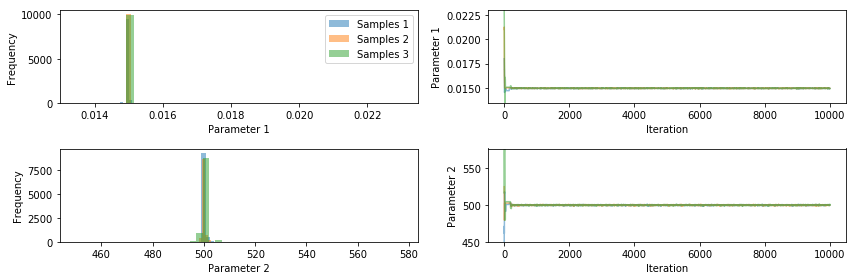

In [15]:
import pints.plot
pints.plot.trace(chains)
plt.show()

Based on this plot, it looks like the three chains become very similar after about 1000 iterations.
To be safe, we throw away the first 2000 samples and continue our analysis with the first chain.

In [16]:
chain = chains[0]
chain = chain[2000:]

We can also look for autocorrelation in the chains, using the [autocorrelation()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.autocorrelation) method. If everything went well, the samples in the chain should be relatively independent, so the autocorrelation should get quite low when the `lag` on the x-axis increases.

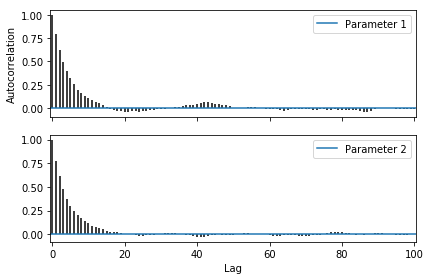

In [17]:
pints.plot.autocorrelation(chain)
plt.show()

Now we can inspect the inferred distribution by plotting histograms:

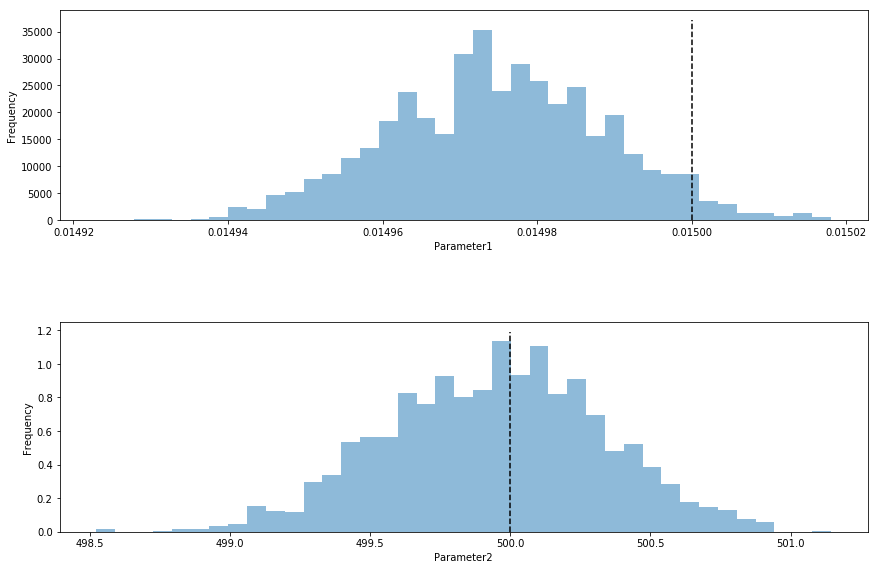

In [18]:
fig, axes = pints.plot.histogram([chain], ref_parameters=true_parameters)

# Show where the sample standard deviation of the generated noise is:
noise_sample_std = np.std(values - org_values)
#axes[-1].axvline(noise_sample_std, color='orange', label='Sample standard deviation of noise')
#axes[-1].legend()

fig.set_size_inches(14, 9)
plt.show()

Here we've analysed each parameter in isolation, but we can also look at correlations between parameters we found using the [pairwise()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.pairwise) plot.

To speed things up, we'll first apply some _thinning_ to the chain:

In [19]:
thinned_chain = chain[::10]

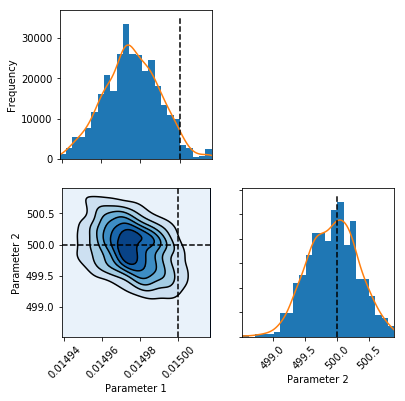

In [20]:
pints.plot.pairwise(thinned_chain, kde=True, ref_parameters=true_parameters)
plt.show()

Finally, we can look at the bit that really matters: The model predictions made from models with the parameters we found (a _posterior predictive check_). Thes can be plotted using the [series()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.series) method.

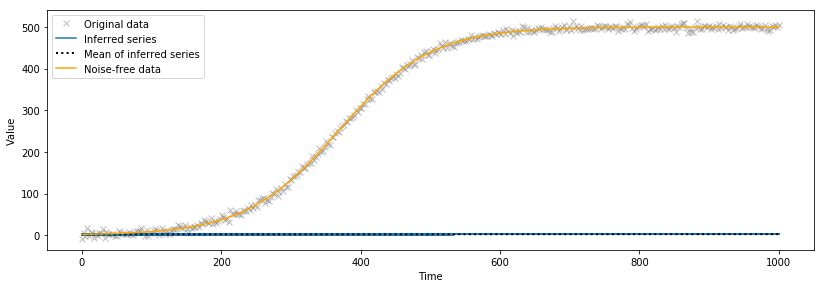

In [21]:
fig, axes = pints.plot.series(chain, problem)

# Customise the plot, and add the original, noise-free data
fig.set_size_inches(12,4.5)
plt.plot(times, org_values, c='orange', label='Noise-free data')
plt.legend()
plt.show()

-4559.968284151118
[0.69940307 1.04064108]
-1117892.0071707089


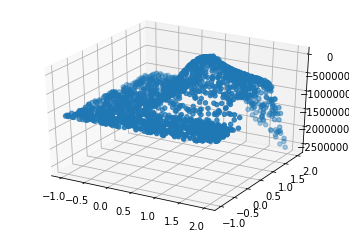

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

input_parameters = log_prior.sample(2000)
x = [p[0] for p in input_parameters]
y = [p[1] for p in input_parameters]
input_parameters[:5]

likelihoods = np.apply_along_axis(log_likelihood, 1, input_parameters)
likelihoods[:5]

print(max(likelihoods))
idx = list(likelihoods).index(max(likelihoods))
print(input_parameters[idx])
print(log_likelihood([0.015, 500]))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, list(likelihoods))
plt.show()

In [23]:
print(input_parameters[:5])

[[ 1.26543162  1.23365028]
 [-0.35776546  1.51829568]
 [ 0.64229096 -0.96890004]
 [-0.10819651  1.64981085]
 [ 0.60769444  0.55450176]]


In [24]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(input_parameters, likelihoods, test_size=0.3, random_state=0)

emu = pints.MultiLayerNN(problem, X_train, y_train, 
                          input_scaler=MinMaxScaler(), output_scaler=StandardScaler())
#emu.set_parameters(layers=6, neurons=64, hidden_activation='relu', activation='tanh', learning_rate=0.00001)
emu.set_parameters(layers=6, neurons=64, hidden_activation='relu', activation='linear', learning_rate=0.0001)
hist = emu.fit(epochs=100, batch_size=32, X_val=X_valid, y_val=y_valid, verbose=0)
#emu.summary()

In [25]:
emu([0.015, 500])

array([[-72004050.]], dtype=float32)

In [26]:
log_likelihood([0.015, 500])

-1117892.0071707089

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


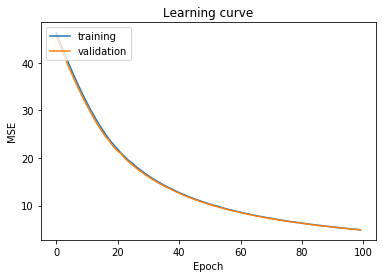

In [27]:
# summarize history for loss
print(hist.history.keys())
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Learning curve')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


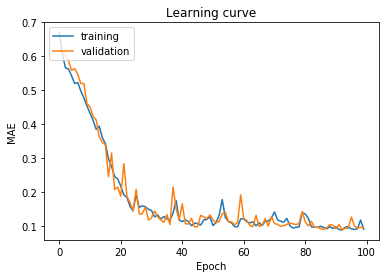

In [28]:
# summarize history for loss
print(hist.history.keys())
plt.plot(hist.history['mean_absolute_error'])
plt.plot(hist.history['val_mean_absolute_error'])
plt.title('Learning curve')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

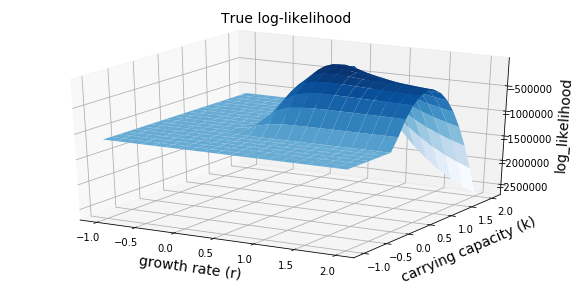

In [29]:
test_splits = 20 # number of splits along each axis
r_grid, k_grid, test_data = pints.generate_grid(bounds.lower(), 
                                                  bounds.upper(), 
                                                  test_splits)

model_prediction = pints.predict_grid(log_likelihood, test_data)

plt.figure(figsize = (10, 5))
ax = pints.plot.surface(r_grid, k_grid, model_prediction, title = "True log-likelihood",
                     x_label = "growth rate (r)",
                     y_label = "carrying capacity (k)")

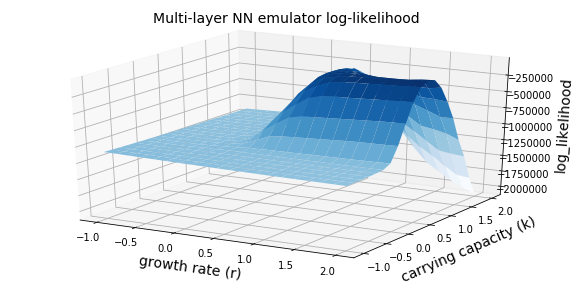

In [30]:
emu_prediction = pints.predict_grid(emu, test_data)

plt.figure(figsize = (10, 5))
ax = pints.plot.surface(r_grid, 
             k_grid, 
             emu_prediction, 
             title = "Multi-layer NN emulator log-likelihood",
             x_label = "growth rate (r)",
             y_label = "carrying capacity (k)")

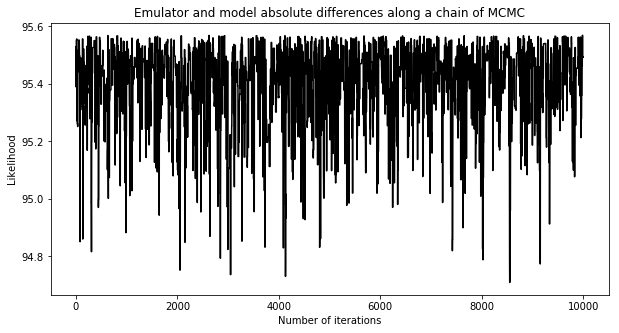

95.49267944440776

In [31]:
emu_prediction = np.apply_along_axis(emu, 1, chain_rescaled).flatten()
model_prediction = np.apply_along_axis(log_likelihood, 1, chain_rescaled).flatten()
diffs = (np.abs((model_prediction - emu_prediction) / model_prediction))

iters = np.linspace(0, 10000, len(chain_rescaled))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute differences along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood")
plt.plot(iters, diffs, color = "Black")
plt.show()

diffs[-1]

In [32]:
print(emu_prediction)

[-118453.8  -118453.8  -118453.8  ... -118398.61 -118398.61 -118398.61]


In [33]:
log_posterior_emu = pints.LogPosterior(emu, log_prior)

In [34]:
chains_emu = pints.mcmc_sample(log_posterior_emu, 3, xs)

Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
[0.99237659 0.88838237]
-85024.6171875
accepted


[1.28287299 0.97439629]
-128266.4296875


[1.3038419  1.23556268]
-312551.15625


1     6      0.5       0         0          0:00.0
[0.96588508 0.75562967]
-96598.8671875


[1.04970017 0.97398715]
-98591.9921875
accepted


[1.22018991 1.08756988]
-166943.3125
accepted


2     9      0.333     0.333     0.333      0:00.0
[0.99514764 0.92251271]
-87805.6171875


[1.01355201 1.00271092]
-104211.4921875


[1.20253184 1.05699973]
-144667.0
accepted


3     12     0.25      0.25      0.5        0:00.0
[0.86428085 0.95166187]
-98113.3671875


[0.89667208 1.08757029]
-113966.5546875


[1.21598083 1.19694864]
-248819.6875


[1.03735255 0.99127821]
-102588.0546875


[1.06354044 0.87350818]
-80636.5546875
accepted


[1.11073594 1.21419289]
-214370.25



-47633.42578125


[1.93879185 0.90941776]
-66532.2421875


[2.03046402 0.85217258]
-inf


[1.73702743 0.75398696]
-43355.23828125


[1.93527814 0.7666298 ]
-29462.8046875


[1.91287365 0.66173722]
-50071.86328125


[1.94636389 0.60786721]
-71917.3671875


[1.8785205  0.88860979]
-62120.73828125


[1.90773241 0.8107434 ]
-33537.73828125


[1.89208293 0.82744966]
-38792.30078125
accepted


[1.93887787 0.65815776]
-49985.92578125


[1.75739258 0.75316282]
-42142.11328125


[1.88330047 0.81494413]
-36286.98828125
accepted


[2.07642203 0.91712631]
-inf


[2.02263797 0.95128424]
-inf


[1.97844605 0.85534808]
-40380.36328125


[2.33119138 0.81510134]
-inf


[1.89070151 0.90332283]
-67662.8671875


[1.79958467 0.83293081]
-47303.55078125


[2.12170999 0.79127161]
-inf


[2.17654616 0.89270543]
-inf


[1.97209821 0.87972206]
-50737.80078125


[1.82895603 0.85671713]
-52857.92578125


[2.07416262 0.82903645]
-inf


[1.93224658 0.65683438]
-50882.92578125


[1.9587172  0.69532502]
-37282.800781



[2.11334593 0.58286454]
-inf


[1.82800099 0.81316861]
-40014.55078125


[1.86409432 0.7667329 ]
-34091.23828125


[1.97526916 0.79936574]
-27022.2421875


[1.94796703 0.81715595]
-31825.0546875


[2.06427206 0.97320853]
-inf


[2.03659535 0.78869117]
-inf


[2.00482592 0.88848477]
-inf


[1.90532577 0.82100419]
-36106.61328125


[1.94489566 0.79654234]
-28982.5546875


[1.97516941 0.78982967]
-26559.4296875


[1.97379933 0.69993393]
-35423.36328125


[1.8766131  0.74917303]
-34922.55078125


[2.10947702 0.98955723]
-inf


[1.92698173 0.72298465]
-34698.42578125


[2.05806199 0.63543875]
-inf


[2.03713934 0.68523416]
-inf


[2.0847601  0.75729991]
-inf


[2.01468394 0.72460374]
-inf


[1.98486678 0.57756818]
-87850.1796875


[1.80327718 0.82535366]
-44965.80078125


[1.97510574 0.87062068]
-46648.73828125


[1.96104641 0.72751498]
-31921.1796875


[1.91854012 0.88800041]
-58603.11328125


[2.04949254 0.80645577]
-inf


[1.83104935 0.7751978 ]
-36117.23828125


[2.05650964 0.83022598

[1.9990928  0.78919395]
-24894.5546875


[1.99832759 0.77729601]
-24848.9296875


[2.00030934 0.78604648]
-inf


[1.99936321 0.78914613]
-24874.9921875


[1.99890811 0.77700356]
-24816.0546875


[1.99957602 0.78606585]
-24791.6171875


[1.99958992 0.78926888]
-24862.1796875


[2.00021631 0.77693266]
-inf


[2.00037067 0.78574575]
-inf


[1.99877537 0.78911248]
-24914.8046875


[2.00051899 0.77679234]
-inf


[1.9991887 0.78606  ]
-24817.9921875


[1.9997614  0.78920919]
-24849.0546875
accepted


[1.99933948 0.77723708]
-24782.3671875


[1.99967823 0.78611198]
-24785.6796875


[1.99988993 0.78936565]
-24843.8046875
accepted


[1.99962137 0.77714035]
-24765.4296875


[1.99956815 0.78603101]
-24791.2421875


[1.99992805 0.78900319]
-24833.1171875
accepted


[2.00104172 0.77675064]
-inf


[2.00033072 0.78580236]
-inf


[2.00016637 0.78886262]
-inf


[2.00020291 0.77694917]
-inf


[1.99998483 0.78585724]
-24758.8671875
accepted


[1.99968306 0.78900563]
-24849.8046875


[2.00041443 0.7769554



[2.00002874 0.776882  ]
-inf


[1.99995775 0.78584552]
-24760.3671875


[1.99995627 0.78898681]
-24830.6796875


[1.99998123 0.776908  ]
-24745.7421875
accepted


[1.99999306 0.78582755]
-24757.4921875
accepted


[1.99997206 0.7889976 ]
-24829.8671875


[1.99993667 0.77690748]
-24748.8046875


[2.00001779 0.7858077 ]
-inf


[1.99996271 0.78898345]
-24830.1171875


[1.99995944 0.77691116]
-24747.2421875


[1.99998304 0.78583409]
-24758.4921875


[1.99999375 0.78899638]
-24828.4921875
accepted


[1.99997691 0.7769149 ]
-24746.1171875
accepted


[2.00000118 0.7858182 ]
-inf


360   1083   0.0914    0.0914    0.116      0:01.5
[2.00001392 0.78898739]
-inf


[1.99994459 0.77692073]
-24748.2421875


[1.99999917 0.78582201]
-24756.9921875
accepted


[2.00001574 0.78899113]
-inf


[1.99997684 0.7769157 ]
-24745.9921875
accepted


[2.00000287 0.78582368]
-inf


[1.99998936 0.78900229]
-24828.8671875
accepted


[1.99995703 0.77691612]
-24747.2421875


[2.00001166 0.78580801]
-inf


[1.99999972



[2.00002073 0.78579136]
-inf


[1.99998002 0.78899351]
-24829.3671875
accepted


[1.99998595 0.77693748]
-24744.7421875
accepted


[1.99999081 0.78580302]
-24757.3046875
accepted


[1.99998803 0.78899483]
-24828.8046875
accepted


[1.99999452 0.77693143]
-24744.4921875
accepted


[1.99999038 0.78580401]
-24757.3046875
accepted


[1.9999651  0.78898874]
-24830.2421875
accepted


[1.99999519 0.77693662]
-24744.3671875
accepted


[1.99999741 0.78580832]
-24756.9296875
accepted


[1.99993937 0.78898219]
-24831.7421875


[1.99998954 0.77693806]
-24744.6796875
accepted


[1.99997641 0.78580245]
-24758.2421875
accepted


440   1323   0.168     0.168     0.222      0:01.9
[1.99996601 0.78898638]
-24830.0546875
accepted


[1.99997854 0.77693752]
-24745.3671875
accepted


[1.99997232 0.78580636]
-24758.6796875
accepted


[1.99996403 0.78898389]
-24830.1171875
accepted


[1.99997861 0.77693703]
-24745.5546875
accepted


[1.99995061 0.78583594]
-24760.5546875


[1.99996889 0.78897916]
-24829.617

[1.99999234 0.78897168]
-24827.9296875
accepted


[1.99999423 0.77692988]
-24744.6796875


[1.9999907  0.78579264]
-24756.9921875
accepted


[1.99998147 0.78896619]
-24828.5546875


[2.00000077 0.77692713]
-inf


[1.99997527 0.78581523]
-24758.5546875


[1.99999371 0.78896535]
-24827.7421875
accepted


[1.9999953  0.77692309]
-24744.5546875
accepted


[2.0000036 0.7857864]
-inf


[1.99998676 0.78895455]
-24827.9296875


[1.99999806 0.77691651]
-24744.4921875
accepted


[1.99998446 0.78579163]
-24757.4296875


[1.99999789 0.78896581]
-24827.4296875
accepted


[1.99999327 0.77690699]
-24744.9296875
accepted


[1.99999763 0.78580335]
-24756.8046875
accepted


520   1563   0.232     0.228     0.274      0:02.2
[2.0000091  0.78894189]
-inf


[1.99999735 0.77691411]
-24744.7421875
accepted


[1.99998497 0.78579491]
-24757.4921875


[1.99999493 0.78898386]
-24828.1171875
accepted


[1.99999502 0.77690997]
-24744.9296875
accepted


[1.99998217 0.78581215]
-24758.0546875


[1.99998869 0.7889919



[1.99981085 0.78035849]
-24702.4921875


[1.99984987 0.78857364]
-24828.8671875
accepted


[1.99966575 0.7807011 ]
-24707.5546875


[1.9999273  0.78488186]
-24741.1171875


[1.99989278 0.7886649 ]
-24827.9921875
accepted


[1.99913647 0.78678416]
-24837.7421875


[1.99986642 0.78199488]
-24680.7421875
accepted


[1.99993482 0.78873204]
-24826.4921875
accepted


[1.99983193 0.77885861]
-24722.8671875


[1.99990444 0.7832051 ]
-24705.1171875


[1.99990193 0.78862077]
-24826.4921875
accepted


[1.99944176 0.78332877]
-24739.6796875


[1.9998825  0.78271653]
-24695.6796875


[1.99998579 0.78891447]
-24826.9296875
accepted


[1.99939359 0.78377744]
-24752.9921875


[1.99983683 0.78075934]
-24694.9921875


[2.00001075 0.78901216]
-inf


[2.00020866 0.77449615]
-inf


[1.99984406 0.78130957]
-24686.6796875


[2.00001105 0.78899054]
-inf


[1.99967495 0.78064097]
-24707.4296875


[1.99993043 0.78405364]
-24722.3671875


600   1803   0.288     0.285     0.306      0:02.6
[2.00004836 0.7890726

[1.99871363 0.78443732]
-24814.4296875


[1.99966567 0.78063693]
-24708.3046875


[1.99990257 0.78287057]
-24697.8671875


[1.99904979 0.78547116]
-24814.4296875


[1.99946199 0.78289172]
-24728.5546875


[1.99988087 0.78229078]
-24686.4921875


[1.99620589 0.77522342]
-25035.8671875


[1.99945562 0.78299018]
-24731.1796875


[1.99982387 0.7802147 ]
-24703.8671875


[1.99871085 0.78421007]
-24809.5546875


[1.99986184 0.77840579]
-24727.1796875


[1.99988789 0.78237032]
-24687.8671875


[1.99841427 0.7829982 ]
-24802.9296875
accepted


[1.99974468 0.77979909]
-24715.1796875


[1.99990711 0.78264667]
-24692.3671875


[1.99746074 0.77961108]
-24871.2421875


[1.99948165 0.78272565]
-24723.5546875


[1.99981423 0.77960193]
-24713.2421875


[1.99825494 0.78254053]
-24803.4921875
accepted


[1.99960655 0.78133551]
-24702.4296875


[1.99986645 0.78092861]
-24690.5546875


[1.99990561 0.78855135]
-24824.6171875


[1.99965043 0.7808133 ]
-24706.8671875


[1.99990003 0.78288831]
-24698.4921875


[1.99988551 0.78361349]
-24715.7421875


[1.99950625 0.78245473]
-24715.8046875


[1.99993594 0.78152215]
-24677.4296875


[1.99976028 0.78449426]
-24743.9921875


[1.99961398 0.78128435]
-24702.4921875


[1.99994251 0.7816854 ]
-24674.6171875
accepted


[2.00054271 0.78578675]
-inf


[1.99967556 0.78054645]
-24708.9921875


[1.99992091 0.78196767]
-24676.3046875
accepted


[1.99972699 0.78115737]
-24696.6171875


[1.99961912 0.78119202]
-24703.4921875


[1.99995326 0.78239786]
-24683.9296875


[2.00039856 0.78157618]
-inf


[1.99951084 0.78238245]
-24713.8046875


[1.99987865 0.78244015]
-24690.0546875


[1.99939876 0.78342792]
-24744.8671875


[1.99953142 0.78216482]
-24707.7421875


[1.99992191 0.78184988]
-24673.8046875
accepted


[2.00075448 0.78173668]
-inf


[1.9995406  0.78209455]
-24705.4921875


[1.9999272  0.78193605]
-24675.4296875


[1.99790456 0.78222071]
-24820.4921875


[1.99954019 0.78209542]
-24705.4296875


[1.99992398 0.78190688]
-24674.9296875


[2.00092763 0.78297

[1.99962552 0.78112842]
-24703.9921875


[1.99994317 0.78171755]
-24674.1796875
accepted


[2.00022605 0.78100945]
-inf


[1.99957524 0.78169165]
-24699.4296875
accepted


[1.99995393 0.78144216]
-24677.4296875


820   2463   0.251     0.261     0.261      0:03.7
[2.00077056 0.78189912]
-inf


[1.99953767 0.78213422]
-24706.5546875


[1.99995261 0.7817757 ]
-24672.7421875
accepted


[2.00005187 0.78150577]
-inf


[1.9995363  0.78213823]
-24706.6796875


[1.99988905 0.78179151]
-24676.5546875


[2.0000405  0.78220569]
-inf


[1.99955353 0.78193125]
-24700.8671875


[1.9999795  0.78169412]
-24672.0546875
accepted


[2.00048654 0.78183563]
-inf


[1.99959916 0.78140503]
-24701.8671875


[2.00000839 0.78181881]
-inf


[1.99983567 0.7811887 ]
-24689.1171875


[1.99956387 0.78179763]
-24698.3671875
accepted


[1.99991029 0.78156948]
-24678.4296875


[1.99994136 0.78235461]
-24683.8046875


[1.99961053 0.78130561]
-24702.4296875


[2.00002478 0.78155151]
-inf


[1.99977439 0.78111694]
-24694.

[1.99990942 0.7821776 ]
-24682.1796875


[1.99956191 0.78180264]
-24698.5546875
accepted


[1.99997062 0.78165495]
-24673.1171875
accepted


[2.00023776 0.78166165]
-inf


[1.99957586 0.78158061]
-24700.9921875


[1.99993636 0.78164545]
-24675.6171875


[1.99994392 0.78236629]
-24683.9296875


[1.99955507 0.78183082]
-24698.7421875
accepted


[1.99995378 0.78157134]
-24675.6171875


[1.99989197 0.78188229]
-24676.4921875


[1.9995308  0.78210561]
-24706.3046875


[1.99998005 0.7817341 ]
-24671.3671875
accepted


[1.99994256 0.78139526]
-24678.8046875


[1.99957215 0.78164354]
-24700.1171875


[1.99996725 0.78188599]
-24671.3671875
accepted


[2.00031364 0.78151761]
-inf


[1.99955053 0.7817963 ]
-24699.2421875


[1.99999635 0.78190221]
-24669.8046875
accepted


[2.00023448 0.78212403]
-inf


[1.99956639 0.78171645]
-24699.6171875
accepted


[1.99994955 0.78171153]
-24673.6796875


[2.00005629 0.78141137]
-inf


[1.99955208 0.78181982]
-24699.0546875
accepted


[2.00001814 0.78188127]
-

[2.00007633 0.78212841]
-inf


[1.99996427 0.78088565]
-24684.4921875
accepted


[1.9999854  0.78182587]
-24669.7421875


[1.99995472 0.7820946 ]
-24676.9296875


[2.00011005 0.78040842]
-inf


[1.99996798 0.78191014]
-24671.8671875


[1.99998173 0.78191032]
-24671.0546875
accepted


[1.99996798 0.78094306]
-24683.6171875
accepted


[2.00001452 0.78182757]
-inf


[1.99997644 0.78201309]
-24673.6796875


[2.00000562 0.78084987]
-inf


[2.00000313 0.78197051]
-inf


[1.99993926 0.78212933]
-24678.8671875


[2.00028967 0.78018925]
-inf


[2.00002737 0.78180352]
-inf


[1.99998368 0.7819008 ]
-24670.6171875
accepted


[1.99955207 0.78205173]
-24703.6796875


[2.00001342 0.78194248]
-inf


[1.99999412 0.78194104]
-24670.8671875
accepted


[2.00025528 0.7800816 ]
-inf


[2.00002109 0.78183087]
-inf


[2.00011317 0.78183008]
-inf


[1.99985217 0.78125064]
-24687.1171875


[1.99998158 0.7818364 ]
-24669.9296875
accepted


[1.99995103 0.7817345 ]
-24673.4921875


[1.99964037 0.78149117]
-24697.

[1.9999533  0.78195454]
-24673.8671875


[2.00023581 0.7818229 ]
-inf


[1.99999461 0.78180856]
-24669.4296875
accepted


[1.99993366 0.78184557]
-24672.9296875


[1.99994233 0.78180675]
-24672.9921875


[2.00000219 0.781767  ]
-inf


[1.99998653 0.78186688]
-24669.7421875


[1.99992316 0.78197879]
-24676.4921875


[2.00002368 0.78170063]
-inf


[2.00005511 0.78194235]
-inf


[2.00010861 0.7811442 ]
-inf


[1.99999031 0.78188137]
-24669.7421875
accepted


[2.00006872 0.78198351]
-inf


[1.99982477 0.78142335]
-24686.3046875


[1.99998817 0.78195195]
-24671.3671875


[1.99997873 0.78211008]
-24675.6171875


[2.00001284 0.78117326]
-inf


[1.99998894 0.78183545]
-24669.5546875
accepted


[1.99995541 0.78183871]
-24671.6796875


[1.99996098 0.78156662]
-24675.1171875


[1.99999092 0.78186506]
-24669.3671875
accepted


[2.00000044 0.78189783]
-inf


[1.99990648 0.78143604]
-24680.6171875


[1.99996959 0.78188978]
-24671.4296875


[1.99993917 0.7818345 ]
-24672.7421875


[1.99973913 0.78230

[1.99999295 0.78190675]
-24670.1171875


[1.99995478 0.78189008]
-24672.3046875


[1.99999053 0.78176459]
-24670.3046875
accepted


[1.999999   0.78185745]
-24668.5546875
accepted


[2.00004263 0.78217984]
-inf


[1.99999194 0.78164292]
-24671.8671875


1160  3483   0.213609  0.248062  0.286      0:05.2
[2.00001472 0.78187243]
-inf


[1.99994558 0.78163532]
-24675.1171875


[1.99998702 0.78175397]
-24670.6171875


[2.0000058  0.78183038]
-inf


[1.99991325 0.78178724]
-24675.2421875


[1.9999634  0.78187567]
-24671.5546875


[1.9999901  0.78186692]
-24669.5546875


[1.99996237 0.78181567]
-24671.4296875


[1.99999909 0.78158797]
-24672.2421875
accepted


[1.99999883 0.78179376]
-24669.3671875


[1.99996782 0.78161798]
-24673.8671875


[2.00000308 0.78165739]
-inf


[1.99999876 0.7818106 ]
-24669.0546875
accepted


[1.99988626 0.78159832]
-24679.6796875


[1.99998914 0.78159706]
-24672.9296875
accepted


[1.99998055 0.78177357]
-24670.8671875


[2.00012353 0.78203603]
-inf


[2.00000788

[1.9999835  0.78183991]
-24669.5546875
accepted


[1.99998829 0.78199875]
-24672.4921875


[1.9999499 0.781954 ]
-24674.0546875
accepted


[1.99997938 0.78186211]
-24670.1171875


[1.99999755 0.78192262]
-24670.1171875
accepted


[1.99998397 0.78180067]
-24670.1171875
accepted


[1.999961   0.78180446]
-24671.5546875


[1.99997998 0.78189081]
-24670.6796875
accepted


[1.99997201 0.7820803 ]
-24675.4921875


1240  3723   0.224     0.245     0.288      0:05.6
[1.9999532  0.78186862]
-24672.0546875


[1.99999969 0.78182174]
-24668.8671875
accepted


[1.99996831 0.78182838]
-24670.8046875


[1.9999864  0.78183648]
-24669.4296875
accepted


[2.00001243 0.78172398]
-inf


[1.99997161 0.78173212]
-24671.8671875


[1.99998383 0.78188415]
-24670.4296875


[1.99999361 0.781738  ]
-24670.4296875


[1.99998434 0.78176778]
-24670.6171875
accepted


[1.99997646 0.78186285]
-24670.1171875
accepted


[2.00002869 0.78179358]
-inf


[1.99999256 0.78169855]
-24670.9921875


[1.99997508 0.78185287]
-2467

[1.99999269 0.78183584]
-24669.0546875
accepted


[1.9999944  0.78176325]
-24669.9921875
accepted


[1.99998104 0.78191022]
-24670.9921875


1320  3963   0.24      0.244     0.282      0:06.0
[1.99998385 0.78191147]
-24670.9921875


[2.00001557 0.78175743]
-inf


[1.99999652 0.78198819]
-24671.7421875


[2.00000549 0.78185511]
-inf


[1.99996561 0.78168867]
-24672.9921875


[1.99999631 0.78169126]
-24670.9921875


[1.99999399 0.78177268]
-24669.9921875
accepted


[1.99993737 0.78184095]
-24672.9296875


[1.99998216 0.78177028]
-24670.8671875
accepted


[1.99999774 0.78187218]
-24669.1171875
accepted


[1.9999491 0.7817064]
-24673.9921875


[1.99998032 0.78173218]
-24671.2421875


[1.99999376 0.7819463 ]
-24670.8046875


[2.00004069 0.78168655]
-inf


[1.99998375 0.78171125]
-24671.5546875
accepted


[1.99998429 0.78189898]
-24670.4921875


[2.00000961 0.78175569]
-inf


[2.00000139 0.78161486]
-inf


[2.00000027 0.78180924]
-inf


[2.00000575 0.7817004 ]
-inf


[1.99999519 0.7816847 ]


[1.99996975 0.78169615]
-24672.6171875
accepted


[1.99999805 0.78166134]
-24671.1796875
accepted


[1.99997999 0.78204565]
-24674.0546875


[2.00000723 0.78173781]
-inf


[1.9999945  0.78164964]
-24671.6796875
accepted


[1.99999442 0.78193825]
-24670.6171875
accepted


[1.99997    0.78200118]
-24673.8046875


1400  4203   0.253     0.248394  0.293      0:06.4
[2.00002569 0.78161864]
-inf


[1.99999695 0.78192771]
-24670.3046875
accepted


[1.99998277 0.78165578]
-24672.2421875
accepted


[1.99997347 0.78164575]
-24673.1171875


[1.9999892  0.78196896]
-24671.8671875


[1.99998337 0.781876  ]
-24670.1171875
accepted


[2.00000055 0.78133985]
-inf


[1.99998781 0.78183708]
-24669.3671875
accepted


[1.99994545 0.78168116]
-24674.5546875


[2.00000612 0.78161087]
-inf


[1.99997631 0.78178314]
-24671.0546875


[2.00002677 0.78203897]
-inf


[1.99998407 0.78175724]
-24670.8046875
accepted


[1.99998502 0.78188948]
-24670.4921875


[1.99996289 0.78166479]
-24673.5546875


[1.99999251 0.78

accepted


[1.99997559 0.78190249]
-24671.1796875
accepted


[1.99997425 0.78167115]
-24672.7421875


[1.99996688 0.78188927]
-24671.5546875


[1.9999898  0.78176081]
-24670.3046875
accepted


[2.00001272 0.78204496]
-inf


[1.99995296 0.7819813 ]
-24674.5546875


[2.00000721 0.78186042]
-inf


[1.99998928 0.7819714 ]
-24671.7421875


[1.9999724  0.78189798]
-24671.4296875


[2.00000642 0.781739  ]
-inf


[1.99998618 0.78171504]
-24671.3671875


[2.00000395 0.78177773]
-inf


[1.99995301 0.78172783]
-24673.4921875


[1.99999001 0.7819473 ]
-24671.1796875


[1.99998896 0.78154624]
-24673.5546875


[1.99998858 0.78176774]
-24670.4296875
accepted


[2.00003056 0.7818481 ]
-inf


[1.99998715 0.78182809]
-24669.7421875
accepted


[1.99994832 0.78170019]
-24674.0546875


[2.00003442 0.78191553]
-inf


[1.99997338 0.78196095]
-24672.6171875


[1.99993024 0.78177791]
-24674.1796875


[1.99999962 0.78187266]
-24668.9296875
accepted


1480  4443   0.259     0.26      0.29237    0:06.8
[1.9999827

[1.99999768 0.78204649]
-24672.9296875


[1.99999762 0.78190721]
-24669.7421875
accepted


[1.99999596 0.78189635]
-24669.6171875
accepted


[1.99998926 0.78183514]
-24669.4296875
accepted


[2.00001225 0.7819367 ]
-inf


[1.99998429 0.7819392 ]
-24671.3671875


[1.99999336 0.78181923]
-24669.2421875
accepted


[1.99997481 0.78196354]
-24672.6171875


[1.9999754  0.78175241]
-24671.3671875


[2.00000517 0.78169156]
-inf


[2.00001149 0.78189904]
-inf


[2.00000549 0.78192875]
-inf


[1.99999569 0.78183837]
-24668.6796875
accepted


[1.99994949 0.78184444]
-24671.9296875


[1.99999051 0.78191749]
-24670.4921875


[2.00000332 0.78180644]
-inf


[2.00000536 0.78204288]
-inf


[1.99998224 0.78186137]
-24669.8046875


[1.99998838 0.78181355]
-24669.7421875


[2.00001108 0.78197453]
-inf


[1.99998298 0.78194431]
-24671.6796875


[2.00001526 0.78181189]
-inf


[2.00001054 0.78187525]
-inf


[2.00000364 0.78199356]
-inf


[2.00000254 0.78181835]
-inf


[2.00001743 0.78202612]
-inf


[1.999995

[2.00001751 0.78189406]
-inf


[1.99999708 0.78190408]
-24669.8046875


[1.99998856 0.78188968]
-24670.1796875


[2.00004716 0.7817013 ]
-inf


[1.99996974 0.78182876]
-24670.8671875
accepted


[2.00001631 0.78165473]
-inf


[1.99999291 0.78192507]
-24670.4296875
accepted


[1.99995748 0.78168833]
-24673.5546875


[2.00001659 0.78194626]
-inf


[2.00000558 0.78187485]
-inf


[1.99998072 0.7816851 ]
-24672.0546875


[2.00000864 0.78168773]
-inf


[2.0000112  0.78197229]
-inf


[1.99997247 0.78159694]
-24673.9921875


[2.00001589 0.78186529]
-inf


[1.99999563 0.78190055]
-24669.9296875
accepted


[1.99997322 0.7817472 ]
-24671.5546875


[2.00000383 0.78185491]
-inf


[1.99998755 0.7819628 ]
-24671.7421875


[1.99995525 0.78194282]
-24673.4921875
accepted


[1.99994876 0.7818516 ]
-24671.9296875
accepted


[1.99997521 0.78189323]
-24670.8671875


1640  4923   0.272     0.268     0.291      0:07.5
[1.99995486 0.78202916]
-24675.6171875


[1.99998913 0.78179807]
-24669.9921875
accepted


[

accepted


[1.99995979 0.78168567]
-24673.3671875


[2.00001598 0.78153447]
-inf


[1.99998862 0.78192038]
-24670.6796875
accepted


[1.99999111 0.78182272]
-24669.3671875
accepted


[1.9999883  0.78177741]
-24670.3046875
accepted


[1.99999563 0.78190844]
-24669.9921875
accepted


[1.99999082 0.78187518]
-24669.5546875
accepted


[1.99998109 0.78190439]
-24670.9921875
accepted


[1.99999251 0.78219992]
-24676.6796875


[1.99998349 0.78183448]
-24669.8046875
accepted


[1.99998103 0.78196223]
-24672.0546875


[2.00001794 0.78192585]
-inf


[1.99999182 0.78180762]
-24669.6171875
accepted


[1.9999644  0.78184657]
-24670.9921875
accepted


[2.00004978 0.78202452]
-inf


[1.99996332 0.78173535]
-24672.4296875


[2.00000283 0.7818076 ]
-inf


[1.99998673 0.78189015]
-24670.3046875
accepted


[1.99998532 0.78182815]
-24669.8046875
accepted


[1.99995079 0.78204409]
-24675.9921875


[1.99997886 0.78182731]
-24670.1171875
accepted


[1.99998549 0.78178166]
-24670.4296875


[1.99996586 0.78192

[1.9999474  0.78198215]
-24675.1171875


[1.99998858 0.78190149]
-24670.4296875
accepted


[1.99998925 0.78176346]
-24670.3046875


[1.99995997 0.78190736]
-24672.4921875
accepted


[1.99997691 0.78186091]
-24670.1171875
accepted


[1.99997515 0.78174916]
-24671.5546875


[1.99993813 0.7818871 ]
-24673.3046875


[1.99995316 0.78191366]
-24672.9296875


[1.99998463 0.78170801]
-24671.4296875


[1.99999597 0.78186551]
-24669.0546875
accepted


[1.99998281 0.78182702]
-24669.9296875
accepted


[1.99994628 0.7819689 ]
-24674.9296875


[1.99998897 0.78198736]
-24672.1171875


[1.999991   0.78188381]
-24669.7421875
accepted


[1.99998032 0.78183927]
-24669.9296875
accepted


1800  5403   0.273     0.269     0.295      0:08.2
[2.00000095 0.78187806]
-inf


[1.99999092 0.78189102]
-24669.9921875
accepted


[1.99999677 0.7817474 ]
-24670.1796875


[2.0000056  0.78174181]
-inf


[2.00000457 0.78184493]
-inf


[1.99995986 0.78193641]
-24672.9921875


[2.00001947 0.78188083]
-inf


[1.99999636 0.7

[1.99996266 0.78195629]
-24673.3046875


[2.0000064  0.78187937]
-inf


[1.99997183 0.78181886]
-24670.8046875
accepted


[2.00002703 0.78189797]
-inf


[2.00000743 0.78195144]
-inf


[1.99997121 0.78185568]
-24670.4296875
accepted


[1.99998763 0.78186534]
-24669.6171875
accepted


[2.00000006 0.78175267]
-inf


[1.99996778 0.78167925]
-24672.9921875


[1.99996653 0.78211318]
-24676.4921875


[1.9999671 0.7817409]
-24672.1171875


[1.9999648  0.78184716]
-24670.8671875


[1.99994734 0.78167213]
-24674.5546875


[1.99999827 0.78174277]
-24669.9921875


[1.99998629 0.78188937]
-24670.3046875
accepted


[1.99993957 0.78181749]
-24672.9921875


[1.99999369 0.78169444]
-24671.1796875
accepted


[1.99999534 0.7817831 ]
-24669.7421875
accepted


1880  5643   0.28      0.275     0.297      0:08.6
[1.99996939 0.78184943]
-24670.4296875


[2.00001342 0.78158215]
-inf


[1.99997256 0.78173519]
-24672.0546875


[1.99997903 0.78186172]
-24670.1171875


[1.99997405 0.78160779]
-24673.6796875


[2.0

[1.99998587 0.78196922]
-24672.0546875


[1.99998624 0.78195444]
-24671.7421875
accepted


[1.99998285 0.78176003]
-24670.9921875


[1.99999157 0.78183647]
-24669.1171875
accepted


[1.99996908 0.78181558]
-24670.9921875
accepted


[1.99999449 0.78183852]
-24668.8671875
accepted


[2.00000459 0.78188692]
-inf


[1.99998497 0.78166078]
-24672.3046875
accepted


[2.00001611 0.78190273]
-inf


[1.99995242 0.78196165]
-24674.3671875


[1.99999204 0.78152457]
-24673.6796875


[1.9999993  0.78198431]
-24671.3671875


[1.99998363 0.78180799]
-24670.1171875


[2.00001545 0.78155603]
-inf


[2.00004297 0.78196509]
-inf


[2.00000079 0.7819839 ]
-inf


[1.99996217 0.78168248]
-24673.3046875


[1.99999534 0.78182177]
-24669.1171875
accepted


[1.99999994 0.7817677 ]
-24669.5546875
accepted


[2.0000103  0.78154506]
-inf


[2.00000929 0.78189983]
-inf


[2.00003614 0.78178069]
-inf


[2.00000257 0.78156565]
-inf


[1.99994984 0.78171839]
-24673.5546875


[2.0000113  0.78184803]
-inf


[2.00001419 



[1.99994773 0.7816863 ]
-24674.1796875
accepted


[1.99997093 0.78182506]
-24670.6796875
accepted


[1.99996712 0.78204689]
-24675.0546875


[1.99996724 0.78181819]
-24671.2421875
accepted


[1.99996664 0.78196758]
-24672.9921875


[1.99997831 0.78168903]
-24672.0546875


[2.00002112 0.78193219]
-inf


[1.99994601 0.78183659]
-24672.1171875


[1.99997733 0.78173569]
-24671.6796875


[1.99998989 0.78175762]
-24670.3046875
accepted


[1.99998917 0.78198786]
-24672.1171875


[1.99997791 0.78227463]
-24679.2421875


[1.99999744 0.78182735]
-24668.9296875
accepted


[1.99998336 0.78187912]
-24670.1796875
accepted


[2.00001076 0.78169272]
-inf


[2.0000453  0.78217871]
-inf


[1.99994662 0.78200518]
-24675.6171875


[1.99997955 0.78184763]
-24669.7421875
accepted


[1.99996845 0.7817335 ]
-24672.1171875


[1.99997091 0.78195318]
-24672.7421875


[1.99997269 0.78174013]
-24671.7421875


[1.99997291 0.78174238]
-24671.7421875


[1.99998356 0.78201379]
-24673.3046875


[1.99999598 0.78193815



[1.99999534 0.78184993]
-24668.6796875
accepted


[1.99997855 0.78183895]
-24669.9921875
accepted


[1.99998411 0.78195002]
-24671.8671875


[1.99995124 0.78181138]
-24672.2421875


[1.99998712 0.78184493]
-24669.4296875
accepted


[1.9999778  0.78213198]
-24676.3046875


[2.00000636 0.78199602]
-inf


[1.99999658 0.78192468]
-24670.1171875


[1.9999733  0.78196653]
-24672.8046875


[1.99999631 0.7816634 ]
-24671.2421875


[1.99997999 0.78173936]
-24671.3671875
accepted


[1.99997993 0.78180302]
-24670.4296875
accepted


[1.99996771 0.7817584 ]
-24671.8671875


[1.9999846  0.78178724]
-24670.4296875
accepted


[1.99997406 0.78187809]
-24670.8046875


[1.9999736  0.78174797]
-24671.6796875


[1.99999262 0.78190508]
-24670.1171875
accepted


[1.99998614 0.78196889]
-24671.8671875


[1.99999265 0.7817236 ]
-24670.4921875


2140  6423   0.275     0.278     0.287      0:09.8
[1.99999894 0.78178332]
-24669.5546875
accepted


[1.99994977 0.78199249]
-24675.0546875


[1.99996671 0.78194671]


[2.00000084 0.78172731]
-inf


[1.99996232 0.78184431]
-24671.1796875


[1.99998551 0.78193929]
-24671.2421875
accepted


[2.00000108 0.78199451]
-inf


[1.99995297 0.7818125 ]
-24672.1171875


[1.99996002 0.78197793]
-24673.8671875


[1.99997639 0.78174104]
-24671.6796875


[2.00001701 0.78194101]
-inf


[1.99999792 0.781858  ]
-24668.7421875
accepted


[1.99999095 0.78172861]
-24670.6796875


[2.00000767 0.78191935]
-inf


[1.99999826 0.78157402]
-24672.4296875


[2.00001918 0.78201161]
-inf


[2.00004769 0.78171854]
-inf


[2.00000788 0.78189691]
-inf


[1.99997268 0.78172678]
-24671.9296875
accepted


[1.99998491 0.78168624]
-24671.7421875


[2.00002262 0.78187877]
-inf


[1.99995084 0.78172072]
-24673.3671875


[1.99995723 0.78180057]
-24672.0546875


[1.99995586 0.78184311]
-24671.4296875


[1.99999187 0.78172514]
-24670.6796875
accepted


[1.99996361 0.78201881]
-24674.6171875


[1.99999209 0.78186967]
-24669.3671875


[1.99998953 0.78154955]
-24673.4921875


[1.99999036 0.78177

[1.99992144 0.78167247]
-24676.1796875


[1.99997145 0.7818509 ]
-24670.4296875
accepted


[2.00000597 0.78161972]
-inf


[1.9999618  0.78170086]
-24673.1796875
accepted


[1.99996164 0.78185551]
-24671.1796875


[1.99998432 0.78192511]
-24671.0546875


[1.99998687 0.7817546 ]
-24670.6171875
accepted


[1.99995375 0.78202297]
-24675.4921875


[2.00002134 0.78219374]
-inf


[1.99994892 0.78172265]
-24673.8046875


[1.99995175 0.781735  ]
-24673.3046875


[2.00003904 0.7821308 ]
-inf


[1.99999268 0.7819295 ]
-24670.6171875
accepted


[1.99998157 0.78191689]
-24670.9921875


[2.00001386 0.78135516]
-inf


[1.99996444 0.78210849]
-24676.5546875


[1.99999709 0.78178557]
-24669.7421875
accepted


[1.99997613 0.78162473]
-24673.1796875


[1.99997556 0.78181826]
-24670.6171875
accepted


[1.99999914 0.78192779]
-24670.1796875


[2.00000003 0.78163741]
-inf


[1.99994771 0.7817807 ]
-24672.9296875


[1.99997469 0.78196025]
-24672.7421875


[1.99999415 0.78176147]
-24669.9921875
accepted


[1.

[1.99999244 0.78182406]
-24669.3671875
accepted


[2.00000321 0.78176996]
-inf


[1.99995657 0.78158501]
-24675.1171875


[1.99998065 0.78189392]
-24670.6171875


[1.99999109 0.78171787]
-24670.8046875


[1.99999774 0.78126914]
-24676.9296875


[1.99999463 0.78171864]
-24670.6171875
accepted


[2.00000678 0.78206807]
-inf


[1.99997954 0.78196519]
-24672.2421875


[2.0000149  0.78168245]
-inf


[2.00000246 0.78185463]
-inf


[1.9999955  0.78135759]
-24675.9921875


[1.99995874 0.78163647]
-24674.1796875


[1.99998772 0.78200587]
-24672.7421875


[1.99994969 0.78163921]
-24674.7421875


2380  7143   0.279     0.273     0.28       0:10.9
[1.9999901  0.78152247]
-24673.8671875


[1.99999742 0.7819172 ]
-24669.9921875


[1.99997143 0.78169533]
-24672.4921875
accepted


[1.99997895 0.7816338 ]
-24672.9921875


[1.99999908 0.78175848]
-24669.6171875


[2.00000148 0.78154175]
-inf


[1.99995663 0.78175512]
-24672.6171875


[1.99999522 0.78195453]
-24671.0546875


[1.99999305 0.78181123]
-2466

[1.999993   0.78163176]
-24671.9296875


[2.00002273 0.78175816]
-inf


[2.00001519 0.78201188]
-inf


[1.9999981  0.78182405]
-24668.7421875
accepted


[1.9999763 0.7817   ]
-24672.2421875


[2.00002207 0.78156984]
-inf


[1.99996001 0.78160342]
-24674.6171875


[1.99998657 0.78201237]
-24672.8046875


[2.00000418 0.78168599]
-inf


[2.00000023 0.78158185]
-inf


[2.00000965 0.78181311]
-inf


[1.99997287 0.78222931]
-24678.9921875


2460  7383   0.279     0.274     0.281      0:11.2
[2.00001851 0.78171666]
-inf


[1.99998399 0.78177093]
-24670.6796875
accepted


[2.0000095  0.78192096]
-inf


[1.99995372 0.78162827]
-24674.7421875


[1.99998469 0.78186741]
-24669.8046875
accepted


[1.99997503 0.78194375]
-24672.2421875


[1.9999873  0.78205645]
-24673.8671875


[1.99998088 0.78217413]
-24676.8671875


[1.99992037 0.78169133]
-24676.1171875


[2.00000675 0.78184473]
-inf


[1.99996485 0.78185916]
-24670.8671875


[1.99999772 0.78201823]
-24672.2421875


[1.99997868 0.78174648]
-24671

[1.99998094 0.78182755]
-24669.9296875
accepted


[1.99999951 0.7816563 ]
-24671.1796875


[2.0000039  0.78187855]
-inf


[2.00000894 0.78179712]
-inf


[2.00000608 0.78180797]
-inf


[1.99998326 0.78187148]
-24669.9921875
accepted


[2.00002781 0.781712  ]
-inf


[1.99999442 0.7819243 ]
-24670.4296875


[1.99996564 0.78194083]
-24672.8046875


[1.9999794  0.78168855]
-24672.2421875


[1.99997067 0.78180903]
-24670.9921875


[2.00001599 0.78194303]
-inf


[2.00000004 0.78181168]
-inf


[1.99998067 0.78186009]
-24669.9296875


[1.99996856 0.78186829]
-24670.9921875


[1.99999886 0.78199759]
-24671.6796875


[1.99995931 0.78196939]
-24673.6796875


[1.99998065 0.78189328]
-24670.6796875
accepted


[1.99997328 0.78171872]
-24672.0546875
accepted


[1.99998895 0.78169785]
-24671.3671875


[1.99998164 0.78192136]
-24671.1796875
accepted


[1.99997078 0.78163182]
-24673.3671875
accepted


[1.99998439 0.78182618]
-24669.9296875
accepted


[1.99995802 0.78170273]
-24673.3671875


[1.99996089 0

[1.99998319 0.78182447]
-24669.9296875


[1.99996102 0.7818054 ]
-24671.6796875
accepted


[1.99999546 0.78196478]
-24671.2421875


[1.99996672 0.78177816]
-24671.6796875


[1.99993838 0.78164746]
-24675.6171875


[2.00000931 0.78177635]
-inf


[1.99998187 0.78175583]
-24670.8671875


[1.99999731 0.78184897]
-24668.6796875
accepted


[2.00000543 0.78177426]
-inf


[2.0000207  0.78179642]
-inf


[2.00000407 0.78184068]
-inf


[1.99999398 0.78191908]
-24670.4296875
accepted


[1.99999629 0.78165475]
-24671.3671875
accepted


[2.00000766 0.78184317]
-inf


[1.99999555 0.78191148]
-24670.1796875
accepted


[2.00000831 0.78186629]
-inf


[1.99998019 0.78171958]
-24671.5546875


[1.99998929 0.78216401]
-24676.1796875


[1.99998546 0.78158228]
-24673.3046875


[2.00001339 0.78189673]
-inf


[2.00000873 0.78183631]
-inf


[1.99999282 0.78167489]
-24671.3671875
accepted


[2.00000424 0.78196707]
-inf


[1.99998898 0.78183155]
-24669.4296875
accepted


[2.00000701 0.78181244]
-inf


[1.99999461 

[1.99995948 0.78168274]
-24673.3671875


[2.0000062  0.78177943]
-inf


[2.00001414 0.78195441]
-inf


[1.99999881 0.78184973]
-24668.5546875
accepted


[1.99997831 0.78191072]
-24671.2421875
accepted


[1.99997924 0.78188263]
-24670.4921875


[1.99997848 0.78169008]
-24672.2421875


[1.99997977 0.78189023]
-24670.6796875
accepted


[1.99997829 0.78186089]
-24670.1796875


[2.00001433 0.78192817]
-inf


[1.99996193 0.78168547]
-24673.1796875


[2.00002607 0.78176582]
-inf


[1.99999303 0.78181685]
-24669.2421875
accepted


[1.99998743 0.78201824]
-24672.9921875


[2.00000154 0.78154504]
-inf


[2.00001205 0.78175961]
-inf


[1.9999787  0.78193048]
-24671.6796875


[1.99999459 0.78181194]
-24669.3671875


[1.99997813 0.7819029 ]
-24671.1796875


[1.99996917 0.78176037]
-24671.7421875


[2.00001534 0.78187802]
-inf


[2.00001351 0.78173529]
-inf


[1.99997958 0.78189935]
-24670.8046875
accepted


[1.99999055 0.78193389]
-24670.8671875
accepted


[2.00000968 0.7819081 ]
-inf


[2.00000282

-24669.0546875
accepted


[1.99997538 0.78194098]
-24672.0546875


[2.00001271 0.78178756]
-inf


[1.99999971 0.7816815 ]
-24670.8671875


[1.99997345 0.78194983]
-24672.4296875


[1.99999883 0.78164984]
-24671.2421875


[1.99997956 0.78164287]
-24672.8046875


[2.0000004  0.78209317]
-inf


[1.99999231 0.78170252]
-24670.9921875
accepted


2780  8343   0.275     0.275     0.274      0:12.7
[2.00001061 0.78188443]
-inf


[2.00000911 0.78189904]
-inf


[1.99996313 0.78142356]
-24677.0546875


[2.00002684 0.78168604]
-inf


[1.99998686 0.78203936]
-24673.4921875


[1.99997531 0.78131263]
-24677.9296875


[2.00000478 0.78165022]
-inf


[1.99999666 0.78177373]
-24669.8046875
accepted


[2.00001074 0.78155604]
-inf


[2.00002205 0.78193656]
-inf


[1.9999851  0.78168074]
-24671.8671875


[2.00001214 0.78175268]
-inf


[2.00000075 0.78175055]
-inf


[2.00001204 0.78193991]
-inf


[1.99998847 0.78178472]
-24670.1171875
accepted


[1.99997343 0.78158419]
-24674.0546875


[2.00001026 0.78161659

[2.00000187 0.78210397]
-inf


[1.99998359 0.78190165]
-24670.8671875


[1.99999521 0.78185798]
-24668.8671875
accepted


[1.99997095 0.7816978 ]
-24672.4921875


[1.99999394 0.78191779]
-24670.3046875


[2.00007015 0.78198621]
-inf


[1.99998631 0.78201521]
-24672.9921875


[1.99999233 0.78180229]
-24669.5546875


[1.99996463 0.78188406]
-24671.6796875


[1.99999044 0.78203896]
-24673.3671875


[1.99998168 0.7817519 ]
-24671.0546875


[1.99994051 0.78184077]
-24672.4921875


[1.9999839  0.78175921]
-24670.8671875


[2.0000098  0.78189272]
-inf


[2.00002513 0.78191841]
-inf


[1.99998536 0.7818698 ]
-24669.9296875


[2.00001634 0.7818693 ]
-inf


[2.00001532 0.78195817]
-inf


[1.99996565 0.78156965]
-24674.9296875


[1.99998744 0.78175054]
-24670.6171875
accepted


[2.00000912 0.78193885]
-inf


[1.99997617 0.7817839 ]
-24670.9921875


[1.99999307 0.78196227]
-24671.5546875


[1.99995905 0.78190243]
-24672.4296875


[1.99999144 0.78205357]
-24673.4921875


[1.99998331 0.78172922]
-24

[1.99997431 0.78186277]
-24670.4296875


[1.99997594 0.78175501]
-24671.2421875


[1.99998212 0.78170893]
-24671.5546875
accepted


[2.00000817 0.78184159]
-inf


[1.99996406 0.78179926]
-24671.5546875


[2.00000688 0.78179199]
-inf


[2.00001308 0.78191924]
-inf


[1.99997979 0.78178001]
-24670.6796875
accepted


[1.99998989 0.78195836]
-24671.3671875
accepted


[1.99996532 0.7818612 ]
-24670.8671875


[1.99998878 0.78204808]
-24673.5546875


[1.99996453 0.78218144]
-24678.4296875


[1.99995009 0.78165722]
-24674.4296875


[1.99996605 0.78170882]
-24672.6171875


[2.00001039 0.78209958]
-inf


[2.00002059 0.78199453]
-inf


[1.99996352 0.78166391]
-24673.5546875


[2.00002991 0.782062  ]
-inf


[1.99992987 0.78184418]
-24673.3046875


[1.99998115 0.78182853]
-24669.9921875
accepted


[1.99998132 0.78201251]
-24673.3671875


[1.99995087 0.78184275]
-24671.8671875


[1.99998716 0.78194569]
-24671.4296875


[1.99997869 0.78163823]
-24672.9296875


[1.99998874 0.78175216]
-24670.4921875
a

[1.99998613 0.78188979]
-24670.3046875
accepted


[2.00001286 0.78173279]
-inf


[1.99997904 0.78205226]
-24674.2421875


[1.99996922 0.78183195]
-24670.8046875
accepted


[1.99997896 0.78189577]
-24670.9921875
accepted


[2.00001602 0.78188238]
-inf


[1.99996126 0.78174778]
-24672.4296875


[2.0000145  0.78189736]
-inf


[1.99994923 0.78185484]
-24672.0546875


[1.99992878 0.78190482]
-24674.4296875


[1.99994867 0.78188408]
-24672.6171875


[1.99996613 0.78214567]
-24677.3671875


[1.99999011 0.78192362]
-24670.8046875
accepted


[1.99997656 0.78196733]
-24672.4921875


[2.0000093  0.78203766]
-inf


[1.99996879 0.78207995]
-24675.6171875


[2.00000622 0.78190399]
-inf


[2.00001069 0.7817363 ]
-inf


[1.99997951 0.78194216]
-24671.8671875
accepted


[1.99996945 0.78191735]
-24671.9296875


[1.99996943 0.7816705 ]
-24672.9296875


[1.99996636 0.7818798 ]
-24671.4296875
accepted


[1.99996391 0.78178293]
-24671.9296875


[2.00000679 0.78188708]
-inf


[1.99997525 0.78188538]
-24670.8

[1.99999423 0.78185259]
-24668.8671875
accepted


[1.99998864 0.78160697]
-24672.6171875


[1.9999405 0.7816462]
-24675.3046875


[1.99999756 0.78186348]
-24668.9296875
accepted


[1.99993782 0.78204405]
-24676.9296875


[2.00000897 0.78194744]
-inf


[1.99999812 0.78181234]
-24669.2421875
accepted


[1.99999466 0.78198181]
-24671.5546875
accepted


[1.99998283 0.78169245]
-24671.8671875
accepted


[1.99997906 0.78203081]
-24673.8671875


[2.0000304  0.78200448]
-inf


[1.9999712  0.78150997]
-24675.2421875


[1.99998198 0.78174185]
-24671.0546875


[1.99998012 0.7818722 ]
-24670.4296875
accepted


[1.99997717 0.78155556]
-24674.1796875
accepted


[2.0000261  0.78169408]
-inf


[2.0000199  0.78187135]
-inf


[1.99999651 0.78160268]
-24672.1171875
accepted


[2.00001933 0.78195242]
-inf


[1.9999955  0.78197961]
-24671.5546875


[1.999973  0.7815755]
-24674.1796875


[2.00003259 0.78188755]
-inf


[1.99993002 0.78174765]
-24674.5546875


[1.99998103 0.781761  ]
-24670.8671875
accepted



[1.9999853 0.7817782]
-24670.4921875
accepted


[2.00001449 0.78173157]
-inf


[2.00000032 0.78183326]
-inf


[2.00001658 0.7815369 ]
-inf


[2.00004323 0.78178528]
-inf


[2.00002737 0.78169121]
-inf


[1.99995489 0.78195535]
-24673.8671875


[2.00000386 0.78194181]
-inf


[2.00000855 0.78204658]
-inf


[1.9999751  0.78168289]
-24672.4296875


[1.99996572 0.78184879]
-24670.8671875


[1.99999678 0.78158693]
-24672.3046875


[2.00001709 0.78168069]
-inf


[1.99999474 0.78194537]
-24670.8671875


[1.99998644 0.78160837]
-24672.9296875


[1.99996046 0.78182827]
-24671.5546875
accepted


[2.00001815 0.78188809]
-inf


[1.99999679 0.78172845]
-24670.4296875


[1.99996515 0.78160188]
-24674.3671875


[1.99997131 0.78189859]
-24671.3671875


[1.99997387 0.78185951]
-24670.1171875
accepted


[1.99992745 0.78187237]
-24673.9921875


[1.99996831 0.78154873]
-24674.9296875


[2.00000874 0.78188632]
-inf


[1.99995177 0.78169715]
-24673.8671875


[1.99995971 0.78167   ]
-24673.5546875


[1.999969

[1.99999584 0.78172383]
-24670.3046875
accepted


[1.99998451 0.78193669]
-24671.4296875


[1.99994647 0.78179471]
-24672.9921875


[2.00001427 0.78183353]
-inf


[1.99997962 0.78185623]
-24669.9296875
accepted


[1.99991907 0.78179496]
-24674.7421875


[1.99997491 0.78177387]
-24671.2421875
accepted


[2.00000878 0.78184686]
-inf


[1.99996361 0.78183978]
-24671.1796875
accepted


[2.00002256 0.78135844]
-inf


[1.99999331 0.78182827]
-24669.2421875
accepted


[1.99995942 0.78204941]
-24675.4921875


[1.9999603 0.7818189]
-24671.6796875


[2.00005276 0.78186412]
-inf


[1.99998361 0.7816737 ]
-24671.8671875
accepted


[1.99998463 0.7816856 ]
-24671.8671875
accepted


[2.00004815 0.78195501]
-inf


[1.99998198 0.78146816]
-24675.1171875


[2.00001225 0.7818633 ]
-inf


[1.9999924  0.78171371]
-24670.8046875
accepted


[1.99996163 0.78179892]
-24671.7421875
accepted


[2.00001156 0.78169502]
-inf


[2.00000293 0.78182069]
-inf


[1.99993594 0.78180419]
-24673.4921875


[1.99996942 0.781

[1.9999888  0.78164732]
-24672.1171875


[1.99999309 0.78191378]
-24670.1796875
accepted


[2.00003306 0.78179131]
-inf


[1.99999225 0.78182257]
-24669.3671875
accepted


[1.99999399 0.78185272]
-24668.8671875
accepted


[2.00003312 0.78169489]
-inf


[2.00000067 0.78200297]
-inf


[2.00001149 0.78181749]
-inf


[2.00000462 0.78182539]
-inf


[1.99998   0.7817204]
-24671.4296875


[2.00000004 0.7819216 ]
-inf


[2.00001759 0.78180158]
-inf


[1.99999192 0.78183065]
-24669.2421875
accepted


[1.9999609  0.78188815]
-24671.9296875


[1.99997628 0.78178375]
-24670.8671875
accepted


[1.99999564 0.78177332]
-24669.8046875
accepted


[1.99999664 0.78170819]
-24670.6171875


[1.99995768 0.78179048]
-24672.1171875


[1.99994614 0.78186916]
-24672.6171875


[2.00001908 0.7818617 ]
-inf


[1.99995479 0.78169702]
-24673.5546875


[2.00002627 0.78192443]
-inf


[1.99997369 0.78198428]
-24673.1171875


[1.99996506 0.781932  ]
-24672.6171875


[2.00003463 0.78167998]
-inf


[1.99997029 0.78164916]

-24672.9921875


[1.9999737  0.78201863]
-24673.8671875


[2.0000479  0.78149826]
-inf


[1.99999241 0.78170018]
-24671.1796875
accepted


[1.99997421 0.78176342]
-24671.3671875


[1.99994995 0.78159121]
-24675.4921875


[1.99996751 0.78193053]
-24672.4296875
accepted


[1.99998264 0.7818159 ]
-24670.1796875
accepted


[1.99997492 0.781828  ]
-24670.4921875
accepted


[1.99996905 0.78219787]
-24678.2421875


[1.99998216 0.78174574]
-24671.1796875


[1.9999733  0.78161213]
-24673.8046875


[1.99998401 0.78194526]
-24671.5546875
accepted


[1.99997473 0.78167146]
-24672.4921875


[1.99996176 0.78209731]
-24676.5546875


[1.99996626 0.78197533]
-24673.4921875


[2.00001482 0.78191346]
-inf


[1.99997347 0.78166559]
-24672.9296875


[2.00004343 0.78162344]
-inf


[2.00000458 0.78163527]
-inf


[1.99996064 0.781857  ]
-24671.1796875
accepted


[2.00003503 0.78205478]
-inf


[1.99996616 0.78165885]
-24673.1796875


[1.99998662 0.78180524]
-24669.9921875
accepted


[1.99995761 0.78205963]
-24

[1.99994315 0.78184154]
-24672.3046875


[2.00001628 0.7818734 ]
-inf


[1.99996079 0.78185272]
-24671.1796875


[2.00001238 0.78181264]
-inf


[1.99999821 0.78186399]
-24668.8671875
accepted


[2.00003092 0.78180244]
-inf


[2.0000011 0.7816876]
-inf


[1.99999167 0.78181417]
-24669.4296875
accepted


[1.99998149 0.78186939]
-24669.9921875
accepted


[1.99998747 0.78179655]
-24670.1171875


[1.99997309 0.78182338]
-24670.6171875


[1.99996556 0.78188365]
-24671.4296875
accepted


3500  10503  0.269     0.271351  0.265      0:16.1
[1.99998436 0.7817586 ]
-24670.6796875


[2.00001316 0.78175587]
-inf


[1.99995203 0.78187147]
-24672.1171875
accepted


[1.99997202 0.78199584]
-24673.4921875


[2.00000547 0.78184942]
-inf


[1.99995327 0.78165534]
-24674.1796875


[1.99998347 0.78161227]
-24672.9296875


[1.99998599 0.78200371]
-24672.6171875


[1.99992583 0.78184285]
-24673.4921875


[1.9999501  0.78172769]
-24673.6796875


[2.00000897 0.78189898]
-inf


[1.99993926 0.78201171]
-24676.11

[1.99998229 0.78175774]
-24670.9921875
accepted


[1.99998849 0.78193299]
-24670.8671875


[2.00007013 0.78185714]
-inf


[1.99999795 0.78182756]
-24668.8671875
accepted


[2.00000371 0.78183962]
-inf


[1.99999368 0.78189998]
-24669.9921875


[1.99998204 0.78182614]
-24669.9921875


[1.99995915 0.78211627]
-24676.9296875


[2.00001933 0.78194473]
-inf


[1.99998175 0.78179511]
-24670.4921875


[1.99996963 0.78175475]
-24671.7421875
accepted


[1.99996679 0.78192456]
-24672.1171875


[1.99996246 0.78183027]
-24671.2421875


[1.99997012 0.78169582]
-24672.4921875


[2.00001485 0.7817833 ]
-inf


[2.00004332 0.78178786]
-inf


[1.99998204 0.78186529]
-24669.9296875
accepted


[1.99994884 0.78174022]
-24673.3046875


[1.99999779 0.78180675]
-24669.0546875
accepted


[2.00001035 0.78190997]
-inf


[2.00000635 0.78186487]
-inf


[2.00002777 0.78179289]
-inf


[1.99998103 0.78185414]
-24669.8046875
accepted


[2.00002318 0.78205676]
-inf


[1.99999953 0.78176271]
-24669.5546875
accepted


[1

[2.00000946 0.78184445]
-inf


[1.99998652 0.78175866]
-24670.8671875
accepted


[2.00003164 0.78200909]
-inf


[1.99996379 0.78194628]
-24672.9921875


[1.99996553 0.78157956]
-24674.5546875


[1.99999606 0.78186749]
-24669.1171875
accepted


[1.99999569 0.78163936]
-24671.7421875


[1.99996142 0.7816769 ]
-24673.3671875


[1.99999704 0.78197156]
-24671.1796875


[1.99997622 0.78159222]
-24673.8671875


[1.99999777 0.78160768]
-24671.9296875
accepted


[2.00000423 0.78212283]
-inf


[2.00001191 0.781977  ]
-inf


[2.00002608 0.78173194]
-inf


[1.99998327 0.78189721]
-24670.6171875


[2.00000561 0.78161314]
-inf


[1.99999248 0.78181784]
-24669.4296875
accepted


[2.00003606 0.78178424]
-inf


[1.9999741 0.7817405]
-24671.6796875


[1.99999756 0.78184136]
-24668.6796875
accepted


[1.99995579 0.78175053]
-24672.8046875


[1.99999825 0.78179717]
-24669.2421875
accepted


[2.0000043  0.78164789]
-inf


[2.00000903 0.7819567 ]
-inf


[2.00002447 0.7819173 ]
-inf


[2.0000054 0.7817029]
-

[1.99997281 0.78177793]
-24671.3671875


[2.00004888 0.78188988]
-inf


[1.99998548 0.78206415]
-24674.0546875


[1.99996058 0.78189674]
-24672.0546875


[2.00002508 0.78188623]
-inf


[1.99999453 0.78186782]
-24669.2421875
accepted


[1.99999346 0.78173079]
-24670.4921875


[1.99996818 0.78188265]
-24671.2421875
accepted


[1.9999887  0.78190918]
-24670.6171875
accepted


[1.99993085 0.78175696]
-24674.4296875


[1.99991981 0.78180625]
-24674.5546875


[1.99999178 0.78191986]
-24670.4921875
accepted


[1.99998615 0.78193311]
-24671.2421875


[1.99992477 0.7816595 ]
-24676.1796875


[1.99997696 0.78213546]
-24676.3046875


[1.99996751 0.78199848]
-24673.9921875


[1.99993352 0.78180906]
-24673.5546875


3740  11223  0.266239  0.272     0.263      0:17.3
[1.9999906  0.78198579]
-24671.9296875


[1.99994791 0.78170842]
-24673.8671875


[2.00000734 0.78183798]
-inf


[1.99996628 0.78196527]
-24673.3046875


[2.00001256 0.7818333 ]
-inf


[1.99992432 0.78195793]
-24675.9921875


[1.9999908

[1.99998637 0.78173541]
-24671.0546875
accepted


[1.99994844 0.78193325]
-24673.8671875


[2.00000212 0.78186523]
-inf


3820  11463  0.267     0.271     0.262      0:17.6
[2.00001591 0.78167933]
-inf


[1.99995732 0.78179264]
-24672.1171875


[1.99998236 0.78187011]
-24670.1171875
accepted


[1.99999675 0.78161871]
-24672.0546875
accepted


[1.999989   0.78185927]
-24669.3671875
accepted


[1.99994137 0.78187867]
-24672.9296875


[1.99999245 0.78153254]
-24673.5546875


[2.00001869 0.78174921]
-inf


[1.99994487 0.78202068]
-24675.8671875


[2.00001567 0.78155666]
-inf


[1.99994776 0.78181998]
-24672.3046875


[1.99998478 0.78156975]
-24673.4921875


[1.99999258 0.78158766]
-24672.6171875
accepted


[2.00000117 0.78207939]
-inf


[1.99999287 0.7819156 ]
-24670.3046875


[2.00000012 0.78168764]
-inf


[1.99999784 0.78186505]
-24668.8671875
accepted


[1.99996111 0.78198283]
-24673.9921875


[2.00002205 0.7814345 ]
-inf


[2.00001299 0.78191561]
-inf


[2.00003796 0.78189676]
-inf


[

[2.00004441 0.78186659]
-inf


[1.99998951 0.78209984]
-24674.7421875


[1.99996979 0.78195718]
-24672.8046875


[1.99997571 0.78192328]
-24671.5546875


[1.9999955 0.7817629]
-24669.9921875
accepted


[1.99996362 0.78182889]
-24671.1796875


[2.00002346 0.78185167]
-inf


[1.99999436 0.7818097 ]
-24669.2421875
accepted


[1.99996769 0.78181597]
-24671.0546875
accepted


[1.99998383 0.78208359]
-24674.6171875


[2.00003071 0.78155384]
-inf


[1.99995216 0.78172653]
-24673.4921875


[2.00005945 0.78184638]
-inf


[2.00000387 0.7817088 ]
-inf


[2.00000463 0.78191081]
-inf


[2.00000363 0.78241958]
-inf


[1.9999958  0.78198919]
-24671.7421875


[1.99995106 0.78175586]
-24672.9296875


[2.00003222 0.7820092 ]
-inf


[2.00000403 0.78181505]
-inf


[1.99998512 0.78184464]
-24669.4296875
accepted


[1.99997832 0.78204302]
-24674.3671875


[1.99997891 0.78187566]
-24670.3046875
accepted


[1.99997257 0.78173595]
-24671.9296875


[1.99992706 0.78186719]
-24673.6796875


[1.99996344 0.78144306

[1.99996471 0.78205145]
-24675.3046875


[2.00000276 0.78169359]
-inf


[1.99995032 0.7816307 ]
-24674.9296875


[2.00003627 0.78166458]
-inf


[1.99998234 0.78194224]
-24671.7421875


[1.99992839 0.78180035]
-24673.8671875
accepted


[1.99996196 0.78190313]
-24672.1171875


[1.99999486 0.78206401]
-24673.4921875
accepted


[1.99993297 0.78165554]
-24675.8046875


[1.99999599 0.78176288]
-24669.9296875
accepted


[1.99995568 0.78203972]
-24675.8046875


[1.99995174 0.78166776]
-24674.1796875


[2.00002924 0.78160903]
-inf


[1.99998289 0.78189959]
-24670.6171875
accepted


[1.99991047 0.78173727]
-24676.1171875


[1.99998464 0.78185817]
-24669.5546875
accepted


[1.9999793  0.78187247]
-24670.3046875
accepted


[1.99986464 0.7814532 ]
-24683.3046875


[1.99998371 0.7820593 ]
-24674.1796875


[1.99997069 0.78166204]
-24672.9921875


[1.99983049 0.78172286]
-24681.6171875


[1.99999755 0.78191933]
-24669.9921875


[1.9999998  0.78207111]
-24673.3671875


[1.99988216 0.7818385 ]
-24676.49


[1.99999187 0.78200677]
-24672.4296875


[2.00000051 0.78176113]
-inf


[1.99997924 0.78172685]
-24671.4296875
accepted


[2.00000877 0.78186436]
-inf


[2.00004391 0.78201758]
-inf


[2.00000703 0.78175125]
-inf


[2.0000227  0.78197219]
-inf


[1.99998931 0.78163357]
-24672.2421875


[1.99997728 0.78190757]
-24671.3671875
accepted


[2.00002124 0.78183353]
-inf


[1.99997165 0.78194575]
-24672.4296875


[1.99997167 0.78189888]
-24671.3671875
accepted


[2.00000688 0.78177831]
-inf


[1.99997544 0.78170848]
-24672.0546875


[1.99993148 0.78169542]
-24675.0546875


[2.00000825 0.78211227]
-inf


[1.99996424 0.78197768]
-24673.4921875


[1.99996601 0.7819541 ]
-24672.9921875


[2.00002943 0.78197374]
-inf


[1.99998958 0.78213294]
-24675.4296875


[1.99994427 0.78163597]
-24675.1171875


[2.00001675 0.78180384]
-inf


[1.99994464 0.78163172]
-24675.2421875


[1.99998747 0.7815486 ]
-24673.6796875


[1.99992463 0.78183826]
-24673.5546875


[2.00000776 0.78200958]
-inf


[1.9999494  0.78

[1.99999964 0.78206293]
-24673.1796875


[1.99998224 0.78182372]
-24670.1171875
accepted


[1.99994087 0.78164759]
-24675.3046875


[1.99995811 0.78195237]
-24673.5546875


[1.99998617 0.78176998]
-24670.6171875
accepted


[1.99997116 0.78158024]
-24674.2421875


[1.99998164 0.78165394]
-24672.4921875


[1.99993615 0.78152275]
-24677.4296875


[1.99998444 0.78168673]
-24671.7421875
accepted


[1.99998383 0.78193623]
-24671.3671875
accepted


[1.99999532 0.78186192]
-24668.8671875
accepted


[1.99995725 0.78152403]
-24676.1171875


[1.99998792 0.78177942]
-24670.1796875
accepted


[1.99997887 0.78189201]
-24670.8046875


[1.99994223 0.7816941 ]
-24674.3671875


[2.00002414 0.78207658]
-inf


[2.00000098 0.78180778]
-inf


[2.00000711 0.78183744]
-inf


[2.00000221 0.78188247]
-inf


[1.99995348 0.78189048]
-24672.4921875
accepted


[2.00005254 0.78163691]
-inf


[1.99999898 0.78139826]
-24675.1171875


[1.99991588 0.78188643]
-24675.0546875


[1.99998969 0.78142801]
-24675.3046875


[2.

[1.99997086 0.78180666]
-24670.8671875
accepted


[2.00002453 0.78175406]
-inf


[1.99990986 0.78208532]
-24679.6796875


[1.99995567 0.78169289]
-24673.5546875


[2.00004954 0.78193533]
-inf


[1.99996315 0.78171059]
-24672.9296875
accepted


[2.00001471 0.78171937]
-inf


[1.99996893 0.78193314]
-24672.4296875


[1.99992246 0.78172129]
-24675.4296875


[1.99998856 0.78182343]
-24669.6171875
accepted


[2.00002449 0.78176682]
-inf


[1.99993202 0.78172651]
-24674.6171875


[2.00001551 0.78198176]
-inf


[1.99997788 0.78190066]
-24671.1796875
accepted


[1.99997913 0.78162219]
-24673.1171875


[2.00006454 0.78186052]
-inf


[1.99999907 0.78196876]
-24671.1796875
accepted


[1.99995421 0.78185035]
-24671.7421875
accepted


[1.99996821 0.78177646]
-24671.5546875


[2.00001331 0.78193621]
-inf


[1.99993135 0.78203086]
-24676.9296875


[1.99997993 0.78178402]
-24670.6796875


[1.99998306 0.78193884]
-24671.3671875


[2.00000752 0.78210876]
-inf


[2.00000115 0.7818573 ]
-inf


[2.00002358

[1.99998541 0.78182484]
-24669.8046875
accepted


[1.99994704 0.78161029]
-24675.4921875
accepted


[1.99996466 0.78189433]
-24671.8671875
accepted


[1.99999224 0.78185164]
-24669.1171875
accepted


[1.99993256 0.78157513]
-24676.8671875
accepted


[1.99999307 0.78211997]
-24674.8671875
accepted


[1.9999863  0.78178075]
-24670.4296875


[1.99991057 0.78104055]
-24686.1171875


[1.99996033 0.78219969]
-24679.0546875


[1.99999639 0.7817707 ]
-24669.9296875


[1.99994356 0.78139622]
-24678.8671875
accepted


[2.00000817 0.78231447]
-inf


[2.00001065 0.78185997]
-inf


[1.9999372  0.78121185]
-24681.8046875


[2.00002865 0.78215894]
-inf


[1.99998128 0.78180548]
-24670.3046875
accepted


[1.99995639 0.78167324]
-24673.6796875
accepted


[1.99996569 0.78194172]
-24672.7421875
accepted


[1.99997298 0.78181007]
-24670.8671875


[1.99990635 0.78104943]
-24686.2421875


[1.99996644 0.7819719 ]
-24673.1796875
accepted


[1.99999692 0.78181066]
-24669.1171875
accepted


[1.99999406 0.782107

[1.99990574 0.78169519]
-24677.0546875


[1.99995007 0.78184436]
-24671.8671875
accepted


[1.99996227 0.78112476]
-24681.4921875


[1.9999745  0.78178363]
-24671.0546875
accepted


[1.99993547 0.7818371 ]
-24672.7421875
accepted


[2.0000042  0.78203113]
-inf


[1.99993242 0.78208124]
-24678.3046875


[1.99992433 0.78177626]
-24674.6171875


[1.99991728 0.78172368]
-24675.6171875


[1.99989981 0.7817024 ]
-24677.1796875


[1.99990905 0.78182123]
-24674.8671875
accepted


[1.99998976 0.78171938]
-24670.8671875


[1.99998268 0.78194321]
-24671.7421875


[1.99994339 0.78174772]
-24673.6796875
accepted


[2.00001593 0.78185465]
-inf


[1.99995076 0.78165126]
-24674.6171875


[1.99995029 0.78186946]
-24672.3046875
accepted


[1.99998003 0.78108809]
-24680.6171875


[2.00003376 0.78182111]
-inf


[1.99992279 0.78197538]
-24676.4921875


[1.99994546 0.7820037 ]
-24675.6171875


[1.99996278 0.7819102 ]
-24672.2421875


4420  13263  0.26      0.268     0.255      0:20.3
[2.00000253 0.78200882]

[1.99993584 0.7814734 ]
-24678.3046875


[1.9999827  0.78179317]
-24670.4296875


[1.99996509 0.78160105]
-24674.4296875


[1.99993791 0.78201376]
-24676.1171875


[2.00007477 0.78198004]
-inf


[1.99997185 0.78169293]
-24672.6171875


[1.99997649 0.78196875]
-24672.6171875


[1.99994268 0.7817691 ]
-24673.3671875


[1.99998751 0.78169921]
-24671.3671875


4500  13503  0.261     0.267     0.253      0:20.6
[1.99997282 0.78181619]
-24670.6171875
accepted


[1.99992359 0.7814977 ]
-24678.6796875


[1.99996574 0.7820721 ]
-24675.6171875


[1.99994749 0.7822762 ]
-24681.4921875


[2.00002209 0.78167862]
-inf


[2.00000663 0.78181184]
-inf


[1.99998831 0.78197711]
-24672.0546875


[1.99999587 0.78208071]
-24673.9921875


[1.99999279 0.78186144]
-24669.1171875
accepted


[1.99997329 0.78194514]
-24672.4296875
accepted


[1.99995914 0.78188103]
-24671.8671875
accepted


[1.99994391 0.78184418]
-24672.2421875


[1.9999771  0.78167941]
-24672.4296875
accepted


[1.99992598 0.7815898 ]
-24677.0

[2.00002995 0.78167864]
-inf


[1.99999319 0.7816249 ]
-24672.0546875


[2.00001412 0.78209712]
-inf


[2.00000268 0.78173877]
-inf


[1.99997949 0.78214199]
-24676.1796875


[2.00002458 0.78187406]
-inf


[2.00001368 0.78170178]
-inf


[1.99999572 0.78175469]
-24669.9921875
accepted


[1.99998372 0.78169385]
-24671.7421875


[2.00000416 0.78189551]
-inf


[2.00000081 0.78168811]
-inf


[2.00000865 0.78204057]
-inf


[1.99997856 0.78184688]
-24669.9921875
accepted


[2.00001023 0.78164803]
-inf


[2.00004418 0.78180548]
-inf


[1.99996949 0.78182849]
-24670.9921875


[1.99995587 0.78195687]
-24673.8046875


[1.9999907  0.78190656]
-24670.3046875


[1.99996736 0.78172895]
-24672.1171875


[2.00002157 0.78166726]
-inf


[2.00003753 0.78177379]
-inf


[1.99996334 0.78173141]
-24672.3046875
accepted


[2.00000479 0.78185717]
-inf


[2.00001058 0.78224038]
-inf


[1.99995078 0.78169364]
-24674.0546875


[1.99993092 0.7818737 ]
-24673.6796875


[1.99999253 0.78194667]
-24670.8671875


[1.999

[1.9999965 0.7819705]
-24671.3671875


[1.99994698 0.7816085 ]
-24675.4296875


[2.00000978 0.78159587]
-inf


[1.99994551 0.7814935 ]
-24677.0546875


[1.99994211 0.78140453]
-24678.6171875


[2.00000383 0.78188155]
-inf


[1.99999925 0.78188903]
-24669.4296875


[2.0000404  0.78178225]
-inf


[2.00002209 0.7818287 ]
-inf


[1.99997744 0.78190218]
-24670.9921875
accepted


[1.99998845 0.7815722 ]
-24673.3046875
accepted


[1.99998577 0.78167225]
-24671.8671875
accepted


[1.99999443 0.78220478]
-24676.9296875


[1.99998498 0.78162127]
-24672.7421875
accepted


[1.99997069 0.78169113]
-24672.6171875


[1.99996705 0.78179705]
-24671.5546875
accepted


[2.00000733 0.78179119]
-inf


[1.99997581 0.78170313]
-24672.0546875
accepted


[1.99998099 0.78185516]
-24669.8046875
accepted


[1.99999921 0.78166949]
-24670.9921875
accepted


[1.99996465 0.7817763 ]
-24671.8671875
accepted


[1.9999737  0.78179795]
-24670.8671875
accepted


[1.9999948  0.78108929]
-24679.7421875


[1.99997926 0.78165

[1.99998133 0.78184694]
-24669.7421875
accepted


[1.9999994  0.78160514]
-24671.7421875
accepted


[1.99997971 0.78172924]
-24671.3671875


[1.99997608 0.7819458 ]
-24672.1171875


[1.99996985 0.7815824 ]
-24674.2421875


[1.99999545 0.78201501]
-24672.4296875


[1.99996311 0.78204332]
-24675.1171875


[1.99995993 0.78121825]
-24680.3046875


[1.99998523 0.7818636 ]
-24669.7421875
accepted


[1.99995125 0.78190407]
-24672.9296875


[2.00000384 0.78152739]
-inf


[1.99997031 0.78194635]
-24672.6171875


[1.99998967 0.78216491]
-24676.1171875


[1.99997153 0.78152575]
-24675.0546875


[1.99997892 0.78185612]
-24669.9296875
accepted


[1.99997392 0.78189593]
-24671.2421875


[1.99998662 0.78144709]
-24675.1171875


[1.99997661 0.78181129]
-24670.4921875


[1.99999695 0.7820679 ]
-24673.4921875


[2.00001599 0.78110579]
-inf


[1.99997292 0.78162226]
-24673.3671875


4760  14283  0.258     0.263     0.254      0:21.8
[1.99990689 0.7818787 ]
-24675.3046875


[2.0000175  0.78145992]
-inf




[2.00002905 0.78169437]
-inf


[1.99998939 0.78189271]
-24670.1171875
accepted


[2.00000753 0.78179002]
-inf


[1.99997966 0.78189328]
-24670.6796875
accepted


[2.00001306 0.78188802]
-inf


4840  14523  0.258     0.261     0.253      0:22.1
[1.99997727 0.78198479]
-24672.9921875


[1.99999476 0.78168083]
-24671.0546875
accepted


[1.99999744 0.78195914]
-24671.0546875


[1.99999816 0.78157189]
-24672.7421875


[1.99994151 0.78165404]
-24675.2421875


[2.00001904 0.78199172]
-inf


[1.99998273 0.78207494]
-24674.4296875
accepted


[2.0000166  0.78192769]
-inf


[1.99997106 0.78192095]
-24672.0546875


[1.99998377 0.78176119]
-24670.8046875
accepted


[1.99999774 0.78137714]
-24675.3046875


[1.9999784  0.78207853]
-24675.0546875


[1.99999265 0.78186313]
-24669.2421875
accepted


[2.00001934 0.78179114]
-inf


[2.00000935 0.78178955]
-inf


[2.00001557 0.78183482]
-inf


[2.00000641 0.78171976]
-inf


[1.99996545 0.78186012]
-24670.8671875
accepted


[2.00000572 0.7819073 ]
-inf


[1

[1.99999164 0.78177916]
-24669.9921875


[1.9999944  0.78165479]
-24671.4296875
accepted


[2.00000248 0.78183613]
-inf


4920  14763  0.259     0.261     0.253      0:22.5
[2.00000994 0.78180587]
-inf


[1.99999244 0.78190893]
-24670.1796875
accepted


[2.00001575 0.78201177]
-inf


[1.99998089 0.78208393]
-24674.9296875


[1.99999536 0.78171494]
-24670.6796875
accepted


[1.99994919 0.78182237]
-24672.2421875


[1.99996955 0.78153612]
-24675.0546875


[1.99996907 0.78181188]
-24671.0546875
accepted


[1.9999923  0.78168412]
-24671.4296875


[1.99999181 0.78177963]
-24669.9296875
accepted


[1.99998908 0.78215201]
-24675.8671875


[1.9999906  0.78205243]
-24673.5546875


[2.00001351 0.78149608]
-inf


[1.99996569 0.78200081]
-24674.0546875


[1.99999602 0.78180294]
-24669.3671875
accepted


[1.99996914 0.78169547]
-24672.8046875


[1.99995999 0.78214991]
-24677.8046875


[2.00000276 0.7817565 ]
-inf


[1.99998034 0.78149199]
-24675.0546875


[1.99992911 0.781925  ]
-24675.0546875


[1


5000  15003  0.258     0.261     0.253      0:22.8
[2.00001861 0.78167447]
-inf


[1.99997112 0.78212544]
-24676.3671875


[2.0000194  0.78190435]
-inf


[1.9999911  0.78178713]
-24669.9296875
accepted


[2.00001527 0.78195478]
-inf


[1.99996779 0.78190844]
-24671.9296875


[2.00000311 0.78162752]
-inf


[2.00004017 0.78155803]
-inf


[1.9999796 0.7819355]
-24671.6796875


[1.9999997  0.78166027]
-24671.0546875
accepted


[1.99999057 0.78181084]
-24669.6171875
accepted


[2.00000822 0.78164924]
-inf


[2.0000369  0.78166885]
-inf


[1.99996055 0.78201248]
-24674.7421875


[1.99998188 0.78167966]
-24672.0546875
accepted


[1.99997718 0.78162673]
-24673.1796875


[1.99998839 0.78170253]
-24671.1796875


[1.99998508 0.78150517]
-24674.4296875


[2.00000367 0.78181338]
-inf


[1.99997399 0.78182376]
-24670.6171875


[2.00000436 0.7816079 ]
-inf


[1.99999922 0.78167705]
-24670.8671875
accepted


[2.00000583 0.78198109]
-inf


[1.99996981 0.78184703]
-24670.4296875
accepted


[2.00000691 

[1.99995678 0.78185277]
-24671.6796875


[1.99996069 0.78226248]
-24680.3046875


[1.99998244 0.7817874 ]
-24670.6796875


[1.99998861 0.78180412]
-24669.8046875
accepted


[1.99996746 0.7816065 ]
-24674.1796875


[1.99992041 0.78169168]
-24675.9921875


[1.99996303 0.78201645]
-24674.5546875


[1.99998687 0.78186785]
-24669.7421875
accepted


[2.0000004  0.78178428]
-inf


[1.99998535 0.78148785]
-24674.7421875


[2.00001678 0.7816799 ]
-inf


[1.99994034 0.78195447]
-24674.6171875


[1.99998566 0.7818231 ]
-24669.9296875
accepted


[1.99999968 0.78173554]
-24669.9921875


[2.00003876 0.78173811]
-inf


[2.00001441 0.78176026]
-inf


[1.99999108 0.78155953]
-24673.3046875


[2.00000277 0.7819629 ]
-inf


[2.00001278 0.78183405]
-inf


[2.00000442 0.78180333]
-inf


[1.99999775 0.7815263 ]
-24673.3671875


[1.99996686 0.78190945]
-24671.9296875


[1.99998253 0.78146305]
-24675.3046875


[1.99998675 0.78185714]
-24669.3671875
accepted


[1.99996121 0.78222435]
-24679.5546875


[1.999990

[1.9999543  0.78170236]
-24673.5546875


[1.99999168 0.781984  ]
-24671.9296875
accepted


[1.99997753 0.78199417]
-24673.1796875


[1.99992851 0.78177745]
-24674.2421875


[2.00002    0.78180054]
-inf


[1.99998583 0.78197042]
-24672.1171875


[1.99992751 0.78181613]
-24673.8046875


[1.99997867 0.78215225]
-24676.6796875


[2.00000508 0.78154337]
-inf


[1.99994647 0.78185801]
-24672.2421875
accepted


[1.99999672 0.78170067]
-24670.8671875
accepted


[1.9999792  0.78207668]
-24674.8671875


[1.99997334 0.78194325]
-24672.2421875
accepted


[1.99995294 0.78186744]
-24671.9296875


[1.9999619  0.78160569]
-24674.4296875


[1.9999665 0.7821093]
-24676.3046875


[1.99999199 0.78177411]
-24669.9921875
accepted


[1.99997194 0.7819395 ]
-24672.4296875
accepted


[1.99993203 0.78191164]
-24674.4296875


[1.99997186 0.78134232]
-24677.7421875


[1.99995315 0.78201968]
-24675.3046875


[1.99998038 0.78191202]
-24671.1796875
accepted


[2.00000944 0.78183939]
-inf


[1.99998317 0.78174099]
-2

[1.99996621 0.78189922]
-24671.7421875


[2.00003084 0.78157207]
-inf


[1.99998917 0.78132854]
-24676.6796875


[2.00001217 0.78198893]
-inf


[1.99997708 0.78175337]
-24671.2421875


[1.99997341 0.78202179]
-24673.8671875


[2.00003784 0.78179016]
-inf


[1.99999549 0.78209889]
-24674.2421875


[1.999963   0.78168763]
-24673.3046875


[1.99997151 0.78192551]
-24671.8671875


[2.00003404 0.78133104]
-inf


[1.99994504 0.78160821]
-24675.4921875


[1.99993573 0.78183737]
-24672.9921875


[1.99998265 0.78178823]
-24670.4296875
accepted


[1.99999809 0.78189052]
-24669.5546875
accepted


[1.99998626 0.78158318]
-24673.3046875


[2.00001291 0.78168013]
-inf


[1.99994609 0.78231662]
-24682.5546875


[1.99996338 0.78193873]
-24672.7421875


[1.99997609 0.7818736 ]
-24670.8046875
accepted


[2.00002423 0.78175922]
-inf


[2.00000444 0.78176157]
-inf


[1.99999159 0.7821372 ]
-24675.4296875


[1.99998428 0.78226015]
-24678.6171875


[2.00000301 0.78188125]
-inf


[1.99998694 0.782027  ]
-246

[1.99995254 0.78180331]
-24672.3046875


[1.99994486 0.7816532 ]
-24675.0546875


[1.99996201 0.7819235 ]
-24672.6171875


[1.99996017 0.78216715]
-24678.4296875


[2.00000326 0.7816858 ]
-inf


[1.99995162 0.78223956]
-24680.6171875


[1.99998991 0.78176307]
-24670.3046875
accepted


[2.00000442 0.78176583]
-inf


[1.99995109 0.78186765]
-24672.0546875


[1.99997531 0.78181517]
-24670.4921875


[2.00000069 0.78162562]
-inf


[1.99996419 0.78189245]
-24671.8671875


[2.0000117  0.78183212]
-inf


[2.00000372 0.78168795]
-inf


[1.99999103 0.78206657]
-24673.8046875


[2.00001137 0.78209011]
-inf


[2.00001539 0.78165207]
-inf


[2.00002576 0.78201687]
-inf


[2.00000915 0.78135715]
-inf


[1.99996962 0.78190918]
-24671.8671875


[1.99999485 0.7815841 ]
-24672.7421875


[2.00001476 0.78149151]
-inf


5340  16023  0.258753  0.259     0.248      0:24.4
[2.00003324 0.78179468]
-inf


[1.99996812 0.7819925 ]
-24673.8046875


[1.99999966 0.78212057]
-24674.4296875


[1.99995108 0.78169571]
-

[2.0000353  0.78203569]
-inf


[1.99999251 0.78184345]
-24668.9296875
accepted


[1.99999151 0.78197396]
-24671.6796875


[2.00003498 0.78224152]
-inf


[1.99994915 0.7819429 ]
-24673.9921875


[1.99999819 0.78189805]
-24669.8046875
accepted


5420  16263  0.257     0.258     0.248      0:24.7
[1.99998808 0.7820302 ]
-24673.3046875


[2.00002557 0.78208484]
-inf


[1.99997757 0.78179857]
-24670.6796875
accepted


[1.99998224 0.78195842]
-24671.9296875
accepted


[2.00001357 0.78164726]
-inf


[1.99995027 0.78199572]
-24675.1171875


[1.99998928 0.7821196 ]
-24675.1171875


[2.00001662 0.7819881 ]
-inf


[1.99996328 0.78177101]
-24672.0546875
accepted


[1.99996494 0.78203433]
-24674.9296875


[1.99999319 0.78161986]
-24672.1171875


[1.99995968 0.78183961]
-24671.3671875
accepted


[1.99994189 0.78182856]
-24672.6171875
accepted


[2.00001183 0.78183735]
-inf


[1.99991658 0.7817301 ]
-24675.6171875


[1.99992193 0.782022  ]
-24677.4296875


[1.99999516 0.78177892]
-24669.7421875
accep

[2.00001569 0.78191997]
-inf


[1.99998876 0.78182851]
-24669.7421875
accepted


[1.99999982 0.78212074]
-24674.3671875


[1.99999448 0.7818429 ]
-24668.9296875
accepted


[1.99998037 0.78174412]
-24671.1796875


[1.99999996 0.78174312]
-24669.9296875
accepted


[1.99996546 0.78178378]
-24671.6796875


[2.0000008  0.78173567]
-inf


[2.00001982 0.78183738]
-inf


[2.0000454  0.78187671]
-inf


[2.00001281 0.78190217]
-inf


[2.00002919 0.78173722]
-inf


[2.00004375 0.78181621]
-inf


[1.99999058 0.78166411]
-24671.5546875
accepted


[2.00001574 0.78206639]
-inf


[1.99997887 0.78182508]
-24670.1171875


[1.99996979 0.78184109]
-24670.6171875
accepted


[1.99998593 0.78175435]
-24670.6796875
accepted


[1.99997843 0.78194979]
-24672.1171875


[1.99998233 0.78189694]
-24670.6796875
accepted


[1.99996699 0.78190905]
-24671.8671875
accepted


[1.99995386 0.78178214]
-24672.3046875


[1.99997691 0.78188918]
-24670.8671875


[1.99993376 0.78199108]
-24676.1171875


[2.00000804 0.78183416]


[2.0000383  0.78197303]
-inf


[2.00002113 0.78230218]
-inf


[1.99997663 0.78191222]
-24671.4296875


[2.00002564 0.78189552]
-inf


[2.00000502 0.7814739 ]
-inf


[1.99996052 0.78175121]
-24672.4296875


[1.99995429 0.78186122]
-24671.8671875


[1.99996676 0.78192012]
-24672.3046875


[1.999956   0.78205295]
-24675.9921875


[2.0000409  0.78212315]
-inf


[1.99999156 0.78226235]
-24678.2421875


[1.99997631 0.78178174]
-24671.0546875
accepted


[1.99995386 0.78196605]
-24674.1796875


[1.99999238 0.78228445]
-24678.8046875


[1.99995428 0.78190312]
-24672.6171875


[2.00001253 0.78178192]
-inf


[1.99998879 0.78208084]
-24674.2421875


[1.99994984 0.78183296]
-24672.0546875


[2.00002721 0.78197322]
-inf


[2.00002248 0.78200453]
-inf


[1.9999315  0.78151545]
-24677.9296875


[2.00006909 0.78182125]
-inf


[2.00003557 0.78169449]
-inf


[2.00001149 0.78191515]
-inf


[2.00001187 0.78181367]
-inf


[1.99996927 0.78223191]
-24679.2421875


[1.99993318 0.78155826]
-24677.2421875


[1.9

[1.99999541 0.78186792]
-24669.1171875
accepted


[1.99995415 0.7815559 ]
-24675.8671875


[1.99991596 0.78190067]
-24675.3046875
accepted


[1.99996851 0.78180885]
-24671.1796875


[1.99998661 0.78189026]
-24670.3046875
accepted


[1.99992896 0.78239949]
-24685.4296875


5680  17043  0.254     0.257173  0.25       0:25.9
[1.99998836 0.7818297 ]
-24669.5546875
accepted


[1.99997286 0.7815237 ]
-24675.0546875


[1.99987707 0.7818461 ]
-24676.7421875


[1.99997623 0.78204227]
-24674.3671875


[2.0000151  0.78182434]
-inf


[1.99991906 0.78178021]
-24674.8671875
accepted


[1.99999142 0.78193628]
-24670.9921875


[1.99997621 0.78183062]
-24670.4296875
accepted


[1.99985432 0.78200711]
-24681.6796875


[1.99998566 0.78161796]
-24672.6171875
accepted


[1.99996412 0.78194161]
-24672.8046875
accepted


[1.99992149 0.78170707]
-24675.6796875


[1.99998455 0.78166347]
-24672.1171875
accepted


[1.9999549  0.78215772]
-24678.6171875


[1.99994455 0.78174582]
-24673.6796875
accepted


[1.99996

[1.99996289 0.78201683]
-24674.5546875
accepted


[1.99996852 0.78197769]
-24673.3671875


[1.99996807 0.78189864]
-24671.8671875


[1.9999518  0.78182726]
-24671.9296875
accepted


[1.99995402 0.78158437]
-24675.4296875


[2.00003781 0.78195539]
-inf


[1.99996302 0.7816826 ]
-24673.3046875


[2.00001897 0.78223964]
-inf


[2.000003   0.78194999]
-inf


[1.99996512 0.78155878]
-24674.9296875


[1.99995127 0.78192511]
-24673.5546875


[1.99994589 0.78212319]
-24678.2421875


[1.99993137 0.78181472]
-24673.3671875
accepted


[1.99998441 0.78195247]
-24671.8671875


[2.00000553 0.78188137]
-inf


[1.99992125 0.78186806]
-24674.0546875
accepted


[1.99997671 0.78182221]
-24670.4296875


[2.00000598 0.78130516]
-inf


[1.99991813 0.78189182]
-24675.0546875
accepted


[1.99993627 0.78207523]
-24677.7421875


[2.00001079 0.78176499]
-inf


[1.99990453 0.78216194]
-24681.9921875


[1.99995233 0.78187625]
-24672.1171875


[2.00001727 0.78167601]
-inf


[1.99991585 0.78184033]
-24674.1796875
ac

[1.99996579 0.78169936]
-24672.9296875


[1.99999299 0.78154903]
-24673.3046875


[1.9999981  0.78167348]
-24670.9921875


[1.99995764 0.7816436 ]
-24674.1796875


[1.99996778 0.78186406]
-24670.8046875
accepted


[1.99999976 0.7816683 ]
-24671.1796875


[1.99998305 0.78149387]
-24674.7421875


[1.99996228 0.78203017]
-24674.8671875


[2.00002042 0.78188395]
-inf


[1.99999968 0.78180619]
-24668.9296875
accepted


[2.00002505 0.78146586]
-inf


[1.99998899 0.78175151]
-24670.3046875


[1.99996019 0.78142669]
-24677.2421875


[1.99998953 0.78171887]
-24670.8671875
accepted


[1.99999885 0.78201771]
-24672.2421875


[1.99998917 0.78198401]
-24672.1171875


[1.99998509 0.78196746]
-24671.9296875


[2.00000081 0.78165007]
-inf


[1.99999693 0.78171839]
-24670.4921875


[1.99995609 0.78199635]
-24674.6171875


[2.00003377 0.78188394]
-inf


[2.00001021 0.78165698]
-inf


[2.00001273 0.78186134]
-inf


[1.99998712 0.78188551]
-24670.1171875


[1.99997346 0.78207384]
-24675.1171875


[1.99995

[1.99996048 0.78184815]
-24671.0546875
accepted


[2.00002419 0.7818136 ]
-inf


[1.99997828 0.78178022]
-24670.8046875


[1.99999234 0.78187489]
-24669.5546875
accepted


[1.99994616 0.78180999]
-24672.6171875


[1.99998894 0.78198598]
-24672.0546875


[2.00000947 0.78188463]
-inf


[2.00000732 0.78175506]
-inf


[1.99998587 0.78196859]
-24671.9296875


[1.99999104 0.78190867]
-24670.4296875


[2.00006428 0.78176948]
-inf


[1.99996497 0.78153291]
-24675.3046875


[2.00000282 0.78173666]
-inf


[1.99999174 0.78187479]
-24669.6171875
accepted


[2.00003682 0.78194414]
-inf


[2.00002119 0.78173342]
-inf


[1.99995615 0.78191494]
-24672.7421875


[1.99997507 0.78194384]
-24672.2421875


[1.99999651 0.78166385]
-24671.2421875
accepted


[1.9999509  0.78205272]
-24676.3671875


[1.999945   0.78200607]
-24675.6171875


[2.00002629 0.78184002]
-inf


[2.00004261 0.78180287]
-inf


[2.00002174 0.78168859]
-inf


[1.9999902  0.78160362]
-24672.4921875


[2.00002111 0.78185793]
-inf


[1.99999

[1.99997317 0.78193894]
-24672.2421875
accepted


[1.99998547 0.7818815 ]
-24669.9296875
accepted


[1.99998026 0.78195807]
-24672.0546875


6040  18123  0.254097  0.253     0.246      0:27.4
[1.99996462 0.78198892]
-24673.8046875
accepted


[2.00003321 0.78194357]
-inf


[2.00001581 0.78161548]
-inf


[1.99998712 0.78225483]
-24678.4296875


[2.00000927 0.78163832]
-inf


[2.00000807 0.78155351]
-inf


[1.99998243 0.78183934]
-24669.8046875
accepted


[1.99998951 0.78169757]
-24671.3671875


[1.99999029 0.78181414]
-24669.6171875
accepted


[1.99998264 0.78169111]
-24671.7421875


[1.99997178 0.78187431]
-24670.9921875


[2.00002201 0.78174021]
-inf


[2.00000202 0.78173732]
-inf


[1.99995988 0.78186757]
-24671.4296875


[1.99998092 0.78193708]
-24671.6796875
accepted


[1.99999133 0.78198119]
-24671.7421875


[1.99999803 0.78179726]
-24669.3671875
accepted


[2.00001797 0.78189501]
-inf


[1.99997736 0.78183144]
-24670.1796875
accepted


[1.9999859 0.7817562]
-24670.4921875


[1.999


[1.9999765  0.78180558]
-24670.4296875
accepted


[1.99998717 0.7819843 ]
-24672.3046875


[1.99998885 0.7817804 ]
-24669.9921875
accepted


[1.99996414 0.7815735 ]
-24674.9296875


[1.99999625 0.78159921]
-24672.3046875


[1.99997276 0.78172889]
-24671.7421875


[1.99990371 0.78164665]
-24677.8046875


[1.99995382 0.78191553]
-24672.9921875


[1.99999001 0.7818516 ]
-24669.1171875
accepted


[1.99999189 0.78185614]
-24668.9296875
accepted


[1.99998516 0.78182943]
-24669.8046875
accepted


[1.99998068 0.78192833]
-24671.4296875


[1.99999605 0.78180774]
-24669.2421875


[2.00000252 0.78181559]
-inf


[1.99999901 0.78172329]
-24670.3046875


[1.99996676 0.7816969 ]
-24672.8046875


[1.99997316 0.78174406]
-24671.6796875
accepted


[1.99995222 0.78183198]
-24671.8671875


[2.00001682 0.78197209]
-inf


[1.99999674 0.78182838]
-24669.1171875
accepted


[1.99998274 0.78179212]
-24670.4921875


[1.99996705 0.78192707]
-24672.4296875


[2.00000857 0.78205738]
-inf


[1.99998032 0.7819698 ]

[1.99998986 0.78211466]
-24674.9296875


[1.99996339 0.78185254]
-24670.8046875
accepted


[1.99996605 0.78191689]
-24672.2421875


[2.00000588 0.78189552]
-inf


[1.99995854 0.78195165]
-24673.5546875


[2.00001329 0.78176775]
-inf


[2.00002782 0.78190975]
-inf


[1.99994656 0.7817057 ]
-24673.9921875


[2.0000179  0.78183876]
-inf


[2.00000371 0.78175899]
-inf


[1.99996898 0.78189605]
-24671.4296875
accepted


[1.99999016 0.78196387]
-24671.6796875


[2.00001438 0.78169913]
-inf


[1.99998914 0.78183959]
-24669.3671875
accepted


[1.99999593 0.78157309]
-24672.6171875


[2.00002682 0.78179396]
-inf


[1.99999305 0.78194828]
-24670.9921875


[1.99998528 0.78186244]
-24669.6171875


[1.99998884 0.7819088 ]
-24670.4921875


[2.00005023 0.78191176]
-inf


[2.00000916 0.78174448]
-inf


[2.00000196 0.78194439]
-inf


[1.99998733 0.78178353]
-24670.1796875
accepted


[1.99994802 0.78196399]
-24674.6171875


6220  18663  0.253657  0.253     0.245      0:28.1
[2.00001558 0.78200028]
-inf


-24671.8671875


[1.99995178 0.78179564]
-24672.4296875


[1.99999668 0.78171126]
-24670.6796875
accepted


[1.99998377 0.78172946]
-24671.0546875


[2.00003607 0.78200921]
-inf


[1.99995673 0.78180829]
-24671.9296875
accepted


[1.99995689 0.78169199]
-24673.8046875


[2.00000673 0.78185922]
-inf


[1.99991342 0.78188718]
-24675.2421875


[1.99995416 0.7818122 ]
-24672.0546875
accepted


[2.00000872 0.7817883 ]
-inf


[1.9999538  0.78166324]
-24674.1796875


[1.99997173 0.7819462 ]
-24672.4921875


[2.00004284 0.78175497]
-inf


[1.99993055 0.78199896]
-24676.4921875


[1.9999773  0.78180226]
-24670.6171875
accepted


[1.99998222 0.78179429]
-24670.6171875
accepted


[1.99996468 0.78196751]
-24673.3671875


[1.9999724 0.781792 ]
-24671.1796875
accepted


[2.00002756 0.78181956]
-inf


[1.99994789 0.78160749]
-24675.4296875


6300  18903  0.256     0.254     0.245      0:28.5
[1.99996092 0.7817295 ]
-24672.7421875


[2.00000261 0.78177024]
-inf


[1.99993546 0.78174186]
-24674.3671875

[2.00001379 0.78187572]
-inf


[1.99999061 0.781922  ]
-24670.6171875


[1.99994171 0.78185209]
-24672.4921875
accepted


[1.99999955 0.78181109]
-24668.8671875
accepted


[2.00000307 0.78166111]
-inf


[1.99997389 0.7819983 ]
-24673.4921875


[1.99997191 0.78196558]
-24672.8046875


[2.00003701 0.78184922]
-inf


[1.99989929 0.78204121]
-24679.4921875


[2.00000831 0.78230107]
-inf


[1.99999636 0.78174449]
-24669.9921875
accepted


[1.99988803 0.78185883]
-24676.1171875


[2.00002295 0.78181681]
-inf


[1.99995283 0.7816084 ]
-24675.0546875


[1.99993692 0.78205957]
-24677.3671875


[1.99998575 0.78181232]
-24669.8046875
accepted


[2.00004337 0.78180141]
-inf


[1.99995379 0.7817677 ]
-24672.6171875
accepted


[1.99998201 0.78191028]
-24670.9921875


[2.00000753 0.78153467]
-inf


[1.99998106 0.78214999]
-24676.3671875


[2.00000521 0.78198292]
-inf


[1.99999145 0.78156736]
-24672.9921875


[1.99997979 0.78192327]
-24671.3671875
accepted


[1.99998856 0.78166547]
-24671.8671875
acc

-24670.4921875
accepted


[1.99996517 0.78184771]
-24670.8046875
accepted


[2.00000933 0.78195101]
-inf


[1.99989749 0.78151822]
-24680.0546875


[1.99996283 0.78172327]
-24672.8046875


[2.00000731 0.7818446 ]
-inf


[1.99991762 0.78212269]
-24680.0546875


[1.99996158 0.78188578]
-24671.8671875
accepted


[2.00004053 0.78179618]
-inf


[1.99994217 0.78219174]
-24680.0546875


[1.99995791 0.78192933]
-24673.1171875


[1.99997148 0.7818951 ]
-24671.3671875
accepted


[1.99999382 0.78196531]
-24671.4296875
accepted


[1.99997686 0.78182092]
-24670.3046875
accepted


[1.99997697 0.781938  ]
-24671.9296875
accepted


[2.0000375  0.78168075]
-inf


[1.99998712 0.78182749]
-24669.6171875
accepted


[1.99995932 0.78204946]
-24675.4921875


[1.99996627 0.78165114]
-24673.5546875


[1.99991985 0.78188497]
-24674.8671875


[1.99997537 0.78191127]
-24671.6796875
accepted


[2.00001795 0.78162378]
-inf


[1.99998706 0.78171794]
-24671.0546875


[1.99993186 0.78187182]
-24673.5546875


[2.000016

[1.99996914 0.78154813]
-24674.8671875
accepted


[1.9999474 0.7818487]
-24672.0546875


[1.99999419 0.78165783]
-24671.5546875


[2.00000337 0.78151066]
-inf


[1.99994498 0.78159452]
-24675.9921875


[1.99999339 0.78162124]
-24672.1171875
accepted


[1.99996494 0.78155409]
-24675.1171875
accepted


[1.99994548 0.78182483]
-24672.3046875


[2.00001325 0.78164732]
-inf


[1.99995859 0.7818539 ]
-24671.4296875
accepted


[2.00004434 0.781774  ]
-inf


[1.99998414 0.78126432]
-24677.9296875


[1.99992277 0.78188235]
-24674.4296875


[1.99998833 0.78191618]
-24670.6796875


[2.0000198 0.7813894]
-inf


[1.9999869  0.78194943]
-24671.4296875
accepted


[1.99999475 0.78183294]
-24669.0546875
accepted


[2.00002345 0.78151363]
-inf


[2.00000313 0.7819836 ]
-inf


[2.0000327 0.7818729]
-inf


[1.99997745 0.78163739]
-24672.8046875


[1.99996082 0.78192937]
-24672.9296875


[1.99999113 0.78183412]
-24669.1171875
accepted


[2.00004337 0.78154356]
-inf


[1.99998338 0.78172552]
-24671.0546875


-24670.8046875


[1.99998765 0.78213475]
-24675.4921875


[2.0000526  0.78161336]
-inf


[1.99996354 0.78175037]
-24672.3046875


[2.00000673 0.7818025 ]
-inf


[1.99998629 0.78152516]
-24674.1796875


[1.99996992 0.78175823]
-24671.7421875


[1.99999113 0.78169753]
-24671.2421875
accepted


[1.99997766 0.78198957]
-24672.9921875


[1.99993987 0.78184806]
-24672.3046875


[2.0000156  0.78136462]
-inf


[1.99996602 0.78173913]
-24672.3046875


[1.99999941 0.78183615]
-24668.7421875
accepted


[1.99998929 0.78202653]
-24673.1171875


[2.00000482 0.78171886]
-inf


[2.00001154 0.78181458]
-inf


[1.99999826 0.78186668]
-24668.8671875
accepted


[2.0000287  0.78147038]
-inf


[1.99996719 0.78194745]
-24672.8046875


[1.99997282 0.78203818]
-24674.3671875


[2.00003144 0.78173248]
-inf


[2.00000806 0.78205303]
-inf


[2.00001469 0.78183893]
-inf


6640  19923  0.256     0.252     0.243      0:30.0
[1.99999915 0.78155594]
-24672.6171875


[2.00000505 0.78173969]
-inf


[1.99996722 0.7818903

[1.99996336 0.78178584]
-24671.8671875


[1.9999536  0.78157001]
-24675.4921875


[1.99992618 0.78193008]
-24675.3046875


[1.99998427 0.78189647]
-24670.4921875
accepted


[2.00001649 0.78166328]
-inf


[1.99997492 0.78154907]
-24674.6171875


6720  20163  0.254     0.253     0.244      0:30.4
[1.99995238 0.78188165]
-24672.2421875


[1.99998198 0.78183961]
-24669.9296875
accepted


[1.99991198 0.78182898]
-24674.4296875


[1.9999979 0.7820361]
-24672.6171875


[2.00002233 0.78182561]
-inf


[1.9999379  0.78185512]
-24672.9296875


[2.00001616 0.78193387]
-inf


[1.99998167 0.78184015]
-24669.8046875
accepted


[1.99989519 0.78146489]
-24680.9921875


[1.99997134 0.78201756]
-24674.0546875
accepted


[1.99996582 0.78184487]
-24670.9921875


[2.00000574 0.78201674]
-inf


[1.99992598 0.78191562]
-24675.0546875
accepted


[1.99998828 0.7817008 ]
-24671.3671875


[1.99995146 0.78149444]
-24676.8671875


[1.99993842 0.78173655]
-24674.1796875
accepted


[1.99997491 0.78173327]
-24671.6796

[2.00003597 0.78195131]
-inf


[1.99999217 0.78178282]
-24669.9296875
accepted


[1.99998581 0.78154606]
-24673.8671875


[2.00003696 0.78173742]
-inf


[1.99998169 0.78173106]
-24671.2421875


[2.00004051 0.78159848]
-inf


[1.99998042 0.78196988]
-24672.3046875


[1.99999877 0.7819054 ]
-24669.6171875
accepted


[2.00002811 0.78187445]
-inf


[2.00000803 0.7818744 ]
-inf


[1.99998084 0.7818648 ]
-24669.9921875


[1.99998566 0.78189576]
-24670.4921875


[2.00002129 0.78174541]
-inf


[1.99997654 0.7817998 ]
-24670.6796875
accepted


[2.00001225 0.78211708]
-inf


[2.0000126  0.78201255]
-inf


[1.99997096 0.78178434]
-24671.3671875
accepted


[1.99997697 0.78195904]
-24672.3046875


[1.99998472 0.78188708]
-24670.3046875


[1.99995248 0.78195094]
-24673.9921875
accepted


[1.99998626 0.78157073]
-24673.3671875


[1.99997533 0.78181734]
-24670.6171875
accepted


[1.99996433 0.78205957]
-24675.6171875


[1.99996283 0.78133525]
-24678.4921875


[1.99994236 0.7816854 ]
-24674.6171875


[

[2.00003833 0.7816549 ]
-inf


[1.9999639  0.78171189]
-24672.8046875


[1.99997947 0.78178559]
-24670.6171875


[1.99994044 0.7818025 ]
-24672.9921875


[1.99998435 0.78168316]
-24671.8671875


[2.00003659 0.782228  ]
-inf


[1.99996127 0.78156769]
-24675.2421875
accepted


[1.99997968 0.78173673]
-24671.4296875


[2.000012   0.78194262]
-inf


[1.9999742  0.78160253]
-24673.8671875
accepted


[1.99997586 0.78194295]
-24672.0546875


[2.00004808 0.78168447]
-inf


[1.99999288 0.78152993]
-24673.4921875
accepted


[1.99999695 0.78178438]
-24669.5546875
accepted


[2.00001486 0.7816151 ]
-inf


6900  20703  0.254     0.252     0.24       0:31.1
[1.99999461 0.78122133]
-24677.8046875


[2.00001351 0.7818802 ]
-inf


[2.00001092 0.78187148]
-inf


[1.9999814  0.78154668]
-24674.0546875


[1.9999407  0.78164717]
-24675.2421875


[1.99997894 0.78204951]
-24674.2421875


[2.00000735 0.78150873]
-inf


[1.99997025 0.78180341]
-24671.0546875


[2.00001353 0.78186093]
-inf


[1.99998669 0.78167

[1.99996212 0.78210389]
-24676.4921875


[1.99997905 0.78181278]
-24670.4296875
accepted


[2.00005381 0.78189262]
-inf


[2.00001099 0.78176607]
-inf


[1.99996818 0.7819563 ]
-24672.9921875


[1.99998342 0.78186263]
-24669.8046875


[1.99998555 0.78187799]
-24670.1171875
accepted


[1.9999701  0.78182798]
-24670.6171875
accepted


[2.000011   0.78185772]
-inf


[2.00005424 0.78171492]
-inf


[1.99997289 0.78179587]
-24671.0546875
accepted


[2.00001193 0.78191362]
-inf


[1.99996003 0.78206244]
-24675.6796875


[1.99997644 0.78178645]
-24670.9921875
accepted


[2.00000175 0.78193033]
-inf


[1.9999644  0.78181568]
-24671.2421875
accepted


[1.99995917 0.78149489]
-24676.1796875


[1.99999649 0.78189498]
-24669.5546875


[1.99994845 0.78172496]
-24673.8046875


[1.99999582 0.78184332]
-24668.9296875
accepted


[1.99998785 0.78178726]
-24670.1796875
accepted


[1.99996361 0.78185476]
-24670.8671875
accepted


[2.0000058  0.78189272]
-inf


[2.00000704 0.78189013]
-inf


[1.99993805 0.7

-24668.4921875
accepted


[1.99998415 0.78192526]
-24671.0546875


[1.99998045 0.7819821 ]
-24672.6171875


[1.99997947 0.78193827]
-24671.6796875


[1.99996716 0.78187962]
-24671.3671875
accepted


[1.99994805 0.78213573]
-24678.2421875


[2.00000167 0.78181873]
-inf


[1.99994498 0.78176902]
-24673.1796875


[1.99994917 0.78189451]
-24673.1171875


[2.0000167  0.78162014]
-inf


[1.99997591 0.78201956]
-24673.8671875


[1.99999414 0.78142701]
-24675.0546875


[1.99999268 0.7816937 ]
-24671.0546875


[1.99999556 0.78192667]
-24670.4296875
accepted


[1.99998075 0.78171026]
-24671.6796875
accepted


[2.00001038 0.78147571]
-inf


[1.99992768 0.78181715]
-24673.5546875


[2.00000271 0.78138429]
-inf


[1.99998952 0.78202731]
-24672.9921875


[1.99998106 0.78205973]
-24674.2421875


[2.00000397 0.78168892]
-inf


[2.0000415  0.78163997]
-inf


[1.99997721 0.78204169]
-24674.2421875


[1.99997225 0.78178657]
-24671.0546875
accepted


[2.00001907 0.78199785]
-inf


[1.99999832 0.78192057]



[2.00000943 0.78161435]
-inf


[1.99992144 0.78166896]
-24676.3671875


[1.99996434 0.78186443]
-24671.0546875


[2.00000952 0.7817701 ]
-inf


[1.99990642 0.78182742]
-24675.0546875
accepted


[2.00001146 0.7818162 ]
-inf


7160  21483  0.253     0.252     0.238      0:32.2
[1.9999889  0.78184755]
-24669.2421875
accepted


[1.99985902 0.78185911]
-24678.2421875


[1.99998626 0.78202373]
-24673.1796875


[1.99997977 0.78151004]
-24674.6171875


[1.9999682  0.78175423]
-24671.8671875
accepted


[2.00000183 0.78213507]
-inf


[1.99999634 0.7818559 ]
-24668.6796875
accepted


[1.99994709 0.78181716]
-24672.4296875


[2.00001297 0.78187604]
-inf


[2.00007279 0.7818576 ]
-inf


[1.99995616 0.78184076]
-24671.6796875
accepted


[1.99997564 0.78183492]
-24670.3046875


[1.99999761 0.78157216]
-24672.8046875


[1.999936   0.78183833]
-24672.8046875


[1.99999768 0.7818835 ]
-24669.2421875
accepted


[1.99999099 0.78155832]
-24673.3046875


[1.99996509 0.78181553]
-24671.2421875
accepted


[2

[1.99996569 0.78202774]
-24674.6171875


[1.99996142 0.78178383]
-24672.0546875


[1.99999135 0.78215617]
-24675.8671875


[1.99999908 0.78180711]
-24669.0546875
accepted


[1.99997285 0.78181912]
-24670.8046875


[2.00001706 0.7816443 ]
-inf


[1.99999309 0.78184328]
-24668.9296875
accepted


[1.99998036 0.78185377]
-24669.9296875
accepted


[1.99997886 0.78158979]
-24673.4921875


[1.99995126 0.7817989 ]
-24672.4296875


[1.9999952 0.7817489]
-24670.1796875
accepted


[2.00000284 0.78171031]
-inf


[1.99999489 0.78184139]
-24668.7421875
accepted


[2.00000492 0.78167067]
-inf


[2.00002603 0.78173879]
-inf


[2.00000984 0.78185282]
-inf


[1.99997972 0.78187019]
-24670.3046875
accepted


[2.00001032 0.78190343]
-inf


[2.00003075 0.78173073]
-inf


[1.99993894 0.78210639]
-24678.1171875


[2.00000225 0.78179556]
-inf


[1.99995363 0.78177382]
-24672.6171875


[1.99998064 0.78178319]
-24670.6171875
accepted


[2.00000011 0.78190145]
-inf


[1.9999867 0.7819003]
-24670.4296875


[2.000

[1.99999876 0.78191046]
-24669.8046875
accepted


[1.99991233 0.78196476]
-24676.9296875


[1.99991172 0.78171513]
-24676.1796875


[1.99998558 0.78187515]
-24669.9296875
accepted


[1.99991422 0.78178268]
-24675.2421875


[1.99997847 0.78149634]
-24675.0546875
accepted


[1.99995763 0.78199825]
-24674.6171875


[1.99991459 0.78186538]
-24674.5546875


[1.99998142 0.78137901]
-24676.4921875


[1.99997825 0.78167427]
-24672.4296875


[1.99990346 0.78191856]
-24676.4921875


[1.99999678 0.78134367]
-24675.9921875


7340  22023  0.254     0.252     0.239      0:33.0
[1.99997607 0.78179015]
-24670.8671875


[1.9999336  0.78178963]
-24673.8046875
accepted


[2.00003607 0.78143394]
-inf


[1.99996934 0.78213883]
-24676.9296875


[1.99990477 0.78147446]
-24680.2421875


[1.99993394 0.78146752]
-24678.4296875
accepted


[2.00003075 0.78177601]
-inf


[1.99992234 0.7817214 ]
-24675.3046875


[1.99993754 0.78161065]
-24676.1171875
accepted


[1.9999992  0.78192763]
-24670.1171875
accepted


[1.9

[1.99997719 0.78184964]
-24669.9921875


[1.99995391 0.78166225]
-24674.0546875


[1.99997674 0.78151876]
-24674.8671875


[1.99994729 0.78189385]
-24672.9921875


[2.00000232 0.782025  ]
-inf


[1.99994007 0.7820291 ]
-24676.5546875


[1.99996679 0.78190043]
-24671.7421875
accepted


[1.99999052 0.7818339 ]
-24669.1171875
accepted


[1.99995132 0.78156436]
-24675.8046875


[1.99990805 0.78216503]
-24681.6796875


[1.99996015 0.78171743]
-24673.1171875


[2.00003937 0.78154206]
-inf


[1.99994342 0.78200635]
-24675.6796875


[2.00000389 0.78176712]
-inf


[2.00001966 0.78178577]
-inf


[1.99990409 0.78196161]
-24677.6171875


[1.99998842 0.78192447]
-24670.8046875
accepted


[2.00002276 0.78201843]
-inf


[1.99995889 0.7818455 ]
-24671.3671875
accepted


[1.99996199 0.78204032]
-24675.2421875


[1.99997875 0.7815339 ]
-24674.5546875


[1.99996018 0.7816713 ]
-24673.5546875


[2.00001256 0.78181192]
-inf


[1.99999858 0.78166454]
-24671.1796875


[1.99998122 0.7818949 ]
-24670.6796875
a

[1.99997616 0.78158053]
-24673.8671875


[1.99996682 0.7818762 ]
-24671.4296875
accepted


[2.00000182 0.78151145]
-inf


[1.99999217 0.7817011 ]
-24670.9921875
accepted


[1.99994925 0.78169381]
-24674.0546875


[1.99998859 0.78204509]
-24673.3671875


[2.00000266 0.78181757]
-inf


[1.99996422 0.78209991]
-24676.4921875


[2.00002413 0.78199252]
-inf


[1.99994228 0.78182794]
-24672.4921875


[1.99996387 0.782091  ]
-24676.1796875


[2.00000311 0.78203487]
-inf


[1.99995936 0.78154293]
-24675.4921875


[1.99995537 0.78191461]
-24672.9921875
accepted


[1.99993472 0.78188257]
-24673.6796875


[2.00007867 0.78160577]
-inf


[1.99993459 0.78200003]
-24676.1796875


[2.00000215 0.78189026]
-inf


[1.99997732 0.7816986 ]
-24672.0546875


[1.99994958 0.78194935]
-24674.0546875


[1.99997906 0.78144165]
-24675.6796875


[1.99997051 0.7819677 ]
-24672.9296875


[1.99996947 0.78174394]
-24671.9296875
accepted


[1.99995904 0.78157668]
-24675.1171875


[2.00000022 0.78173132]
-inf


[1.999998

[1.99997676 0.78173131]
-24671.6796875
accepted


[1.99992022 0.78178943]
-24674.7421875


[1.9999153  0.78148658]
-24679.3671875


[1.99996657 0.7818544 ]
-24670.6796875
accepted


[2.00003413 0.78138633]
-inf


[1.99995382 0.78163208]
-24674.4296875


[1.99988794 0.7818997 ]
-24677.0546875


[1.99995535 0.78174617]
-24672.8046875
accepted


7600  22803  0.253     0.25      0.238      0:34.1
[1.9999628  0.78158241]
-24674.9296875


[2.00000713 0.7817679 ]
-inf


[1.99993057 0.78181924]
-24673.4921875


[1.99992354 0.78185779]
-24673.8046875


[1.99997997 0.78169769]
-24671.8671875
accepted


[1.9999502  0.78181573]
-24672.3046875
accepted


[1.99996549 0.78194163]
-24672.7421875
accepted


[1.99998271 0.78165001]
-24672.4921875
accepted


[1.99988749 0.78203542]
-24680.2421875


[1.9999916  0.78194916]
-24671.0546875
accepted


[1.99996653 0.78169042]
-24672.9296875
accepted


[1.99990437 0.78182484]
-24675.2421875


[1.99999429 0.78209949]
-24674.3671875


[1.99998299 0.78169406]
-24

[1.99998703 0.78170099]
-24671.4296875
accepted


[2.00001038 0.7820208 ]
-inf


[1.99998391 0.78180434]
-24670.1171875
accepted


[2.00000746 0.78148929]
-inf


[1.99999447 0.78190778]
-24670.1796875
accepted


[1.99993433 0.78180178]
-24673.4921875


7680  23043  0.252     0.25      0.239      0:34.5
[1.99999332 0.78186263]
-24669.0546875
accepted


[2.00000704 0.78184269]
-inf


[1.99997713 0.7817062 ]
-24671.9296875


[1.99997592 0.78191721]
-24671.6796875


[1.99998255 0.78180046]
-24670.3046875
accepted


[1.99999758 0.78194318]
-24670.4921875
accepted


[1.99997167 0.78161152]
-24673.8046875


[1.99997883 0.78182186]
-24670.3046875
accepted


[1.99998865 0.78199087]
-24672.1171875
accepted


[1.99999243 0.78182073]
-24669.4296875
accepted


[1.99997891 0.78155242]
-24674.2421875


[1.999973   0.78188314]
-24670.8671875
accepted


[1.99999464 0.78161414]
-24672.1171875


[1.99994065 0.78199576]
-24675.6171875


[1.99994563 0.7821386 ]
-24678.6171875


[1.9999876  0.78175393]
-246

[2.00000033 0.7821038 ]
-inf


[1.99996891 0.78168772]
-24672.8046875


[1.99997975 0.78192595]
-24671.4296875


7760  23283  0.252     0.25      0.24       0:34.9
[1.99999614 0.78135198]
-24675.8671875


[1.99994657 0.78192804]
-24673.9921875


[1.9999866  0.78210829]
-24675.1171875


[2.00002363 0.78220833]
-inf


[1.99996076 0.78186945]
-24671.6796875


[2.00000581 0.78193514]
-inf


[2.00001719 0.78198383]
-inf


[1.99997346 0.78178064]
-24671.0546875


[1.999972   0.78175838]
-24671.5546875


[1.99996835 0.78177386]
-24671.6796875


[1.99998107 0.78185859]
-24669.9296875
accepted


[2.00003429 0.78183006]
-inf


[2.00002402 0.78151506]
-inf


[1.99994226 0.78187397]
-24672.9296875


[1.99998011 0.78193355]
-24671.5546875


[1.99999218 0.78184579]
-24668.8671875
accepted


[1.99999101 0.78167335]
-24671.5546875
accepted


[1.99999216 0.78199156]
-24672.0546875


[1.99998623 0.78168397]
-24671.6796875
accepted


[2.00001858 0.78182433]
-inf


[2.00003094 0.78212341]
-inf


[2.000072

[1.99995955 0.78216991]
-24678.3046875


[1.99996626 0.78178062]
-24671.6796875


[1.99994856 0.78181469]
-24672.3046875


[1.99999626 0.78171378]
-24670.4921875


[2.00000756 0.7818655 ]
-inf


[1.99998594 0.78200399]
-24672.7421875


[1.99995043 0.78193124]
-24673.5546875


[1.9999842  0.78168851]
-24671.7421875


[1.99995609 0.78178418]
-24672.4296875


[2.00000269 0.78196106]
-inf


[2.00000411 0.78195484]
-inf


[1.9999666  0.78169862]
-24672.8046875


[2.00000593 0.78176602]
-inf


[1.9999646  0.78154272]
-24675.2421875


[2.0000222  0.78182077]
-inf


[2.00000067 0.78221765]
-inf


[2.00000785 0.78197782]
-inf


[1.99998305 0.78187   ]
-24670.1171875


[1.99998304 0.78174648]
-24671.1796875


[2.00000054 0.78186138]
-inf


[2.00005262 0.7818037 ]
-inf


[1.99997772 0.78228493]
-24679.5546875


[2.00000546 0.78175397]
-inf


[1.99998275 0.78201533]
-24673.3671875


[1.99997121 0.78190962]
-24671.7421875


[2.00000517 0.78173353]
-inf


[1.99999675 0.78167284]
-24671.0546875


[1.

[1.99992648 0.78198257]
-24676.4921875


[1.99996397 0.78147002]
-24676.3046875


[1.99998663 0.78185052]
-24669.4296875
accepted


[2.00002263 0.78170036]
-inf


[2.00001286 0.7817773 ]
-inf


[1.99998026 0.78170488]
-24671.6796875


[2.00000298 0.78194213]
-inf


[1.99996592 0.78152622]
-24675.4296875


[1.99999043 0.78170528]
-24671.0546875


[2.0000202  0.78180018]
-inf


[1.99998928 0.7817463 ]
-24670.6171875
accepted


[1.99996707 0.78186985]
-24671.1796875


[1.99990699 0.78191479]
-24676.1796875


[2.00000025 0.78199494]
-inf


[1.99996969 0.7819153 ]
-24672.0546875


[1.99998114 0.78167088]
-24672.1171875


[1.99998525 0.78198987]
-24672.4296875


[1.99995028 0.78205636]
-24676.3046875


[1.99997698 0.78187388]
-24670.8046875
accepted


[1.99996062 0.78164462]
-24674.1796875


[1.99998996 0.7817832 ]
-24670.1171875
accepted


[2.00000115 0.78206417]
-inf


[2.00003291 0.78195427]
-inf


[1.99999606 0.78153911]
-24673.1796875


[1.99996678 0.78208002]
-24675.8671875


[1.999927

-24673.6796875


[2.00004007 0.78213219]
-inf


[1.99998285 0.78177492]
-24670.6171875


[1.99996359 0.78161398]
-24674.2421875


[1.99997287 0.7818439 ]
-24670.4296875


[2.0000105  0.78183864]
-inf


[1.99997727 0.78159195]
-24673.6796875


[2.00001494 0.78166341]
-inf


[1.99997576 0.78185078]
-24670.1171875


[1.9999679  0.78200918]
-24673.9921875


[1.99998703 0.78186805]
-24669.7421875
accepted


[2.00002497 0.78175184]
-inf


[1.99994091 0.78189662]
-24673.5546875


[1.99997645 0.78177617]
-24671.0546875


[1.99995191 0.78193496]
-24673.5546875


[1.99997753 0.78195983]
-24672.2421875


[1.99998237 0.78199566]
-24672.8046875


[1.99999838 0.781835  ]
-24668.6796875
accepted


[2.00002442 0.7820158 ]
-inf


[1.99998092 0.78186238]
-24669.9296875
accepted


[1.99999498 0.7818174 ]
-24669.2421875


[1.99997981 0.78207842]
-24674.8671875


[1.99998436 0.78161774]
-24672.9296875


[1.99995906 0.78202219]
-24675.0546875


[1.99994444 0.78213173]
-24678.3046875


[1.99997154 0.78188102

[1.99997931 0.78203627]
-24674.1796875


[2.0000095  0.78193715]
-inf


[1.99996173 0.78186974]
-24671.4296875


[1.99996153 0.78166341]
-24673.6796875


[1.99997063 0.78185602]
-24670.4296875
accepted


[1.99997449 0.78191962]
-24671.6796875


8100  24303  0.251     0.248241  0.2396     0:36.4
[1.99994578 0.78193787]
-24674.0546875


[1.99991163 0.78165208]
-24677.2421875


[1.99997933 0.7816276 ]
-24673.1171875


[2.00008206 0.78178122]
-inf


[1.99995764 0.78195014]
-24673.5546875


[1.99999443 0.78202258]
-24672.4921875


[1.99999313 0.78187944]
-24669.5546875
accepted


[1.99992788 0.78162949]
-24676.5546875


[2.00004083 0.78169682]
-inf


[1.99998029 0.78192251]
-24671.3671875


[1.99997679 0.78182814]
-24670.1171875
accepted


[1.99998533 0.7817418 ]
-24670.9921875


[2.00001306 0.78191533]
-inf


[1.99998575 0.78169068]
-24671.6796875
accepted


[2.00008372 0.78165411]
-inf


[1.99995431 0.78200867]
-24675.1171875


[1.99996974 0.78178294]
-24671.5546875
accepted


[1.99990991

[1.99995642 0.78169976]
-24673.4921875
accepted


[1.9998787  0.78168607]
-24678.8671875


[1.99999245 0.78190254]
-24670.3046875


[1.9998939  0.78179433]
-24676.1796875


[1.99995021 0.78197737]
-24674.5546875


[2.00002337 0.78199439]
-inf


[1.99992906 0.78176376]
-24674.3671875


[1.99995262 0.78146604]
-24677.2421875


[2.00001664 0.78191316]
-inf


[2.00003412 0.78179426]
-inf


[2.00004762 0.7819766 ]
-inf


[1.99997291 0.78178887]
-24671.0546875


[1.99993476 0.78152837]
-24677.4296875


[2.00000122 0.78179674]
-inf


[2.00002498 0.78168014]
-inf


[1.99996044 0.78162583]
-24674.3671875
accepted


[1.99993972 0.78170262]
-24674.5546875


[1.99994056 0.78184022]
-24672.6171875


8200  24603  0.249     0.248     0.238      0:36.7
[1.99997321 0.78185868]
-24670.1796875
accepted


[2.000015 0.781938]
-inf


[1.99999898 0.78176832]
-24669.6171875


[2.00000114 0.78199398]
-inf


[1.99995881 0.78166409]
-24673.8671875


[1.99998276 0.78167091]
-24672.0546875


[2.0000313  0.78169642

[1.99999796 0.78192526]
-24670.1796875
accepted


[1.99998422 0.78164249]
-24672.4296875


[1.99994325 0.78175801]
-24673.5546875


[2.00002633 0.78200998]
-inf


[2.00003422 0.78195   ]
-inf


[1.99999258 0.78183895]
-24669.0546875
accepted


[1.99998286 0.78178122]
-24670.6171875


[1.99997386 0.78180942]
-24670.6796875
accepted


[1.99998015 0.78176911]
-24670.8671875


[1.99995437 0.78179208]
-24672.3046875


[2.00005744 0.7818701 ]
-inf


[1.99996049 0.78195125]
-24673.3671875


[2.00000383 0.78193703]
-inf


[1.99998266 0.78196753]
-24672.1171875
accepted


[1.99998739 0.7818776 ]
-24669.8046875


[2.00001399 0.78174767]
-inf


[1.99997591 0.78173693]
-24671.6796875
accepted


[1.99999859 0.78189945]
-24669.6171875
accepted


[1.99998441 0.78177738]
-24670.4296875
accepted


[1.99996604 0.78194793]
-24672.9296875
accepted


[2.00000326 0.78199355]
-inf


[2.00001867 0.78150561]
-inf


[1.9999741  0.78193044]
-24672.0546875
accepted


[1.9999954  0.78182761]
-24669.0546875
accepte

[2.00005669 0.78211256]
-inf


[1.99997966 0.78173868]
-24671.2421875
accepted


[1.99993743 0.78208649]
-24677.8046875


[2.0000505  0.78181686]
-inf


[1.99999941 0.78153578]
-24672.9296875


[1.99999718 0.78192493]
-24670.1171875
accepted


[1.99999139 0.78207851]
-24674.0546875


[2.00000872 0.78207158]
-inf


[1.999981   0.78179214]
-24670.4921875
accepted


[2.00004106 0.78190452]
-inf


[1.99996529 0.7819444 ]
-24672.9296875


[1.99996427 0.78179675]
-24671.6796875
accepted


[1.99996223 0.78181311]
-24671.4296875


[2.0000164  0.78156829]
-inf


[1.99996017 0.781845  ]
-24671.1796875
accepted


[2.00005273 0.782079  ]
-inf


[1.99999071 0.78195343]
-24671.3671875
accepted


[1.99993535 0.78186663]
-24673.1171875


8380  25143  0.249     0.248     0.238635   0:37.5
[2.00005556 0.78199807]
-inf


[1.99999297 0.78203852]
-24672.9296875
accepted


[1.99998507 0.78192336]
-24670.9921875
accepted


[1.99999625 0.78202572]
-24672.4296875


[1.99994395 0.78195151]
-24674.4296875
accept

[1.99999547 0.78181501]
-24669.1171875
accepted


[1.99993049 0.78171509]
-24674.9296875


[1.99999605 0.78176421]
-24669.9296875
accepted


[2.00001666 0.78183969]
-inf


[2.00004555 0.78193103]
-inf


[1.99996591 0.78191204]
-24672.1171875


[2.00000912 0.78176775]
-inf


[1.9999954  0.78152352]
-24673.4921875


[1.99999509 0.78168377]
-24671.0546875


[2.0000054 0.7817142]
-inf


[1.99998019 0.7819005 ]
-24671.0546875


[2.00000939 0.78166805]
-inf


[1.99997895 0.7818855 ]
-24670.6796875


[2.00000344 0.78193447]
-inf


[2.0000005  0.78175937]
-inf


[1.99997565 0.78171255]
-24672.1171875


[1.99990286 0.78190503]
-24676.4921875


[1.9999576  0.78158764]
-24675.1171875


[2.00003334 0.78211006]
-inf


[1.9999768  0.78177318]
-24671.0546875


[2.00003749 0.78177227]
-inf


[2.00001129 0.78188268]
-inf


[1.99997239 0.78169231]
-24672.4921875


[2.00000054 0.781649  ]
-inf


[2.00000136 0.78193639]
-inf


[1.99996489 0.78178576]
-24671.7421875


[1.99999705 0.78157161]
-24672.8046875

-24672.9921875


[2.00004552 0.78222814]
-inf


[2.00001144 0.78198783]
-inf


[2.00001625 0.7819948 ]
-inf


[1.99999612 0.7819077 ]
-24669.9296875


[1.99998634 0.78191476]
-24670.6796875


[2.0000329  0.78178561]
-inf


[1.99999765 0.78188309]
-24669.2421875


[1.99994273 0.7818854 ]
-24672.9296875


[2.00000659 0.78177491]
-inf


8560  25683  0.246     0.248     0.239      0:38.2
[2.00002634 0.78189843]
-inf


[1.99998101 0.78197907]
-24672.6171875
accepted


[2.00001645 0.78202121]
-inf


[2.00004601 0.78211194]
-inf


[1.99997931 0.78191664]
-24671.4296875
accepted


[2.00000012 0.78190306]
-inf


[1.99996913 0.78176163]
-24671.7421875


[1.99992631 0.78196165]
-24675.9921875


[2.00001137 0.7819647 ]
-inf


[1.9999941 0.7818239]
-24669.3671875
accepted


[1.99999512 0.78200951]
-24672.3046875


[2.00001553 0.78195482]
-inf


[1.99997286 0.78169902]
-24672.4296875


[2.00004216 0.78205344]
-inf


[2.00000946 0.78164705]
-inf


[1.99998522 0.7820319 ]
-24673.3671875


[2.00000151 

[1.99995056 0.78181423]
-24672.2421875


[1.99997088 0.7817908 ]
-24671.1796875


[2.0000243  0.78182036]
-inf


[2.00001179 0.78179214]
-inf


[1.99995196 0.78160098]
-24675.3046875


[1.99998671 0.7817926 ]
-24670.1796875
accepted


[1.99999869 0.78207781]
-24673.5546875


[1.99999111 0.78177647]
-24670.1171875
accepted


[1.99996878 0.78182627]
-24670.8671875


[1.99999388 0.78205375]
-24673.3671875


[1.99996761 0.78155523]
-24674.8671875


[1.9999852  0.78189848]
-24670.6796875


[1.99996623 0.78206756]
-24675.4296875


[1.99992835 0.78175815]
-24674.6171875


[1.99997769 0.78191738]
-24671.4296875


[1.99994431 0.7818205 ]
-24672.4921875
accepted


[1.99995926 0.78210913]
-24677.1796875


[1.9999638  0.78163568]
-24673.6796875


[1.99990258 0.78170222]
-24677.0546875


[2.0000123  0.78183524]
-inf


[2.00001406 0.78159393]
-inf


[1.99995954 0.78153179]
-24675.8046875


[1.99999567 0.78178574]
-24669.6171875
accepted


[1.99993956 0.78171422]
-24674.3671875


[1.9999312  0.781856

[1.99995664 0.78174716]
-24672.8046875


[2.00003106 0.78168647]
-inf


[2.00000661 0.781632  ]
-inf


[1.99997037 0.78185179]
-24670.4296875
accepted


[2.00006351 0.78180485]
-inf


[1.99997629 0.78155276]
-24674.3671875


[2.00001115 0.78191527]
-inf


[1.99999602 0.78164093]
-24671.7421875


[1.99998422 0.78170971]
-24671.4296875
accepted


[1.99997791 0.78177734]
-24670.8671875


[1.99997673 0.78205001]
-24674.5546875


[1.99997521 0.78172461]
-24671.8671875


[1.99997287 0.78178311]
-24671.1796875


[2.0000113  0.78182792]
-inf


[1.99997197 0.78180244]
-24670.8671875
accepted


[2.00001887 0.7821379 ]
-inf


[1.99998577 0.78193451]
-24671.2421875


[1.99994387 0.78149402]
-24677.3671875


8740  26223  0.245     0.247     0.238      0:39.0
[1.99998568 0.78205697]
-24673.9921875


[1.99997691 0.78193927]
-24671.8671875


[1.9999855  0.78198961]
-24672.6171875


[2.00001997 0.78196507]
-inf


[1.9999742  0.78176484]
-24671.3671875


[1.99998242 0.78169668]
-24671.8671875
accepted




[1.99999765 0.78185088]
-24668.5546875
accepted


[1.99993032 0.78201737]
-24676.9296875


[1.99995426 0.78200186]
-24674.9296875


[2.00002755 0.78172976]
-inf


[1.99996124 0.78182755]
-24671.3671875


[1.99997417 0.78187496]
-24670.8671875
accepted


[1.99999839 0.78177139]
-24669.6171875


[1.99997408 0.78172162]
-24671.9296875
accepted


[1.99998886 0.78187458]
-24669.9296875
accepted


[1.99998404 0.78168248]
-24671.7421875


[1.99994574 0.78174294]
-24673.4921875


[2.00000293 0.78189181]
-inf


[2.00001017 0.78211597]
-inf


[1.99998123 0.7816991 ]
-24671.8671875
accepted


[2.00001187 0.78184266]
-inf


[2.0000275  0.78182431]
-inf


[2.00000299 0.78178691]
-inf


[1.99999575 0.78178252]
-24669.5546875
accepted


[2.00002347 0.78202149]
-inf


[1.99999335 0.78164897]
-24671.6796875
accepted


[1.99998752 0.78186823]
-24669.7421875
accepted


[1.99998818 0.78170767]
-24671.1796875


[2.00001059 0.78159618]
-inf


[1.99999325 0.78198122]
-24671.6796875


[1.99999562 0.78187345]

[1.99994952 0.78196459]
-24674.4296875
accepted


[2.00004711 0.78207455]
-inf


[1.99996822 0.78209986]
-24676.1171875


[1.99992542 0.7818651 ]
-24673.8046875
accepted


[1.99998567 0.78202451]
-24673.3046875


[1.99994291 0.78188828]
-24672.9921875


[1.99994927 0.78198354]
-24674.8671875


[1.99993781 0.78181663]
-24672.9921875


[1.99998398 0.78184533]
-24669.5546875
accepted


[1.99990097 0.78190753]
-24676.3671875


[2.00000723 0.78198929]
-inf


[1.99999793 0.78172677]
-24670.1796875
accepted


[1.99986078 0.78192824]
-24679.6796875


[1.99998792 0.7816758 ]
-24671.6796875


[2.00002902 0.78154868]
-inf


[1.99992935 0.78182295]
-24673.5546875
accepted


[1.99999625 0.78185552]
-24668.7421875
accepted


[1.99999436 0.7816083 ]
-24672.2421875


[2.00001222 0.78196137]
-inf


[2.00000791 0.78180782]
-inf


[2.00000014 0.78159872]
-inf


[1.99993442 0.78173016]
-24674.5546875
accepted


[2.0000223  0.78176976]
-inf


[2.00000281 0.78175404]
-inf


[1.99992904 0.78167317]
-24675.80



[2.00004777 0.78170108]
-inf


[1.9999557  0.78178177]
-24672.4296875


[1.9999949  0.78200689]
-24672.1171875


[2.00000458 0.7818454 ]
-inf


[1.99999699 0.78176891]
-24669.8046875
accepted


[1.99998518 0.78180559]
-24670.1796875


[2.00015056 0.78191053]
-inf


[2.00003669 0.78190027]
-inf


[1.99999894 0.78197475]
-24671.2421875


[1.99997375 0.78208492]
-24675.3046875


[2.00001297 0.78164412]
-inf


[1.99997881 0.78181183]
-24670.4296875
accepted


9000  27003  0.244     0.245     0.237307   0:40.1
[1.99999979 0.78164576]
-24671.3671875


[2.00001133 0.78169999]
-inf


[1.99999189 0.78182737]
-24669.3671875
accepted


[2.00001594 0.78185491]
-inf


[1.99995841 0.78171359]
-24673.1171875


[2.00001446 0.78171151]
-inf


[1.99998507 0.78186109]
-24669.6171875
accepted


[2.00001876 0.78165172]
-inf


[2.00000176 0.7815103 ]
-inf


[2.00002057 0.78195973]
-inf


[2.00001689 0.78203471]
-inf


[1.99997137 0.78178221]
-24671.3671875
accepted


[1.99999474 0.78172559]
-24670.4296875

[1.9999325 0.7814807]
-24678.3046875


[2.00001754 0.78145421]
-inf


[1.9999693  0.78197403]
-24673.3046875


[1.99997472 0.78193258]
-24671.8671875
accepted


[2.00001804 0.78164248]
-inf


[1.99993619 0.78169727]
-24674.8671875


[2.00004738 0.78213419]
-inf


[2.00006629 0.78176124]
-inf


[1.99996554 0.78188127]
-24671.2421875
accepted


[1.99995099 0.7819129 ]
-24673.1796875
accepted


[1.99996956 0.78170581]
-24672.6171875


[1.99995854 0.78187147]
-24671.7421875


[2.00004678 0.78172234]
-inf


[2.00001639 0.78174913]
-inf


[2.00001148 0.78181218]
-inf


[2.00000219 0.78206292]
-inf


[1.99994776 0.78183741]
-24672.2421875


[2.00000205 0.78202151]
-inf


[1.99994353 0.78176601]
-24673.3046875
accepted


[1.99998523 0.78180453]
-24669.9921875
accepted


[1.99993886 0.78167107]
-24674.9296875


[1.99992712 0.78173062]
-24674.9296875


[1.9999932  0.78139529]
-24675.4296875


[1.99998138 0.78165617]
-24672.4296875
accepted


[1.99994837 0.78177889]
-24672.9921875
accepted


[1.9

-24672.3046875


[1.99999363 0.78193784]
-24670.8046875


[2.00000362 0.78177705]
-inf


[1.99999901 0.781973  ]
-24671.0546875


[2.00000015 0.78185076]
-inf


[1.99998134 0.78181584]
-24670.1171875
accepted


[1.99998596 0.78170725]
-24671.2421875


[2.0000046  0.78180854]
-inf


[1.99996619 0.78150942]
-24675.6796875


[1.9999731  0.78190021]
-24671.3671875
accepted


[2.00000428 0.78184321]
-inf


[1.99997799 0.78194755]
-24672.0546875


[1.99995414 0.78183057]
-24671.8671875


[1.99998383 0.78188711]
-24670.4296875


[2.00001216 0.78171569]
-inf


[1.99997228 0.78181137]
-24670.8046875
accepted


[1.99999768 0.78188025]
-24669.3671875
accepted


[2.00000002 0.78164447]
-inf


[1.99998554 0.78167168]
-24671.8671875


[2.00001148 0.78184575]
-inf


[2.00000635 0.7816935 ]
-inf


[1.99997106 0.78138291]
-24677.1796875


[2.00003272 0.78207223]
-inf


[1.99998387 0.78201778]
-24673.3671875


[1.99998709 0.78163745]
-24672.3046875


[1.9999989  0.78189866]
-24669.6171875
accepted


[1.

-24674.4296875


[1.99993915 0.78195947]
-24674.9296875


[2.00003113 0.7816736 ]
-inf


[1.99995937 0.78203003]
-24675.1171875


[1.99997732 0.78226165]
-24679.0546875


[1.99998216 0.78178338]
-24670.6171875
accepted


[2.00002752 0.7817225 ]
-inf


[1.99998629 0.78197848]
-24672.2421875


9260  27783  0.243     0.245     0.239499   0:41.2
[1.99999217 0.78178926]
-24669.8046875
accepted


[2.00000339 0.78184749]
-inf


[1.99996008 0.78220052]
-24679.0546875


[2.0000164  0.78185592]
-inf


[2.00000496 0.7818601 ]
-inf


[1.99994194 0.78193029]
-24674.1796875


[1.99998958 0.78146183]
-24674.7421875


[1.99993086 0.78175894]
-24674.2421875


[1.99997213 0.78178743]
-24671.1796875
accepted


[2.00000259 0.78192992]
-inf


[1.99997485 0.78177748]
-24671.0546875
accepted


[1.99998348 0.78179112]
-24670.4296875
accepted


[1.99996603 0.78144102]
-24676.7421875


[1.99998951 0.78168495]
-24671.4296875


[1.99999396 0.7814599 ]
-24674.2421875


[2.00002015 0.7819143 ]
-inf


[1.99994857 0.



[1.99999389 0.78183767]
-24668.9296875
accepted


[1.9999907  0.78157622]
-24672.9296875


[1.99996943 0.78184475]
-24670.6171875


[2.00000324 0.78174295]
-inf


[2.00000824 0.78174545]
-inf


[1.99994735 0.78189566]
-24672.9921875


[2.00002682 0.78171457]
-inf


[2.00002091 0.78184754]
-inf


[1.99998401 0.78182215]
-24669.8046875
accepted


[2.00004935 0.78182468]
-inf


[1.99999534 0.78198035]
-24671.5546875


[1.99997856 0.78172557]
-24671.4296875


[1.99994164 0.7820023 ]
-24675.6171875


[1.99997441 0.78168746]
-24672.4296875


[1.9999764  0.78195525]
-24672.4296875


[2.00000767 0.78157727]
-inf


[2.00003363 0.78193448]
-inf


[1.99993614 0.78175039]
-24674.1796875


[1.9999717  0.78158295]
-24674.1796875


[1.9999499  0.78177507]
-24672.9296875


[1.99998441 0.78171668]
-24671.3671875
accepted


[2.00000196 0.78213155]
-inf


[1.99998219 0.78183473]
-24669.9296875
accepted


[1.99997607 0.78204316]
-24674.3671875


[2.00002715 0.78192351]
-inf


[2.00001095 0.7818598 ]
-in

[1.99995041 0.78155213]
-24676.1796875


[1.99999249 0.78189708]
-24670.1171875


[1.99996668 0.78200782]
-24674.1796875


[1.99997117 0.78206983]
-24675.2421875


[1.99999313 0.78179119]
-24669.6171875
accepted


[1.99995595 0.78198687]
-24674.3671875


[2.00000332 0.78174052]
-inf


[1.99997505 0.78194418]
-24672.2421875
accepted


[1.9999833  0.78196277]
-24672.0546875


[1.99997988 0.78202523]
-24673.6796875


[1.99996719 0.78205504]
-24675.2421875


[1.99997234 0.78184823]
-24670.1796875
accepted


[1.99998433 0.78214544]
-24676.1796875


[1.99998877 0.78194468]
-24671.3671875
accepted


[1.99999521 0.78181673]
-24669.2421875
accepted


9440  28323  0.242     0.244     0.239      0:42.0
[2.00000336 0.78210396]
-inf


[1.99997089 0.78197232]
-24673.1171875


[1.99997304 0.78171869]
-24672.0546875


[2.00000506 0.78201342]
-inf


[1.99998358 0.78182631]
-24669.9921875
accepted


[1.99998467 0.78194399]
-24671.4296875


[1.99997743 0.7819546 ]
-24672.2421875


[2.00002515 0.78191269]

[1.99999193 0.78178929]
-24669.8046875


[1.99996725 0.78212892]
-24676.7421875


[1.99999818 0.7820156 ]
-24672.3046875


[2.00000087 0.78202596]
-inf


[2.00001902 0.78221081]
-inf


[2.00000526 0.78175098]
-inf


[2.00002644 0.7818756 ]
-inf


[1.99999574 0.78169084]
-24670.9921875
accepted


[1.99998028 0.78186484]
-24669.9921875
accepted


[1.99997245 0.78202279]
-24674.0546875


[2.00002397 0.78151102]
-inf


[1.99996959 0.78194004]
-24672.6171875


[1.99998403 0.78192171]
-24671.0546875


[1.99996367 0.78145109]
-24676.6796875


[1.99996173 0.78183367]
-24671.2421875
accepted


[1.99998429 0.78172632]
-24671.1796875
accepted


[2.00001141 0.78190941]
-inf


[1.99996072 0.78213446]
-24677.4296875


[2.00000923 0.78171628]
-inf


[1.99998521 0.78158125]
-24673.1796875


[1.99998745 0.78199319]
-24672.4296875


[1.9999921  0.78170808]
-24670.6796875
accepted


[2.00000616 0.78172656]
-inf


[1.99997848 0.78170206]
-24671.9296875


[2.00000056 0.78143631]
-inf


[1.99997441 0.781686

[1.99997234 0.78183069]
-24670.6171875
accepted


[1.99999002 0.78144361]
-24675.0546875


[1.99998642 0.7818636 ]
-24669.7421875


[1.99998765 0.78206317]
-24673.9921875


[2.00001632 0.78168909]
-inf


[1.99998421 0.78190353]
-24670.8046875


[1.99997866 0.7818752 ]
-24670.4921875
accepted


[1.99999577 0.78166665]
-24671.0546875
accepted


[1.99998362 0.78200297]
-24672.7421875


[1.9999659  0.78200085]
-24674.0546875


[1.99999444 0.78182369]
-24669.3671875
accepted


[1.99996329 0.78200976]
-24674.3671875


[1.99998467 0.78212451]
-24675.6171875


[1.99998381 0.78202132]
-24673.3671875


[1.99996342 0.78178949]
-24671.9296875


[1.99998179 0.78175609]
-24670.8046875
accepted


[1.99997951 0.78187379]
-24670.4921875
accepted


[2.0000054 0.7819115]
-inf


[1.99996232 0.78176567]
-24672.0546875


[1.99995962 0.78202451]
-24675.0546875


[2.00003637 0.78177657]
-inf


[1.99995582 0.7816917 ]
-24673.6796875


[1.99997383 0.78177969]
-24671.1796875
accepted


[2.00004396 0.78168726]
-i

[1.9999641  0.78194669]
-24673.1171875


[2.00003222 0.7816945 ]
-inf


[2.00001262 0.78180721]
-inf


[1.99998965 0.78170741]
-24671.1796875
accepted


[1.99998944 0.78171457]
-24670.9921875


[2.00007314 0.78201132]
-inf


[2.00000803 0.78163132]
-inf


[1.999997   0.78160708]
-24672.1171875


[1.9999721  0.78142583]
-24676.3046875


[1.99999967 0.7818767 ]
-24669.1171875
accepted


[2.00000028 0.78172037]
-inf


[2.00002376 0.7818769 ]
-inf


[1.9999826  0.78197703]
-24672.4296875


[1.99996161 0.78176417]
-24672.2421875


[1.99999617 0.7818211 ]
-24669.0546875
accepted


[1.99995913 0.78185725]
-24671.1796875


[1.99999862 0.78160749]
-24671.9296875


9700  29103  0.242     0.245     0.24       0:43.1
[1.99998568 0.78180473]
-24670.1171875


[2.00002483 0.78216924]
-inf


[1.99998331 0.78184869]
-24669.4296875
accepted


[2.00000542 0.78169941]
-inf


[2.00000573 0.78162207]
-inf


[1.99996698 0.78179959]
-24671.4296875


[2.00001515 0.78206935]
-inf


[2.00003105 0.78191361]
-inf


[1.99999686 0.78206931]
-24673.3671875


[1.99999    0.78133857]
-24676.4921875


[2.00003282 0.78169188]
-inf


[1.99999157 0.78200764]
-24672.4921875


[2.00001165 0.78140186]
-inf


[1.99998966 0.78199247]
-24672.2421875


[1.99999122 0.78190653]
-24670.1171875
accepted


[2.00000541 0.78194573]
-inf


[2.00003115 0.78175849]
-inf


[1.99998394 0.78188368]
-24670.1796875
accepted


[2.00000133 0.78177899]
-inf


[1.99999051 0.78191   ]
-24670.4921875
accepted


[1.99998747 0.78207828]
-24674.3671875


[2.000008   0.78177405]
-inf


[1.99997559 0.7817052 ]
-24672.0546875


[2.00001543 0.78187083]
-inf


[2.00003151 0.78143783]
-inf


[1.99998001 0.78183611]
-24669.9921875
accepted


[1.99997973 0.781949  ]
-24671.9296875


[2.00001447 0.78180988]
-inf


[1.99995937 0.78195481]
-24673.4921875


[1.9999845 0.781829 ]
-24669.8046875
accepted


[2.00000216 0.78160864]
-inf


[1.99997185 0.78169944]
-24672.4296875


[1.99995569 0.78169673]
-24673.5546875


[1.99999662 0.78147497]
-24674.0

-24671.4296875


[2.00000193 0.78163678]
-inf


[2.00000719 0.78161623]
-inf


[1.9999916  0.78217711]
-24676.3671875


[2.00002985 0.78168758]
-inf


[2.00000675 0.78191629]
-inf


[1.99999818 0.7815296 ]
-24673.1796875


[2.00000727 0.78162371]
-inf


[2.00002563 0.78240416]
-inf


[2.00000597 0.78203383]
-inf


[1.99998619 0.78136703]
-24676.3046875


[2.00000889 0.7816209 ]
-inf


[1.99997372 0.78175268]
-24671.4296875
accepted


[1.99997427 0.78181843]
-24670.6796875
accepted


[1.99998703 0.78185372]
-24669.3671875


[1.99998886 0.78184092]
-24669.3671875
accepted


[1.99999718 0.78187993]
-24669.3671875
accepted


[1.99999545 0.78180387]
-24669.3671875
accepted


[2.00000422 0.78187961]
-inf


[1.99996711 0.78178339]
-24671.7421875


9880  29643  0.242     0.245     0.24       0:43.9
[1.99999547 0.78181559]
-24669.2421875
accepted


[1.99999937 0.78190688]
-24669.7421875
accepted


[1.99997187 0.78175865]
-24671.5546875


[2.00000122 0.78196538]
-inf


[1.9999924  0.78168002]
-2

[2.00001282 0.78164048]
-inf


[2.00001127 0.78198549]
-inf


[1.99991745 0.78160774]
-24677.5546875


[1.99997498 0.78166547]
-24672.8046875


[2.0000264  0.78214509]
-inf


[1.99998224 0.78185316]
-24669.8046875
accepted


[1.99998986 0.78185441]
-24669.1171875
accepted


[1.99998204 0.78208318]
-24674.8671875
accepted


[1.99999961 0.78181787]
-24668.9296875
accepted


[1.99994985 0.78188418]
-24672.7421875


[2.00000095 0.78221155]
-inf


[1.99998125 0.78176773]
-24670.8671875


[2.00000157 0.78168272]
-inf


[2.00002369 0.78210444]
-inf


[2.00000609 0.78178062]
-inf


[1.99998915 0.78194006]
-24671.1796875


[1.9999599  0.78203372]
-24675.3046875


[2.00001396 0.78176804]
-inf


[2.00000224 0.78171933]
-inf


[1.99998451 0.78205554]
-24674.0546875
accepted


[2.0000063  0.78191489]
-inf


[2.00004882 0.78190765]
-inf


[1.99994022 0.78167093]
-24675.0546875
accepted


[1.9999724  0.78168424]
-24672.6171875


[2.00001065 0.78185041]
-inf


[1.99992384 0.78172618]
-24675.3046875
ac

In [35]:
# Revert scaling
scaling_factors = [1/50, 500]
chains_emu_rescaled = np.copy(chains_emu)
chain_emu_rescaled = chains_emu_rescaled[0]
chain_emu_rescaled = chain_emu_rescaled[2000:]

chains_emu = np.array([[[s*f for s,f in zip(samples, scaling_factors)] for samples in chain] for chain in chains_emu])

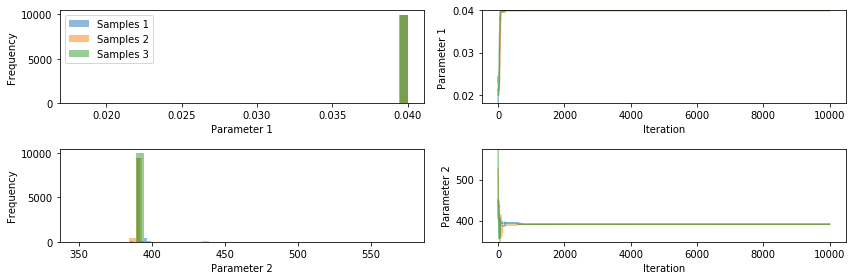

In [36]:
pints.plot.trace(chains_emu)
plt.show()

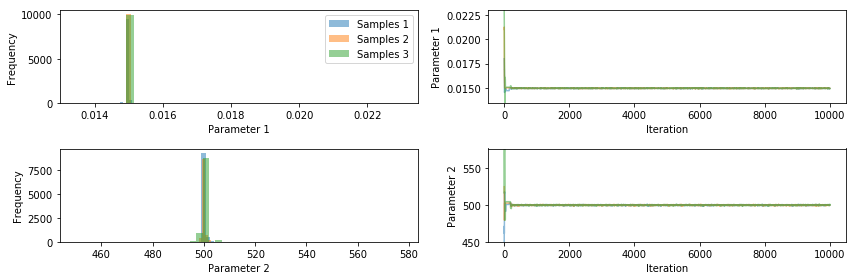

In [37]:
pints.plot.trace(chains)
plt.show()

In [38]:
chain_emu = chains_emu[0]
chain_emu = chain_emu[2000:]
chain = chains[0]
chain = chain[2000:]

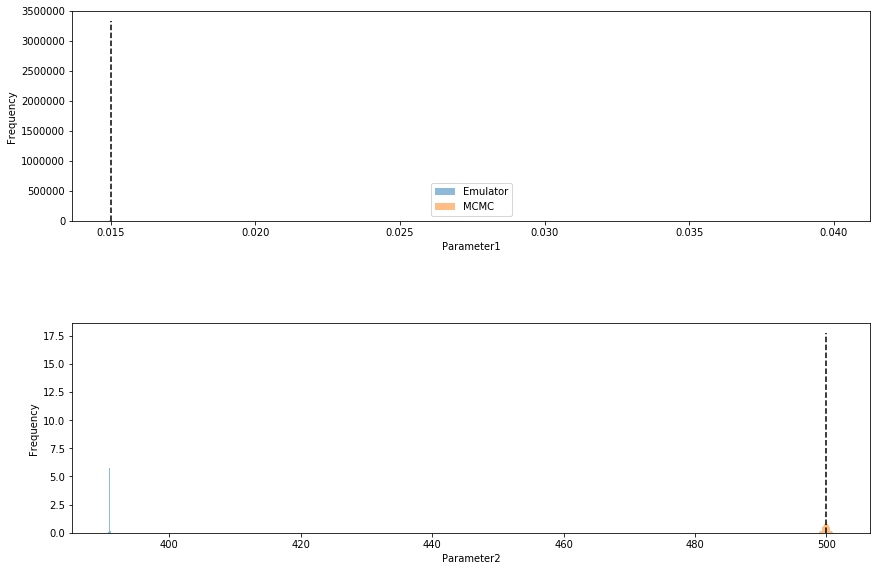

In [39]:
fig, axes = pints.plot.histogram([chain_emu, chain], ref_parameters=true_parameters, sample_names=["Emulator", "MCMC"])
fig.set_size_inches(14, 9)
plt.show()

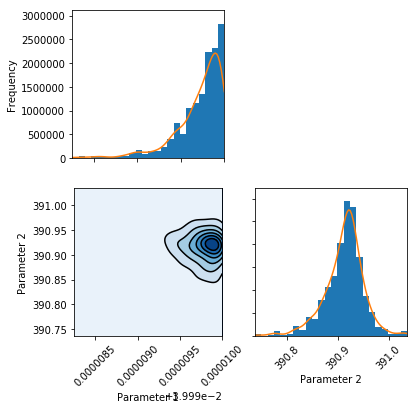

In [40]:
thinned_chain_emu = chain_emu[::10]
pints.plot.pairwise(thinned_chain_emu, kde=True, ref_parameters=true_parameters)
plt.show()

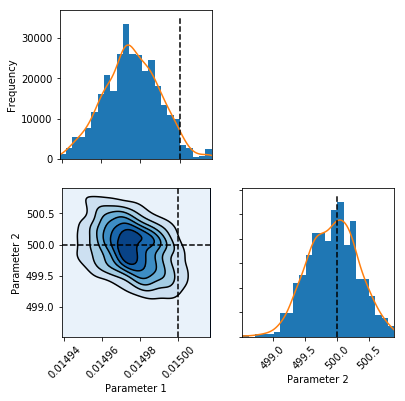

In [41]:
pints.plot.pairwise(thinned_chain, kde=True, ref_parameters=true_parameters)
plt.show()

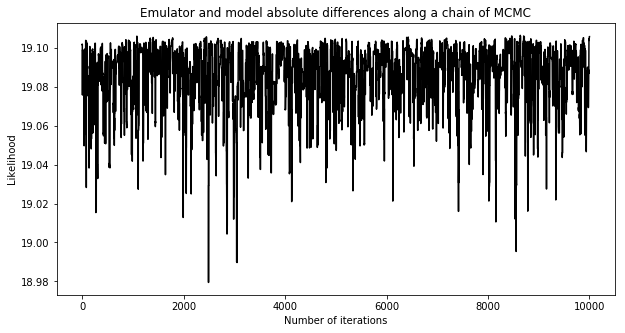

19.105783686726852

In [42]:
emu_prediction = np.apply_along_axis(emu, 1, chain_emu_rescaled).flatten()
model_prediction = np.apply_along_axis(log_likelihood, 1, chain_rescaled).flatten()
diffs = (np.abs((model_prediction - emu_prediction) / model_prediction))

iters = np.linspace(0, 10000, len(chain_emu_rescaled))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute differences along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood")
plt.plot(iters, diffs, color = "Black")
plt.show()

diffs[-1]

In [43]:
chain_emu

array([[3.99999988e-02, 3.90883852e+02],
       [3.99999988e-02, 3.90883852e+02],
       [3.99999763e-02, 3.90948416e+02],
       ...,
       [3.99996839e-02, 3.90825158e+02],
       [3.99996839e-02, 3.90825158e+02],
       [3.99996839e-02, 3.90825158e+02]])

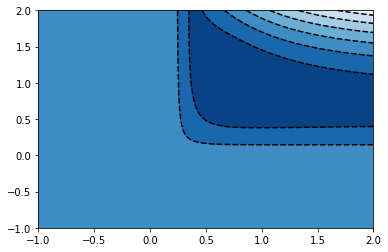

In [44]:
# Create grid
x = [p[0] for p in input_parameters]
y = [p[1] for p in input_parameters]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
plt.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
plt.contour(xx, yy, ll, colors='k')
plt.show()

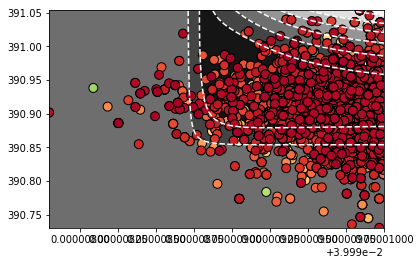

In [45]:
fig, ax = plt.subplots()                   

# Show density 
#ax.imshow(np.rot90(ll), cmap=plt.cm.Blues, extent=[xmin, xmax, ymin, ymax])                                                                     

# Plot chain_emu
x = [p[0] for p in chain_emu]
y = [p[1] for p in chain_emu]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

idx = diffs.argsort()
x_sorted = np.array(x)[idx]
y_sorted = np.array(y)[idx]
diffs_sorted = diffs[idx]

# Add contour lines
ax.contourf(xx, yy, ll, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
plt.contour(xx, yy, ll, colors='w')

# Plot chain_emu
#ax.plot(x, y, 'k.', markersize=2)    
ax.set_xlim([xmin, xmax])                                                                           
ax.set_ylim([ymin, ymax])

ax.scatter(x_sorted, y_sorted, c=diffs_sorted, s=80, edgecolor='k', cmap="RdYlGn_r")
#fig.colorbar(ax)
plt.show()

Running...
Using Emulated Metropolis MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0         0          0:00.0
2     9      0         0.333     0          0:00.0
3     12     0         0.25      0          0:00.0
20    63     0         0.0476    0          0:00.1
40    123    0.0244    0.0244    0.0488     0:00.1
60    183    0.0164    0.0164    0.0328     0:00.2
80    243    0.0123    0.0123    0.0247     0:00.2
100   303    0.0198    0.0099    0.0198     0:00.3
120   363    0.0165    0.00826   0.0165     0:00.3
140   423    0.0142    0.00709   0.0142     0:00.4
160   483    0.0186    0.00621   0.0124     0:00.4
180   543    0.0166    0.00552   0.011      0:00.5
200   603    0.0149    0.00498   0.00995    0:00.6
220   663    0.0226    0.00452   0.0136     0:00.6
240   723    0.0207    0.00415   0.0124     0:00.7
260   783    0.0192    0.00383   0.0115   

c:\users\plagl\pints\pints\_mcmc\_emulated_metropolis.py:154: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


1700  5103   0.00764   0.00588   0.00647    0:05.0
1720  5163   0.00755   0.00581   0.00639    0:05.0
1740  5223   0.00747   0.00574   0.00632    0:05.1
1760  5283   0.00738   0.00568   0.00625    0:05.1
1780  5343   0.0073    0.00561   0.00618    0:05.2
1800  5403   0.00722   0.00555   0.00611    0:05.2
1820  5463   0.00714   0.00549   0.00604    0:05.3
1840  5523   0.00706   0.00598   0.00598    0:05.3
1860  5583   0.00752   0.00591   0.00591    0:05.4
1880  5643   0.00744   0.00585   0.00585    0:05.5
1900  5703   0.00736   0.00579   0.00579    0:05.5
1920  5763   0.00729   0.00573   0.00573    0:05.6
1940  5823   0.00721   0.00567   0.00567    0:05.6
1960  5883   0.00714   0.00561   0.00561    0:05.7
1980  5943   0.00707   0.00555   0.00555    0:05.7
2000  6003   0.007     0.0055    0.0055     0:05.8
2020  6063   0.00693   0.00544   0.00544    0:05.8
2040  6123   0.00686   0.00539   0.00539    0:05.9
2060  6183   0.00679   0.00534   0.00534    0:05.9
2080  6243   0.00673   0.00529 

4960  14883  0.00423   0.00383   0.00403    0:14.1
4980  14943  0.00422   0.00402   0.00402    0:14.1
5000  15003  0.0042    0.004     0.004      0:14.2
5020  15063  0.00418   0.00398   0.00398    0:14.2
5040  15123  0.00417   0.00397   0.00397    0:14.3
5060  15183  0.00415   0.00395   0.00395    0:14.3
5080  15243  0.00413   0.00394   0.00394    0:14.4
5100  15303  0.00412   0.00392   0.00392    0:14.4
5120  15363  0.0041    0.0041    0.00391    0:14.5
5140  15423  0.00408   0.00408   0.00389    0:14.5
5160  15483  0.00407   0.00407   0.00388    0:14.6
5180  15543  0.00405   0.00425   0.00386    0:14.6
5200  15603  0.00404   0.00423   0.00385    0:14.7
5220  15663  0.00402   0.00421   0.00383    0:14.7
5240  15723  0.00401   0.0042    0.00382    0:14.8
5260  15783  0.00399   0.00418   0.0038     0:14.9
5280  15843  0.00398   0.00417   0.00379    0:14.9
5300  15903  0.00396   0.00415   0.00377    0:15.0
5320  15963  0.00395   0.00413   0.00376    0:15.0
5340  16023  0.00393   0.00412 

8180  24543  0.0033    0.00306   0.00391    0:23.1
8200  24603  0.00329   0.00305   0.0039     0:23.2
8220  24663  0.00328   0.00304   0.00389    0:23.3
8240  24723  0.00328   0.00303   0.00388    0:23.3
8260  24783  0.00327   0.00303   0.00387    0:23.4
8280  24843  0.00326   0.00302   0.00386    0:23.4
8300  24903  0.00325   0.00301   0.00385    0:23.5
8320  24963  0.00324   0.003     0.00385    0:23.5
8340  25023  0.00324   0.003     0.00384    0:23.6
8360  25083  0.00323   0.00299   0.00383    0:23.6
8380  25143  0.00322   0.00298   0.00382    0:23.7
8400  25203  0.00321   0.00298   0.00381    0:23.7
8420  25263  0.00321   0.00297   0.0038     0:23.8
8440  25323  0.0032    0.00296   0.00379    0:23.8
8460  25383  0.00319   0.00295   0.00378    0:23.9
8480  25443  0.00318   0.00295   0.00377    0:23.9
8500  25503  0.00318   0.00294   0.00376    0:24.0
8520  25563  0.00317   0.00293   0.00376    0:24.0
8540  25623  0.00316   0.00293   0.00375    0:24.1
8560  25683  0.00315   0.00292 

11460 34383  0.00253   0.00227   0.00297    0:32.1
11480 34443  0.00253   0.00226   0.00296    0:32.2
11500 34503  0.00252   0.00226   0.00296    0:32.2
11520 34563  0.00252   0.00226   0.00295    0:32.3
11540 34623  0.00251   0.00225   0.00295    0:32.3
11560 34683  0.00251   0.00225   0.00294    0:32.4
11580 34743  0.0025    0.00225   0.00294    0:32.4
11600 34803  0.0025    0.00224   0.00293    0:32.5
11620 34863  0.0025    0.00224   0.00293    0:32.5
11640 34923  0.00249   0.00223   0.00292    0:32.6
11660 34983  0.00249   0.00223   0.00292    0:32.6
11680 35043  0.00248   0.00223   0.00291    0:32.7
11700 35103  0.00248   0.00222   0.00291    0:32.7
11720 35163  0.00247   0.00222   0.0029     0:32.8
11740 35223  0.00247   0.00221   0.0029     0:32.8
11760 35283  0.00247   0.00221   0.00289    0:32.9
11780 35343  0.00246   0.00221   0.00289    0:32.9
11800 35403  0.00246   0.0022    0.00288    0:33.0
11820 35463  0.00245   0.0022    0.00288    0:33.1
11840 35523  0.00245   0.0022  

14740 44223  0.00204   0.00183   0.00231    0:40.7
14760 44283  0.00203   0.00183   0.0023     0:40.8
14780 44343  0.00203   0.00183   0.0023     0:40.8
14800 44403  0.00203   0.00182   0.0023     0:40.9
14820 44463  0.00202   0.00182   0.00229    0:40.9
14840 44523  0.00202   0.00182   0.00229    0:41.0
14860 44583  0.00202   0.00182   0.00229    0:41.0
14880 44643  0.00202   0.00181   0.00228    0:41.1
14900 44703  0.00201   0.00181   0.00228    0:41.1
14920 44763  0.00201   0.00181   0.00228    0:41.2
14940 44823  0.00201   0.00181   0.00228    0:41.2
14960 44883  0.00201   0.0018    0.00227    0:41.3
14980 44943  0.002     0.0018    0.00227    0:41.4
15000 45003  0.002     0.0018    0.00227    0:41.4
15020 45063  0.002     0.0018    0.00226    0:41.5
15040 45123  0.00199   0.0018    0.00226    0:41.5
15060 45183  0.00199   0.00179   0.00226    0:41.6
15080 45243  0.00199   0.00179   0.00225    0:41.6
15100 45303  0.00199   0.00179   0.00225    0:41.7
15120 45363  0.00198   0.00179 

17960 53883  0.00167   0.00161   0.00189    0:49.2
17980 53943  0.00167   0.00161   0.00189    0:49.3
18000 54003  0.00167   0.00161   0.00189    0:49.3
18020 54063  0.00166   0.00161   0.00189    0:49.4
18040 54123  0.00166   0.00161   0.00188    0:49.4
18060 54183  0.00166   0.00161   0.00188    0:49.5
18080 54243  0.00166   0.0016    0.00188    0:49.5
18100 54303  0.00166   0.0016    0.00188    0:49.6
18120 54363  0.00166   0.0016    0.00188    0:49.6
18140 54423  0.00165   0.0016    0.00187    0:49.7
18160 54483  0.00165   0.0016    0.00187    0:49.7
18180 54543  0.00165   0.0016    0.00187    0:49.8
18200 54603  0.00165   0.00159   0.00187    0:49.8
18220 54663  0.00165   0.00159   0.00187    0:49.9
18240 54723  0.00164   0.00159   0.00186    0:49.9
18260 54783  0.00164   0.00159   0.00186    0:50.0
18280 54843  0.00164   0.00159   0.00186    0:50.0
18300 54903  0.00164   0.00158   0.00186    0:50.1
18320 54963  0.00164   0.00158   0.00186    0:50.1
18340 55023  0.00164   0.00158 

21200 63603  0.00142   0.00137   0.00165    0:57.8
21220 63663  0.00141   0.00137   0.00165    0:57.9
21240 63723  0.00141   0.00137   0.00165    0:57.9
21260 63783  0.00141   0.001364  0.00165    0:58.0
21280 63843  0.00141   0.00136   0.00164    0:58.1
21300 63903  0.00141   0.00136   0.00164    0:58.1
21320 63963  0.00141   0.00136   0.00164    0:58.2
21340 64023  0.00141   0.00136   0.00164    0:58.2
21360 64083  0.0014    0.00136   0.00164    0:58.3
21380 64143  0.0014    0.00136   0.00164    0:58.3
21400 64203  0.00145   0.00136   0.00164    0:58.4
21420 64263  0.00145   0.00135   0.00163    0:58.4
21440 64323  0.00145   0.00135   0.00163    0:58.5
21460 64383  0.00144   0.00135   0.00163    0:58.5
21480 64443  0.00144   0.00135   0.00163    0:58.6
21500 64503  0.00144   0.00135   0.00163    0:58.6
21520 64563  0.00144   0.00135   0.00163    0:58.7
21540 64623  0.00144   0.00135   0.00162    0:58.7
21560 64683  0.00144   0.00135   0.00162    0:58.8
21580 64743  0.00144   0.00134 

24480 73443  0.00127   0.00118   0.00143    1:06.7
24500 73503  0.00127   0.00118   0.00143    1:06.8
24520 73563  0.00126   0.00118   0.00143    1:06.8
24540 73623  0.00126   0.00118   0.00143    1:06.9
24560 73683  0.00126   0.00118   0.00143    1:06.9
24580 73743  0.00126   0.00118   0.00142    1:07.0
24600 73803  0.00126   0.00118   0.00142    1:07.0
24620 73863  0.00126   0.00118   0.00142    1:07.1
24640 73923  0.00126   0.00118   0.00142    1:07.1
24660 73983  0.00126   0.00118   0.00142    1:07.2
24680 74043  0.00126   0.00117   0.00142    1:07.3
24700 74103  0.00126   0.00117   0.00142    1:07.3
24720 74163  0.00125   0.00117   0.00142    1:07.4
24740 74223  0.00125   0.00117   0.00141    1:07.4
24760 74283  0.00125   0.00117   0.00141    1:07.5
24780 74343  0.00125   0.00117   0.00141    1:07.5
24800 74403  0.00125   0.00117   0.00141    1:07.6
24820 74463  0.00125   0.00117   0.00141    1:07.6
24840 74523  0.00125   0.00117   0.00141    1:07.7
24860 74583  0.00125   0.00117 

27760 83283  0.00112   0.00104   0.0013     1:15.6
27780 83343  0.00112   0.00104   0.0013     1:15.6
27800 83403  0.00112   0.00104   0.00129    1:15.7
27820 83463  0.00111   0.00104   0.00129    1:15.8
27840 83523  0.00111   0.00104   0.00129    1:15.8
27860 83583  0.00111   0.00104   0.00129    1:15.9
27880 83643  0.00111   0.00104   0.00129    1:16.0
27900 83703  0.00111   0.00104   0.00129    1:16.0
27920 83763  0.00111   0.00104   0.00129    1:16.1
27940 83823  0.00111   0.00104   0.00129    1:16.2
27960 83883  0.00111   0.00104   0.00129    1:16.2
27980 83943  0.00111   0.00104   0.00129    1:16.3
28000 84003  0.00111   0.00104   0.00129    1:16.4
28020 84063  0.00111   0.00103   0.00128    1:16.4
28040 84123  0.00111   0.00103   0.00128    1:16.5
28060 84183  0.0011    0.00103   0.00128    1:16.5
28080 84243  0.0011    0.00103   0.00128    1:16.6
28100 84303  0.0011    0.00103   0.00128    1:16.6
28120 84363  0.0011    0.00103   0.00128    1:16.7
28140 84423  0.0011    0.00103 

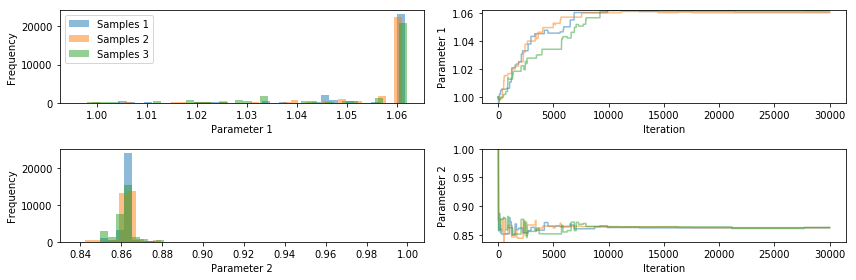

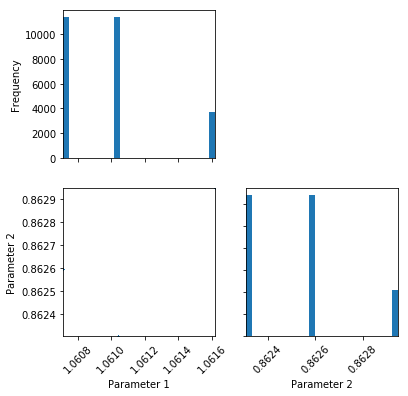

In [49]:
# Choose starting points for 3 mcmc chains
x0s = [
    np.array(start_parameters),# * 0.9,
    np.array(start_parameters),# * 1.05, #1.1
    np.array(start_parameters),# * 1.15,
]
# Choose a covariance matrix for the proposal step
sigma0 = np.abs(true_parameters) * 5e-4

# Create mcmc routine
mcmc = pints.MCMCController(emu, 3, x0s, sigma0=sigma0, method=pints.EmulatedMetropolisMCMC, f=log_posterior)

# Add stopping criterion
mcmc.set_max_iterations(30000)

# Disable logging mode
#mcmc.set_log_to_screen(False)

# Run!
print('Running...')
emulated_chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(emulated_chains)

# Discard warm up
emulated_chains_thinned = emulated_chains[:, 10000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(emulated_chains_thinned))

# Look at distribution in chain 0
pints.plot.pairwise(emulated_chains_thinned[0])

# Show graphs
plt.show()

Running...
Using Metropolis random walk MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0         0          0:00.0
2     9      0         0         0          0:00.0
3     12     0         0         0          0:00.0
20    63     0.0952    0.0476    0.143      0:00.0
40    123    0.0488    0.0732    0.0732     0:00.0
60    183    0.0328    0.0656    0.0656     0:00.0
80    243    0.0247    0.0617    0.0494     0:00.1
100   303    0.0198    0.0495    0.0396     0:00.1
120   363    0.0165    0.0413    0.0331     0:00.1
140   423    0.0142    0.0355    0.0284     0:00.1
160   483    0.0124    0.0311    0.0311     0:00.1
180   543    0.011     0.0331    0.0276     0:00.1
200   603    0.0149    0.0299    0.0249     0:00.1
220   663    0.0181    0.0271    0.0226     0:00.2
240   723    0.0166    0.0249    0.0249     0:00.2
260   783    0.0192    0.0307    0.023 

3100  9303   0.0177    0.0206    0.0145     0:02.2
3120  9363   0.0183    0.0215    0.0144     0:02.2
3140  9423   0.0185    0.0213    0.0143     0:02.2
3160  9483   0.0183    0.0212    0.014236   0:02.2
3180  9543   0.0182    0.0214    0.0141     0:02.2
3200  9603   0.0184    0.0212    0.0141     0:02.3
3220  9663   0.0183    0.0211    0.0146     0:02.3
3240  9723   0.0182    0.021     0.0145     0:02.3
3260  9783   0.0187    0.0209    0.0144     0:02.3
3280  9843   0.0189    0.0207    0.0143     0:02.3
3300  9903   0.0188    0.0206    0.0145     0:02.3
3320  9963   0.019     0.0205    0.0145     0:02.3
3340  10023  0.0189    0.0204    0.0147     0:02.4
3360  10083  0.0187    0.0202    0.0146     0:02.4
3380  10143  0.0186    0.0201    0.0145     0:02.4
3400  10203  0.0185    0.02      0.0147     0:02.4
3420  10263  0.0184    0.0202    0.0146     0:02.4
3440  10323  0.0183    0.0201    0.0145     0:02.4
3460  10383  0.0182    0.0199    0.0144     0:02.4
3480  10443  0.0181    0.0198  

6440  19323  0.0147    0.0163    0.0143     0:04.6
6460  19383  0.0147    0.0163    0.0142     0:04.6
6480  19443  0.0147    0.0162    0.0142     0:04.6
6500  19503  0.0146    0.0162    0.0142     0:04.6
6520  19563  0.0146    0.0161    0.0143     0:04.6
6540  19623  0.0145    0.0161    0.0142     0:04.7
6560  19683  0.0145    0.016     0.0142     0:04.7
6580  19743  0.0144    0.016     0.0141     0:04.7
6600  19803  0.0144    0.0159    0.0141     0:04.7
6620  19863  0.0143    0.0159    0.014      0:04.7
6640  19923  0.0143    0.0158    0.014      0:04.7
6660  19983  0.0144    0.0158    0.014      0:04.7
6680  20043  0.0144    0.0157    0.0139     0:04.7
6700  20103  0.0143    0.0157    0.0139     0:04.8
6720  20163  0.0143    0.0156    0.0138     0:04.8
6740  20223  0.0144    0.0156    0.0138     0:04.8
6760  20283  0.0143    0.0155    0.0138     0:04.8
6780  20343  0.0143    0.0155    0.0137     0:04.8
6800  20403  0.0144    0.0154    0.0137     0:04.8
6820  20463  0.0144    0.0154  

9820  29463  0.0107    0.0111    0.0103     0:06.9
9840  29523  0.0107    0.0111    0.0103     0:07.0
9860  29583  0.0106    0.0111    0.0102     0:07.0
9880  29643  0.0106    0.011     0.0102     0:07.0
9900  29703  0.0106    0.0111    0.0102     0:07.0
9920  29763  0.0106    0.0111    0.0102     0:07.0
9940  29823  0.0106    0.0111    0.0102     0:07.0
9960  29883  0.0105    0.011     0.0101     0:07.0
9980  29943  0.0105    0.011     0.0101     0:07.1
10000 30003  0.0105    0.011     0.0101     0:07.1
10020 30063  0.010478  0.011     0.0101     0:07.1
10040 30123  0.0105    0.011     0.0101     0:07.1
10060 30183  0.0104    0.0109    0.01       0:07.1
10080 30243  0.0104    0.0109    0.01       0:07.1
10100 30303  0.0104    0.0109    0.01       0:07.1
10120 30363  0.0104    0.0109    0.00998    0:07.2
10140 30423  0.0104    0.0108    0.00996    0:07.2
10160 30483  0.0103    0.0108    0.00994    0:07.2
10180 30543  0.0103    0.0108    0.01       0:07.2
10200 30603  0.0103    0.0108  

13060 39183  0.00812   0.00865   0.00789    0:09.1
13080 39243  0.0081    0.00864   0.00787    0:09.2
13100 39303  0.00809   0.00863   0.00786    0:09.2
13120 39363  0.00808   0.00861   0.00785    0:09.2
13140 39423  0.00807   0.0086    0.00784    0:09.2
13160 39483  0.00805   0.00859   0.00783    0:09.2
13180 39543  0.00804   0.00857   0.00781    0:09.2
13200 39603  0.00803   0.00856   0.0078     0:09.2
13220 39663  0.00802   0.00855   0.00779    0:09.2
13240 39723  0.00801   0.00853   0.00778    0:09.3
13260 39783  0.00799   0.00852   0.00777    0:09.3
13280 39843  0.00798   0.00851   0.00776    0:09.3
13300 39903  0.00797   0.0085    0.00774    0:09.3
13320 39963  0.00796   0.00848   0.00773    0:09.3
13340 40023  0.00795   0.00847   0.00772    0:09.3
13360 40083  0.00793   0.00846   0.00771    0:09.3
13380 40143  0.00792   0.00844   0.0077     0:09.4
13400 40203  0.00791   0.00843   0.00769    0:09.4
13420 40263  0.0079    0.00842   0.00767    0:09.4
13440 40323  0.00789   0.00841 

16480 49443  0.006553  0.00704   0.00637    0:11.5
16500 49503  0.00655   0.00703   0.00636    0:11.5
16520 49563  0.00654   0.00702   0.00636    0:11.5
16540 49623  0.00653   0.00701   0.00635    0:11.5
16560 49683  0.00652   0.007     0.00634    0:11.6
16580 49743  0.00651   0.007     0.00633    0:11.6
16600 49803  0.00651   0.00699   0.00632    0:11.6
16620 49863  0.0065    0.00698   0.00632    0:11.6
16640 49923  0.00649   0.00697   0.00631    0:11.6
16660 49983  0.00648   0.00696   0.0063     0:11.6
16680 50043  0.00647   0.00695   0.00629    0:11.6
16700 50103  0.00647   0.00695   0.00629    0:11.6
16720 50163  0.00646   0.00694   0.00628    0:11.7
16740 50223  0.00645   0.00693   0.00627    0:11.7
16760 50283  0.00644   0.00692   0.00626    0:11.7
16780 50343  0.00644   0.00691   0.00626    0:11.7
16800 50403  0.00643   0.0069    0.00625    0:11.7
16820 50463  0.00642   0.0069    0.00624    0:11.7
16840 50523  0.00641   0.00695   0.00623    0:11.7
16860 50583  0.00641   0.00694 

19980 59943  0.00546   0.00596   0.00525    0:13.9
20000 60003  0.00545   0.00595   0.00525    0:13.9
20020 60063  0.00544   0.00594   0.00524    0:13.9
20040 60123  0.00544   0.00594   0.00524    0:13.9
20060 60183  0.00543   0.00593   0.00523    0:13.9
20080 60243  0.00543   0.005926  0.00523    0:13.9
20100 60303  0.00542   0.00592   0.00522    0:14.0
20120 60363  0.00542   0.00591   0.00522    0:14.0
20140 60423  0.00541   0.00591   0.00521    0:14.0
20160 60483  0.00541   0.0059    0.00521    0:14.0
20180 60543  0.0054    0.0059    0.0052     0:14.0
20200 60603  0.0054    0.00589   0.0052     0:14.0
20220 60663  0.00539   0.00588   0.00519    0:14.0
20240 60723  0.00539   0.00588   0.00519    0:14.0
20260 60783  0.00538   0.00587   0.00518    0:14.1
20280 60843  0.00537   0.00587   0.00518    0:14.1
20300 60903  0.00537   0.00586   0.00517    0:14.1
20320 60963  0.00536   0.00586   0.00517    0:14.1
20340 61023  0.00536   0.00585   0.00516    0:14.1
20360 61083  0.00535   0.00584 

23200 69603  0.00509   0.00522   0.00453    0:16.1
23220 69663  0.00508   0.00521   0.00452    0:16.1
23240 69723  0.00508   0.00521   0.00452    0:16.1
23260 69783  0.00507   0.0052    0.00451    0:16.1
23280 69843  0.00507   0.0052    0.00451    0:16.1
23300 69903  0.00506   0.00519   0.00451    0:16.2
23320 69963  0.00506   0.00519   0.0045     0:16.2
23340 70023  0.00506   0.00518   0.0045     0:16.2
23360 70083  0.00505   0.00518   0.00449    0:16.2
23380 70143  0.00505   0.00518   0.00449    0:16.2
23400 70203  0.00504   0.00517   0.00453    0:16.2
23420 70263  0.00504   0.00517   0.00453    0:16.2
23440 70323  0.00503   0.00516   0.00452    0:16.3
23460 70383  0.00503   0.00516   0.00452    0:16.3
23480 70443  0.00503   0.00515   0.00451    0:16.3
23500 70503  0.00502   0.00519   0.00451    0:16.3
23520 70563  0.00502   0.00519   0.00451    0:16.3
23540 70623  0.00501   0.00518   0.0045     0:16.3
23560 70683  0.00501   0.00518   0.0045     0:16.3
23580 70743  0.005     0.00517 

26600 79803  0.00451   0.00466   0.0041     0:18.5
26620 79863  0.00451   0.00466   0.00409    0:18.5
26640 79923  0.0045    0.00465   0.00409    0:18.5
26660 79983  0.0045    0.00465   0.00409    0:18.5
26680 80043  0.0045    0.00465   0.00409    0:18.5
26700 80103  0.00449   0.00464   0.00408    0:18.5
26720 80163  0.00449   0.00464   0.00408    0:18.5
26740 80223  0.00449   0.00464   0.00408    0:18.5
26760 80283  0.00448   0.00463   0.00407    0:18.6
26780 80343  0.00448   0.00463   0.00407    0:18.6
26800 80403  0.00448   0.00463   0.00407    0:18.6
26820 80463  0.00447   0.00462   0.00406    0:18.6
26840 80523  0.00447   0.00462   0.00406    0:18.6
26860 80583  0.00447   0.00462   0.00406    0:18.6
26880 80643  0.00446   0.00461   0.00405    0:18.6
26900 80703  0.00446   0.00461   0.00405    0:18.7
26920 80763  0.00446   0.00461   0.00405    0:18.7
26940 80823  0.00449   0.0046    0.00405    0:18.7
26960 80883  0.00449   0.0046    0.00404    0:18.7
26980 80943  0.00448   0.0046  

R-hat:
[1.0431999788439654, 1.0573863358000097]


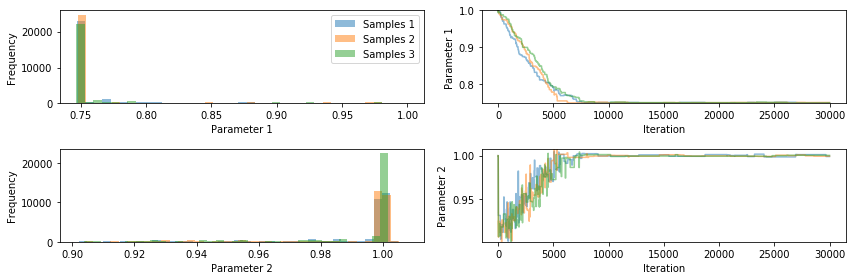

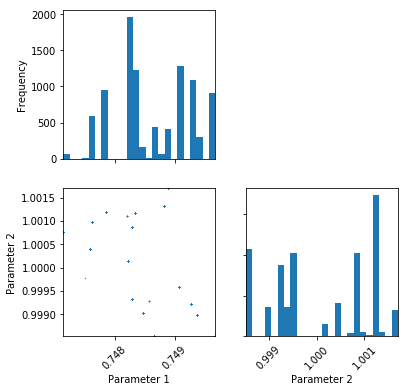

In [50]:
# Choose starting points for 3 mcmc chains
x0s = [
    np.array(start_parameters),# * 0.9,
    np.array(start_parameters),# * 1.05, #1.1
    np.array(start_parameters),# * 1.15,
]
# Choose a covariance matrix for the proposal step
sigma0 = np.abs(true_parameters) * 5e-4

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, x0s, sigma0=sigma0, method=pints.MetropolisRandomWalkMCMC)

# Add stopping criterion
mcmc.set_max_iterations(30000)

# Disable logging mode
#mcmc.set_log_to_screen(False)

# Run!
print('Running...')
metropolis_chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(metropolis_chains)

# Discard warm up
metropolis_chains_thinned = metropolis_chains[:, 10000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(metropolis_chains_thinned))

# Look at distribution in chain 0
pints.plot.pairwise(metropolis_chains_thinned[0])

# Show graphs
plt.show()

In [51]:
metropolis_chains.shape

(3, 30000, 2)

In [52]:
metropolis_chains[0][:10]

array([[1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [0.9979315 , 0.98561418],
       [0.9979315 , 0.98561418],
       [0.9979315 , 0.98561418]])

In [53]:
emulated_chains[0][:10]

array([[1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.]])